In [1]:
import torch
import os
import numpy as np
import copy

os.environ['TORCH'] = torch.__version__
print(torch.__version__)

2.5.1+cu124


In [2]:
# installing the necessary libraries to build the GCN
# please ensure that you have CUDA installed - it allows you to do all your processing on the GPU which is so much faster.
# also, the versions below won't install correctly unless you have torch-2.0.0+cu117 (as printed above)
!pip install torch_geometric
!pip install torch_scatter -f https://data.pyg.org/whl/torch-2.0.0+cu117.html
!pip install torch_sparse -f https://data.pyg.org/whl/torch-2.0.0+cu117.html
    
# install captum for feature importance 
!pip install captum
    

# might have to upgrade shapely:
!pip install --upgrade shapely

# other libraries that may need to be installed:
!pip install pysal

!pip install numpy

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html
Defaulting to user installation because normal site-packages is not writeable
Looking in links: https://data.pyg.org/whl/torch-2.0.0+cu117.html
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable


In [3]:
# now we can import the necessary packages:

# data handling:
import geopandas as gpd
import pandas as pd
import seaborn as sns

import torch.nn as nn
# deep learning libraries:
from torch.nn import Linear
import torch.nn.functional as F

from torch_geometric.nn import GCNConv # Graph Convolution Network.

/home/fr2303/.local/lib/python3.11/site-packages/torch_geometric/typing.py:86: UserWarning: An issue occurred while importing 'torch-scatter'. Disabling its usage. Stacktrace: /home/fr2303/.local/lib/python3.11/site-packages/torch_scatter/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-scatter'. "
/home/fr2303/.local/lib/python3.11/site-packages/torch_geometric/typing.py:124: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: /home/fr2303/.local/lib/python3.11/site-packages/torch_sparse/_version_cuda.so: undefined symbol: _ZN3c1017RegisterOperatorsD1Ev
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


# Section 1: Importing dataset and data preprocessing.

In [4]:
current_dir = os.path.dirname(os.path.dirname(os.getcwd()))

In [5]:
print(current_dir)

/scratch/fr2303


In [6]:
present_maxent_sdf_path = os.path.join(current_dir, "wildfireGCN","Final","ML_input","present_maxent.shp")
print(present_maxent_sdf_path)              

/scratch/fr2303/wildfireGCN/Final/ML_input/present_maxent.shp


In [7]:
present_maxent_sdf = gpd.read_file(present_maxent_sdf_path)
# looking at how much data is available to us.
print(present_maxent_sdf.shape)

(88762, 20)


In [8]:
present_maxent_sdf.head()

layer       hurs        pr   sfcWind        tas     tasmax     tasmin  \
0    1.0  75.291946  2.065749  4.023667  18.056183  23.885965  12.226403   
1    1.0  75.253838  2.062917  4.020584  18.011454  23.842161  12.180749   
2    1.0  75.400543  2.078799  4.064763  18.217747  23.975496  12.459999   
3    1.0  75.354340  2.074121  4.052947  18.154991  23.931211  12.378773   
4    1.0  75.308128  2.069443  4.041131  18.092236  23.886927  12.297546   

       aspect         DEM      slope       river  Acacia  Cstnstv  Eclypts  \
0  155.692688   82.986618  14.933476   74.257401     1.0      0.0      0.0   
1  131.999008  204.336868  16.949665  318.608276     1.0      0.0      0.0   
2  127.233261  159.530380  12.910676  513.545715     1.0      0.0      1.0   
3  106.066582  145.060379  17.142456  358.473694     1.0      0.0      0.0   
4  143.773727  123.798340  16.550346  152.072922     1.0      0.0      0.0   

   Pnspnst  Pinuspn  Qrcsrtn  Qrcssbr  modis_wf  \
0      1.0      0.0      0.0      0.0       0.0   
1      1.0      0.0      0.0      0.0       0.0   
2      1.0      0.0      0.0      0.0       0.0   
3      1.0      0.0      0.0      0.0       0.0   
4      1.0      0.0      0.0      0.0       0.0   

                                            geometry  
0  POLYGON ((194175.268 576088.229, 195175.268 57...  
1  POLYGON ((194175.268 575088.229, 195175.268 57...  
2  POLYGON ((190175.268 574088.229, 191175.268 57...  
3  POLYGON ((191175.268 574088.229, 192175.268 57...  
4  POLYGON ((192175.268 574088.229, 193175.268 57...

In [9]:
print(present_maxent_sdf.dtypes)

layer        float64
hurs         float64
pr           float64
sfcWind      float64
tas          float64
tasmax       float64
tasmin       float64
aspect       float64
DEM          float64
slope        float64
river        float64
Acacia       float64
Cstnstv      float64
Eclypts      float64
Pnspnst      float64
Pinuspn      float64
Qrcsrtn      float64
Qrcssbr      float64
modis_wf     float64
geometry    geometry
dtype: object


In [10]:
nan_rows = present_maxent_sdf[present_maxent_sdf.isna().any(axis=1)]
nan_rows

layer       hurs        pr   sfcWind        tas     tasmax     tasmin  \
61666    1.0  75.980110  0.931953  5.615592  21.425163  26.123564  16.726765   
61857    1.0  75.980133  0.931953  5.615597  21.425020  26.123411  16.726629   
62047    1.0  75.982513  0.931899  5.616125  21.409630  26.107138  16.712120   
62048    1.0  75.980156  0.931952  5.615602  21.424875  26.123259  16.726494   
62237    1.0  75.982750  0.931894  5.616178  21.408087  26.105507  16.710667   
...      ...        ...       ...       ...        ...        ...        ...   
88735    1.0  66.503532  0.660110  3.971492  22.535532  27.882843  17.188223   
88736    1.0  66.447639  0.659634  3.961999  22.581984  27.951233  17.212736   
88737    1.0  66.391739  0.659157  3.952506  22.628435  28.019623  17.237249   
88744    1.0  66.398636  0.659309  3.953507  22.650370  28.048813  17.251928   
88761    1.0        NaN       NaN       NaN        NaN        NaN        NaN   

           aspect         DEM      slope        river  Acacia  Cstnstv  \
61666  150.035782   45.977150   9.863358   123.104156     NaN      NaN   
61857  137.376785   97.621666  11.936030   739.830261     NaN      NaN   
62047  146.335815   81.574341  12.787416  1039.989868     NaN      NaN   
62048  148.237030  168.907715  10.469941  1321.849243     NaN      NaN   
62237  128.806992   64.516129  11.935478   447.239075     NaN      NaN   
...           ...         ...        ...          ...     ...      ...   
88735  133.006516    1.742638   1.427820   331.240295     NaN      NaN   
88736  168.993759    1.511838   1.616338   275.366486     NaN      NaN   
88737  169.683060    1.232589   1.319490   220.808960     NaN      NaN   
88744  159.861588    1.051272   1.182159   432.691376     NaN      NaN   
88761         NaN         NaN        NaN          NaN     NaN      NaN   

       Eclypts  Pnspnst  Pinuspn  Qrcsrtn  Qrcssbr  modis_wf  \
61666      NaN      NaN      NaN      NaN      NaN       0.0   
61857      NaN      NaN      NaN      NaN      NaN       0.0   
62047      NaN      NaN      NaN      NaN      NaN       0.0   
62048      NaN      NaN      NaN      NaN      NaN       0.0   
62237      NaN      NaN      NaN      NaN      NaN       0.0   
...        ...      ...      ...      ...      ...       ...   
88735      NaN      NaN      NaN      NaN      NaN       0.0   
88736      NaN      NaN      NaN      NaN      NaN       0.0   
88737      NaN      NaN      NaN      NaN      NaN       0.0   
88744      NaN      NaN      NaN      NaN      NaN       0.0   
88761      NaN      NaN      NaN      NaN      NaN       NaN   

                                                geometry  
61666  POLYGON ((82175.268 205088.229, 83175.268 2050...  
61857  POLYGON ((82175.268 204088.229, 83175.268 2040...  
62047  POLYGON ((81175.268 203088.229, 82175.268 2030...  
62048  POLYGON ((82175.268 203088.229, 83175.268 2030...  
62237  POLYGON ((81175.268 202088.229, 82175.268 2020...  
...                                                  ...  
88735  POLYGON ((214175.268 4088.229, 215175.268 4088...  
88736  POLYGON ((215175.268 4088.229, 216175.268 4088...  
88737  POLYGON ((216175.268 4088.229, 217175.268 4088...  
88744  POLYGON ((216175.268 3088.229, 217175.268 3088...  
88761  POLYGON ((221175.268 88.229, 222175.268 88.229...  

[90 rows x 20 columns]

In [11]:
present_maxent_sdf.fillna(0, inplace=True)

In [12]:
print(present_maxent_sdf.isna().any().any())

False


In [13]:
present_maxent_sdf.tail()

layer       hurs        pr   sfcWind        tas     tasmax     tasmin  \
88757    1.0  66.304100  0.658734  3.937026  22.798132  28.258600  17.337667   
88758    1.0  66.249931  0.658295  3.927784  22.850080  28.334303  17.365858   
88759    1.0  66.195763  0.657857  3.918541  22.902027  28.410006  17.394049   
88760    1.0  66.141594  0.657418  3.909299  22.953974  28.485710  17.422239   
88761    1.0   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   

           aspect       DEM     slope       river  Acacia  Cstnstv  Eclypts  \
88757   99.401497  1.099293  1.207141  215.039566     0.0      0.0      0.0   
88758  149.202682  1.197518  1.603551  231.404037     0.0      0.0      0.0   
88759  162.440628  1.623115  1.331315  227.402740     0.0      0.0      0.0   
88760  142.258041  1.982349  1.290080  215.649963     0.0      0.0      0.0   
88761    0.000000  0.000000  0.000000    0.000000     0.0      0.0      0.0   

       Pnspnst  Pinuspn  Qrcsrtn  Qrcssbr  modis_wf  \
88757      0.0      0.0      0.0      0.0       0.0   
88758      0.0      0.0      0.0      0.0       0.0   
88759      0.0      0.0      0.0      0.0       0.0   
88760      0.0      0.0      0.0      0.0       0.0   
88761      0.0      0.0      0.0      0.0       0.0   

                                                geometry  
88757  POLYGON ((218175.268 1088.229, 219175.268 1088...  
88758  POLYGON ((219175.268 1088.229, 220175.268 1088...  
88759  POLYGON ((220175.268 1088.229, 221175.268 1088...  
88760  POLYGON ((221175.268 1088.229, 222175.268 1088...  
88761  POLYGON ((221175.268 88.229, 222175.268 88.229...

In [14]:
present_maxent_sdf = present_maxent_sdf.iloc[:-1].reset_index(drop=True)
present_maxent_sdf

layer       hurs        pr   sfcWind        tas     tasmax     tasmin  \
0        1.0  75.291946  2.065749  4.023667  18.056183  23.885965  12.226403   
1        1.0  75.253838  2.062917  4.020584  18.011454  23.842161  12.180749   
2        1.0  75.400543  2.078799  4.064763  18.217747  23.975496  12.459999   
3        1.0  75.354340  2.074121  4.052947  18.154991  23.931211  12.378773   
4        1.0  75.308128  2.069443  4.041131  18.092236  23.886927  12.297546   
...      ...        ...       ...       ...        ...        ...        ...   
88756    1.0  65.967583  0.655851  3.879901  23.073225  28.664127  17.482327   
88757    1.0  66.304100  0.658734  3.937026  22.798132  28.258600  17.337667   
88758    1.0  66.249931  0.658295  3.927784  22.850080  28.334303  17.365858   
88759    1.0  66.195763  0.657857  3.918541  22.902027  28.410006  17.394049   
88760    1.0  66.141594  0.657418  3.909299  22.953974  28.485710  17.422239   

           aspect         DEM      slope       river  Acacia  Cstnstv  \
0      155.692688   82.986618  14.933476   74.257401     1.0      0.0   
1      131.999008  204.336868  16.949665  318.608276     1.0      0.0   
2      127.233261  159.530380  12.910676  513.545715     1.0      0.0   
3      106.066582  145.060379  17.142456  358.473694     1.0      0.0   
4      143.773727  123.798340  16.550346  152.072922     1.0      0.0   
...           ...         ...        ...         ...     ...      ...   
88756  114.258789    2.545327   1.853419  696.071777     0.0      0.0   
88757   99.401497    1.099293   1.207141  215.039566     0.0      0.0   
88758  149.202682    1.197518   1.603551  231.404037     0.0      0.0   
88759  162.440628    1.623115   1.331315  227.402740     0.0      0.0   
88760  142.258041    1.982349   1.290080  215.649963     0.0      0.0   

       Eclypts  Pnspnst  Pinuspn  Qrcsrtn  Qrcssbr  modis_wf  \
0          0.0      1.0      0.0      0.0      0.0       0.0   
1          0.0      1.0      0.0      0.0      0.0       0.0   
2          1.0      1.0      0.0      0.0      0.0       0.0   
3          0.0      1.0      0.0      0.0      0.0       0.0   
4          0.0      1.0      0.0      0.0      0.0       0.0   
...        ...      ...      ...      ...      ...       ...   
88756      0.0      0.0      0.0      0.0      0.0       0.0   
88757      0.0      0.0      0.0      0.0      0.0       0.0   
88758      0.0      0.0      0.0      0.0      0.0       0.0   
88759      0.0      0.0      0.0      0.0      0.0       0.0   
88760      0.0      0.0      0.0      0.0      0.0       0.0   

                                                geometry  
0      POLYGON ((194175.268 576088.229, 195175.268 57...  
1      POLYGON ((194175.268 575088.229, 195175.268 57...  
2      POLYGON ((190175.268 574088.229, 191175.268 57...  
3      POLYGON ((191175.268 574088.229, 192175.268 57...  
4      POLYGON ((192175.268 574088.229, 193175.268 57...  
...                                                  ...  
88756  POLYGON ((224175.268 2088.229, 225175.268 2088...  
88757  POLYGON ((218175.268 1088.229, 219175.268 1088...  
88758  POLYGON ((219175.268 1088.229, 220175.268 1088...  
88759  POLYGON ((220175.268 1088.229, 221175.268 1088...  
88760  POLYGON ((221175.268 1088.229, 222175.268 1088...  

[88761 rows x 20 columns]

In [15]:
# generate unique IDs for each pixel
id_unique = range(len(present_maxent_sdf))

# Insert the 'id' field at a specific position (e.g., index 0)
present_maxent_sdf.insert(loc=0, column='id', value=id_unique)

# drop the 'layer' field because that's not required
present_maxent_sdf = present_maxent_sdf.drop(columns=['layer'])

In [16]:
# we will engineer the aspect feature.
# this is because it is represented by a 360 degree azimuth angle when we computed the aspect
# which our deep learning model cannot understand.
# therefore, we will convert this to trignometric angles:

# sine = east-west direction
# cosine = north-south direction

present_maxent_sdf['aspect_sin'] = np.sin(np.radians(present_maxent_sdf['aspect']))
present_maxent_sdf['aspect_cos'] = np.cos(np.radians(present_maxent_sdf['aspect']))

# drop the 'aspect' field because that's not required
present_maxent_sdf = present_maxent_sdf.drop(columns=['aspect'])

present_maxent_sdf_dup = present_maxent_sdf.copy()

In [17]:
present_maxent_sdf.shape

(88761, 21)

modis_wf
0.0    69791
1.0    18970
Name: count, dtype: int64


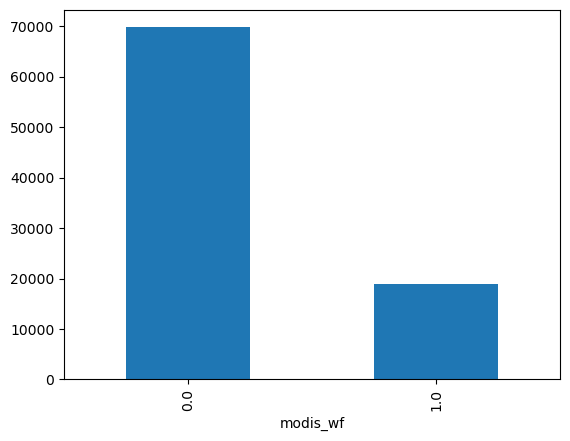

In [18]:
# histogram of frequency
import matplotlib.pyplot as plt
freq = present_maxent_sdf['modis_wf'].value_counts().sort_index()

print(freq)

fig, ax = plt.subplots()
ax = freq.plot(kind='bar')

# i would argue that that is a moderate imbalance

In [19]:
# Filter the geodataframe to select only areas where modis_wf is 1 (indicating wildfire)
wildfire_areas = present_maxent_sdf[present_maxent_sdf['modis_wf'] == 1]

# Calculate the total area of wildfire regions in square meters
# The area() method calculates the area of each geometry
wildfire_area_sqm = wildfire_areas.geometry.area.sum()

# Convert to square kilometers for easier comprehension (optional)
wildfire_area_sqkm = wildfire_area_sqm / 1000000

# Get the total count of wildfire cells
wildfire_count = len(wildfire_areas)

# Calculate the total area of the entire region
total_area_sqm = present_maxent_sdf.geometry.area.sum()
total_area_sqkm = total_area_sqm / 1000000

# Calculate the percentage of area affected by wildfire
percentage_affected = (wildfire_area_sqm / total_area_sqm) * 100

# Print the results
print(f"Number of wildfire cells: {wildfire_count}")
print(f"Total area affected by wildfire: {wildfire_area_sqm:.2f} sq meters ({wildfire_area_sqkm:.2f} sq km)")
print(f"Total area of region: {total_area_sqm:.2f} sq meters ({total_area_sqkm:.2f} sq km)")
print(f"Percentage of area affected by wildfire: {percentage_affected:.2f}%") 

Number of wildfire cells: 18970
Total area affected by wildfire: 18970000000.00 sq meters (18970.00 sq km)
Total area of region: 88761000000.00 sq meters (88761.00 sq km)
Percentage of area affected by wildfire: 21.37%


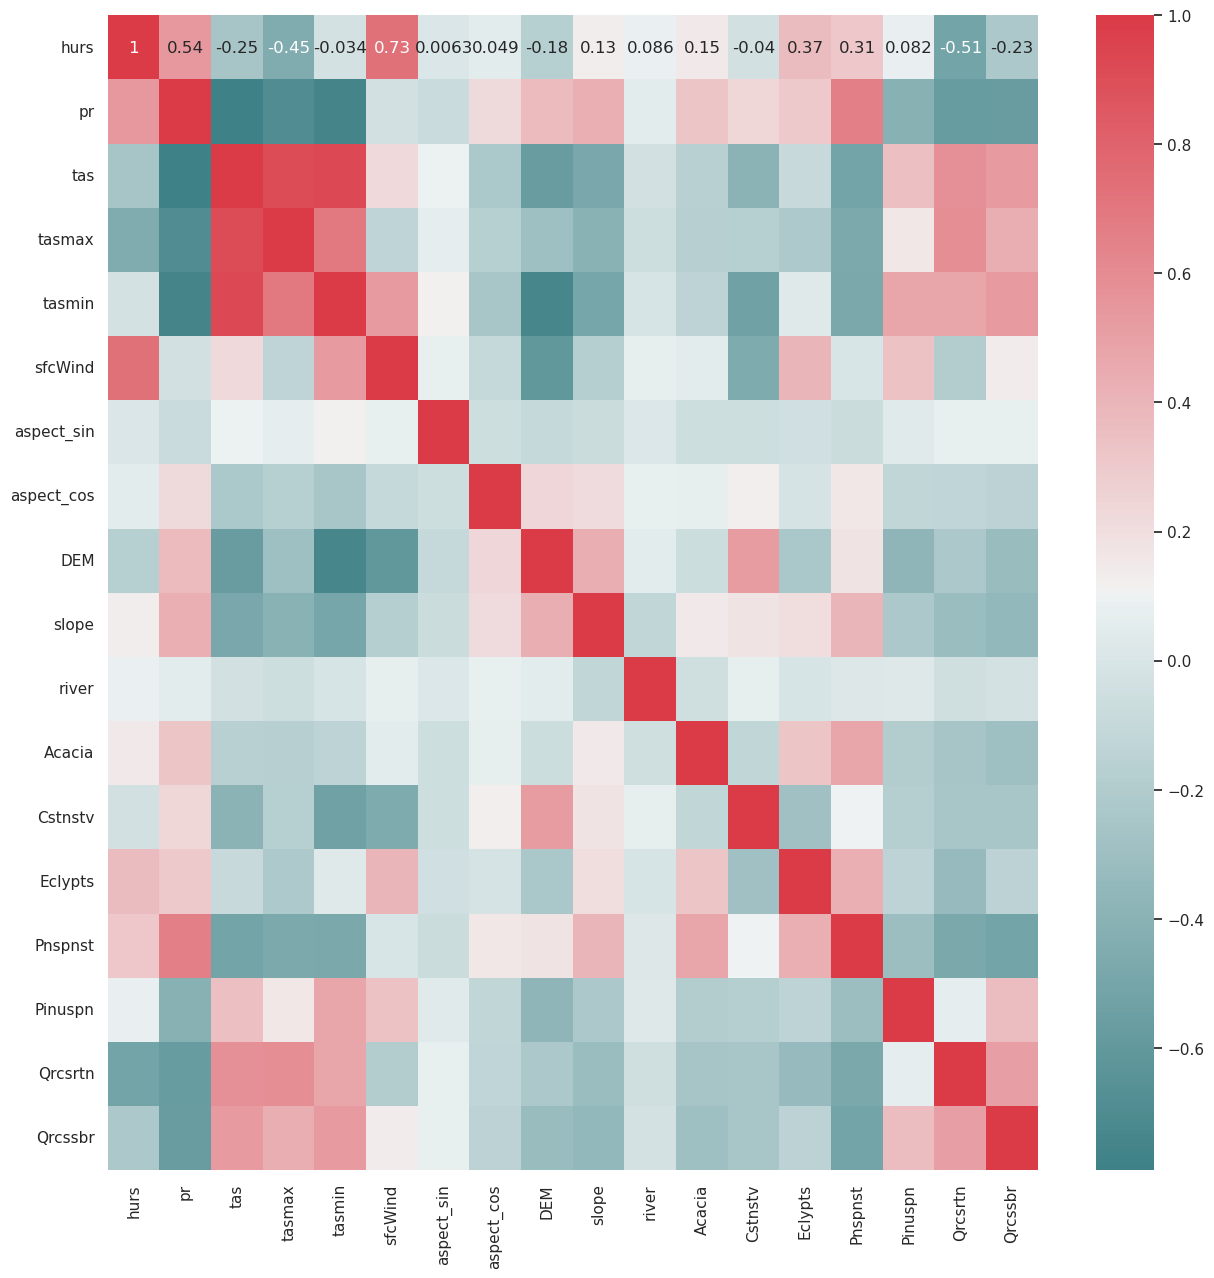

In [20]:
correlation_matrix = present_maxent_sdf[['hurs', 'pr', 'tas','tasmax', 'tasmin', 'sfcWind', 'aspect_sin',
                                      'aspect_cos','DEM', 'slope', 'river', 'Acacia', 'Cstnstv',
                                      'Eclypts','Pnspnst','Pinuspn', 'Qrcsrtn', 'Qrcssbr']].corr()

sns.set(font_scale = 1)
plt.figure(figsize=(15, 15))
sns.heatmap(correlation_matrix, annot=True, cmap=sns.diverging_palette(200, 10, as_cmap=True))
plt.show()

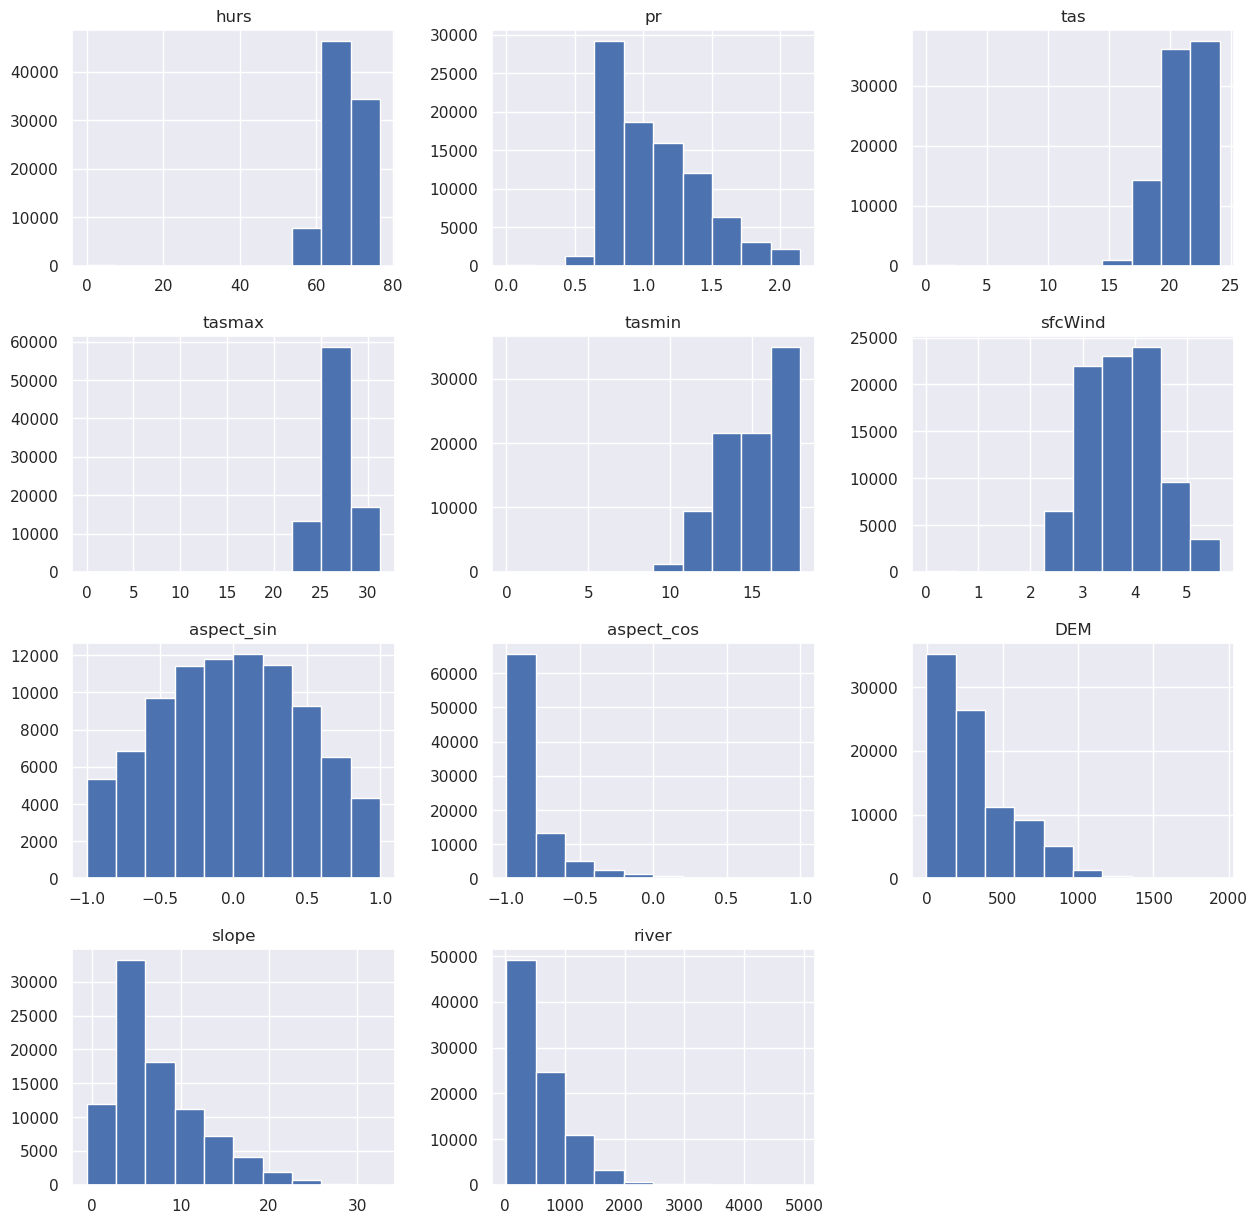

In [21]:
# Univariate analysis
pd.DataFrame.hist(present_maxent_sdf[['hurs', 'pr', 'tas', 'tasmax', 'tasmin', 'sfcWind',
                                     'aspect_sin', 'aspect_cos', 'DEM', 'slope', 'river']], figsize = [15,15]);

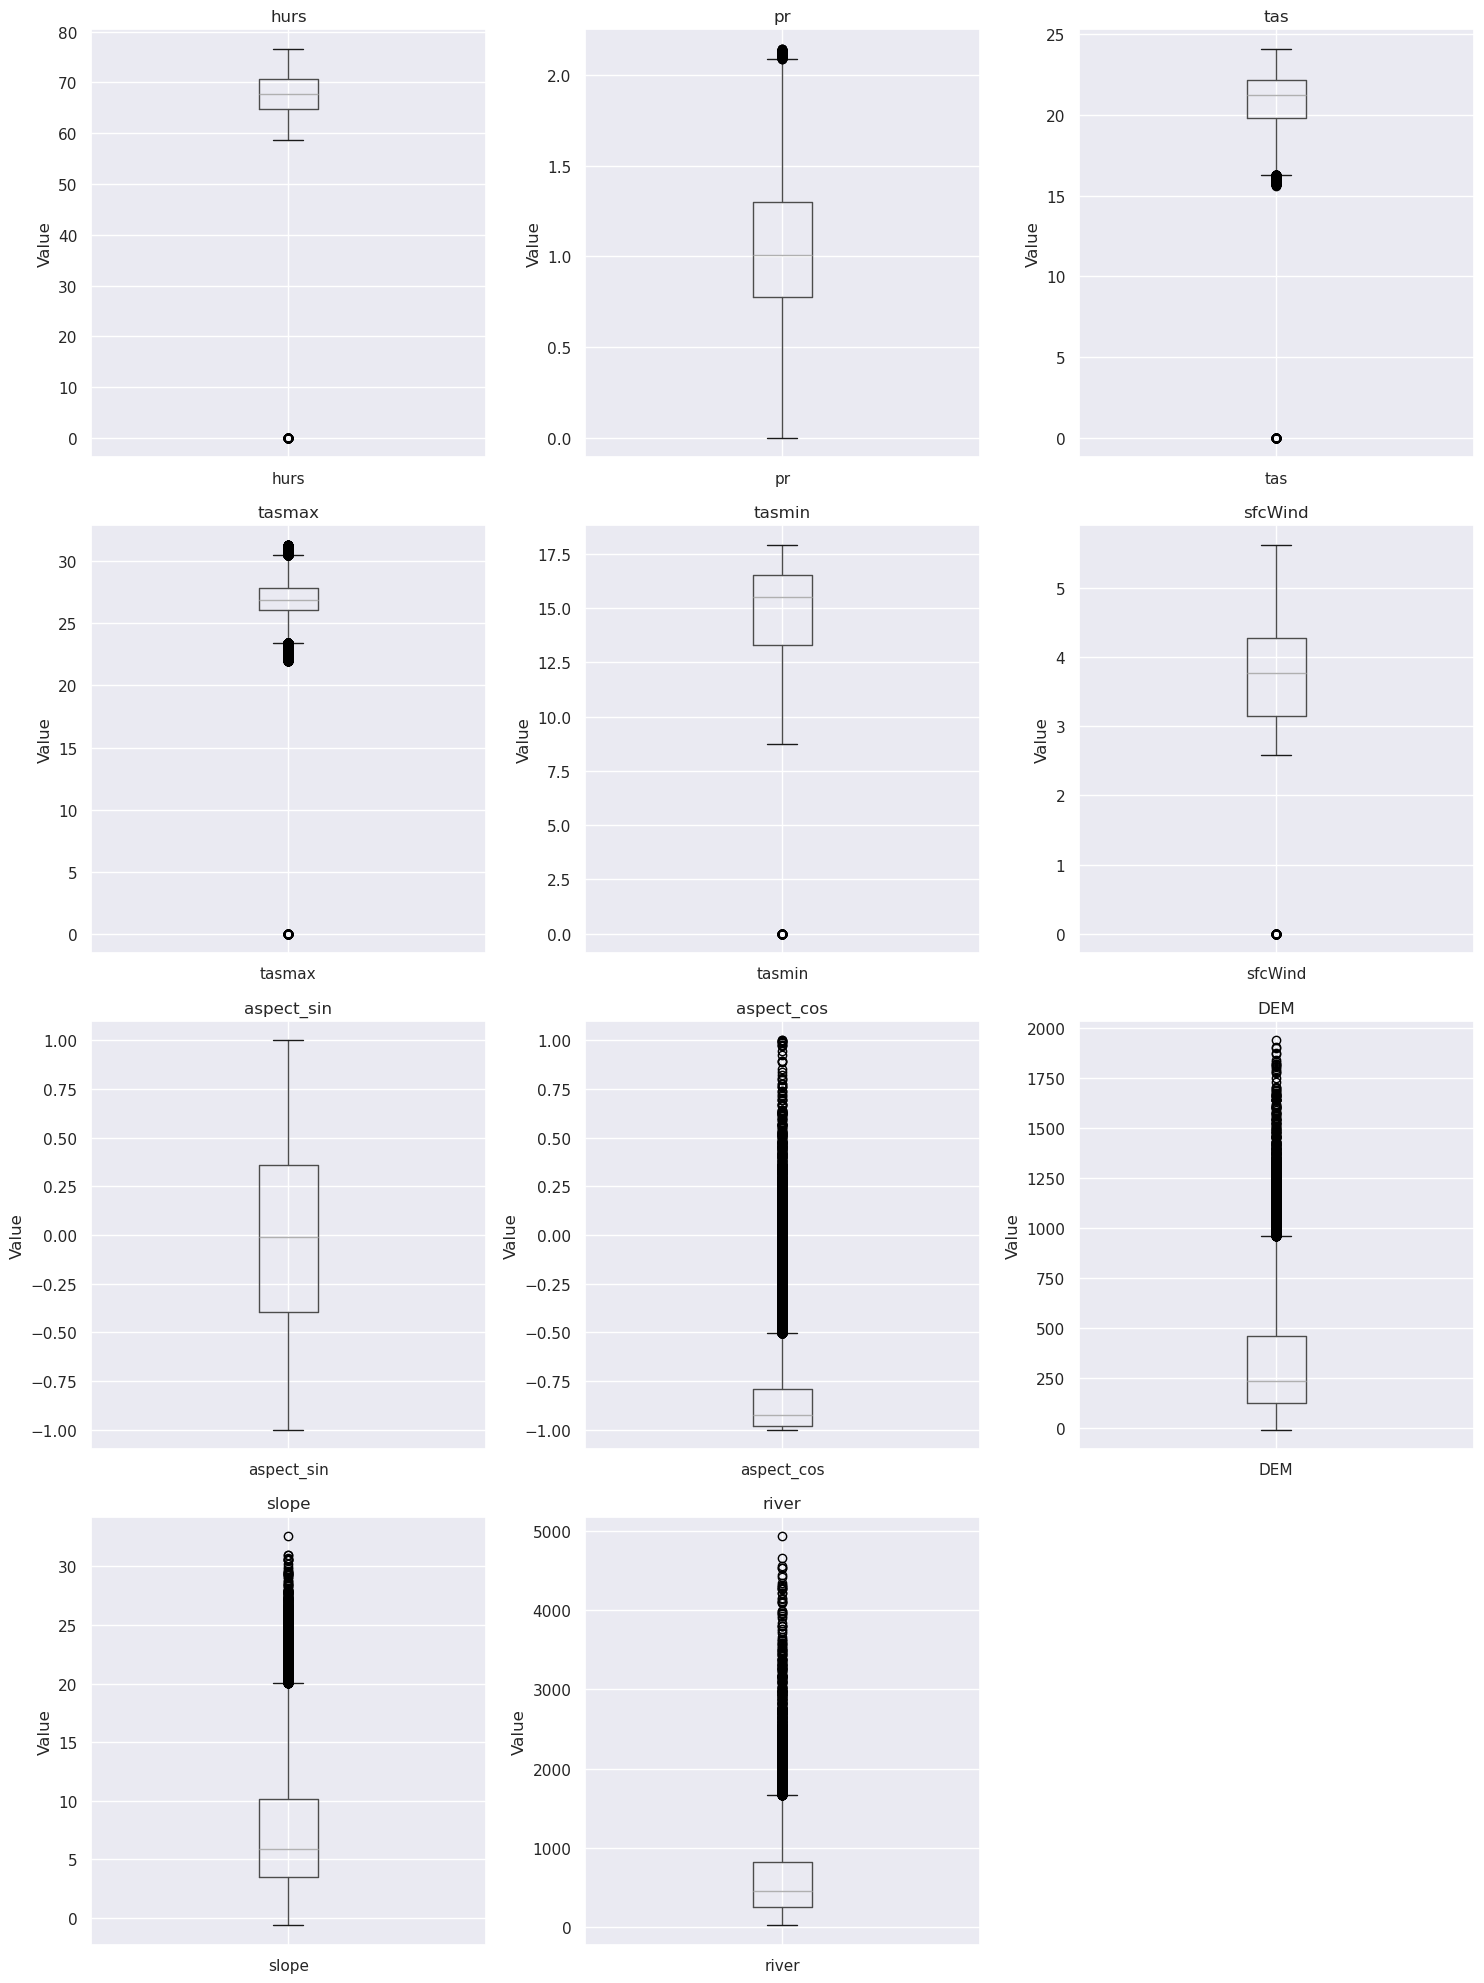

In [22]:
# Univariate analysis
columns_to_plot = ['hurs', 'pr', 'tas', 'tasmax', 'tasmin', 'sfcWind',
                   'aspect_sin', 'aspect_cos', 'DEM', 'slope', 'river']

# Calculate the number of rows and columns for the grid of plots
n_cols = 3  # you can adjust this depending on how many plots you want per row
n_rows = -(-len(columns_to_plot) // n_cols)  # this is a ceiling division trick

fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols, figsize=[15, 5 * n_rows])

for i, col in enumerate(columns_to_plot):
    r, c = divmod(i, n_cols)
    present_maxent_sdf[[col]].boxplot(ax=axes[r, c])
    axes[r, c].set_title(col)
    axes[r, c].set_ylabel("Value")

# Turn off any remaining empty subplots
for j in range(i+1, n_rows * n_cols):
    r, c = divmod(j, n_cols)
    axes[r, c].axis('off')

plt.tight_layout()
plt.show()

# Section 2: Spatial Blocking for train-test-validation splitting.

The nature of the problem we are trying to solve is a spatial one. This means that the distribution of wildfires in Portugal from 2001 - 2021 displays spatial dependence (or autocorrelation). Essentially, nearby areas are more similar to areas that are further away, as per Tobler's First Law of Geography. 

This property of spatial data has heavy implications on how we should model spatial patterns in wildfires and can typically be achieved with Machine Learning algorithms that explicitly take into account spatial dependence. In addition, the way the data is fed into the algorithms can also impact the analysis further down the line. For example, conventional ML tasks involve shuffling the instances before splitting them into their train-test-validation sets. This is to reduce the variability and potentially ordering bias resulting from the sampling procedure. Indeed, this is necessary to improve overall generalization of the model, as well as to reduce overfitting. 

It should be noted that such data are typically unstructured - that is - there are no dependencies between instances within dataset. However, as we have already discussed, spatial data is highly structured and (more often than not) tend to exhib high levels of spatial dependencies between observations that are spatially proximous. Therefore, a random shuffle of the dataset when determining train-test-validation sets is detrimental for spatial analysis and modelling as this structure is destroyed. This can lead to over-fitting and very optimistic results. 

To prevent this, we will adopt a method referred to as 'spatial blocking' which preserves some degree of spatial structure in the data. Essentially, we define non-overlapping 'blocks' of size *n* * *n* over our study region and group our regular grid of polygons for the analysis based on whether they fall into these blocks. The blocks will then be shuffled after which a train-test-validation split of 70-15-15 will be determined.

Note that the graph has already been generated. This means that the spatial structure of the dataset is ALREADY preserved. The ML model will be trained on that graph. However, during the training process, the test and validation set will be 'hidden' from the model, allowing it to learn weights and perform back-propagation only on the training set. 

In [23]:
# spatial blocking

import numpy as np
from shapely.geometry import Polygon

# generation of polygon blocks. Code by Mativane (2019).
# found at: https://gis.stackexchange.com/questions/269243/creating-polygon-grid-using-geopandas

# define block size

# raster is about 1km by 1km 

res_x, res_y = 10000, 10000

# this will create a block of size 40 km * 40 km

# get the bounds of the entire portugal cell dataset

xmin,ymin,xmax,ymax = present_maxent_sdf.total_bounds


# generate the blocks using numpy

# first you build up the columns and rows:
# generate an array of x/y grid size from the minimum of x/y to the maximum

cols = list(np.arange(xmin, 
                      xmax + res_x, 
                      res_x))

rows = list(np.arange(ymin, 
                      ymax + res_y, 
                      res_y))

print('Number of rows:', len(rows))
print('\nNumber of columns:', len(cols))


block_poly = []

for x in cols[:-1]:
    
    for y in rows[:-1]:
        
        block_poly.append(Polygon([(x,y), 
                                   (x + res_x, y), 
                                   (x + res_x, y + res_y), 
                                   (x, y + res_y)]))


        

Number of rows: 59

Number of columns: 30


In [24]:
# create a new GeoDataFrame with the blocks

block_dataframe = gpd.GeoDataFrame({'geometry':block_poly}, 
                                   crs=present_maxent_sdf.crs)

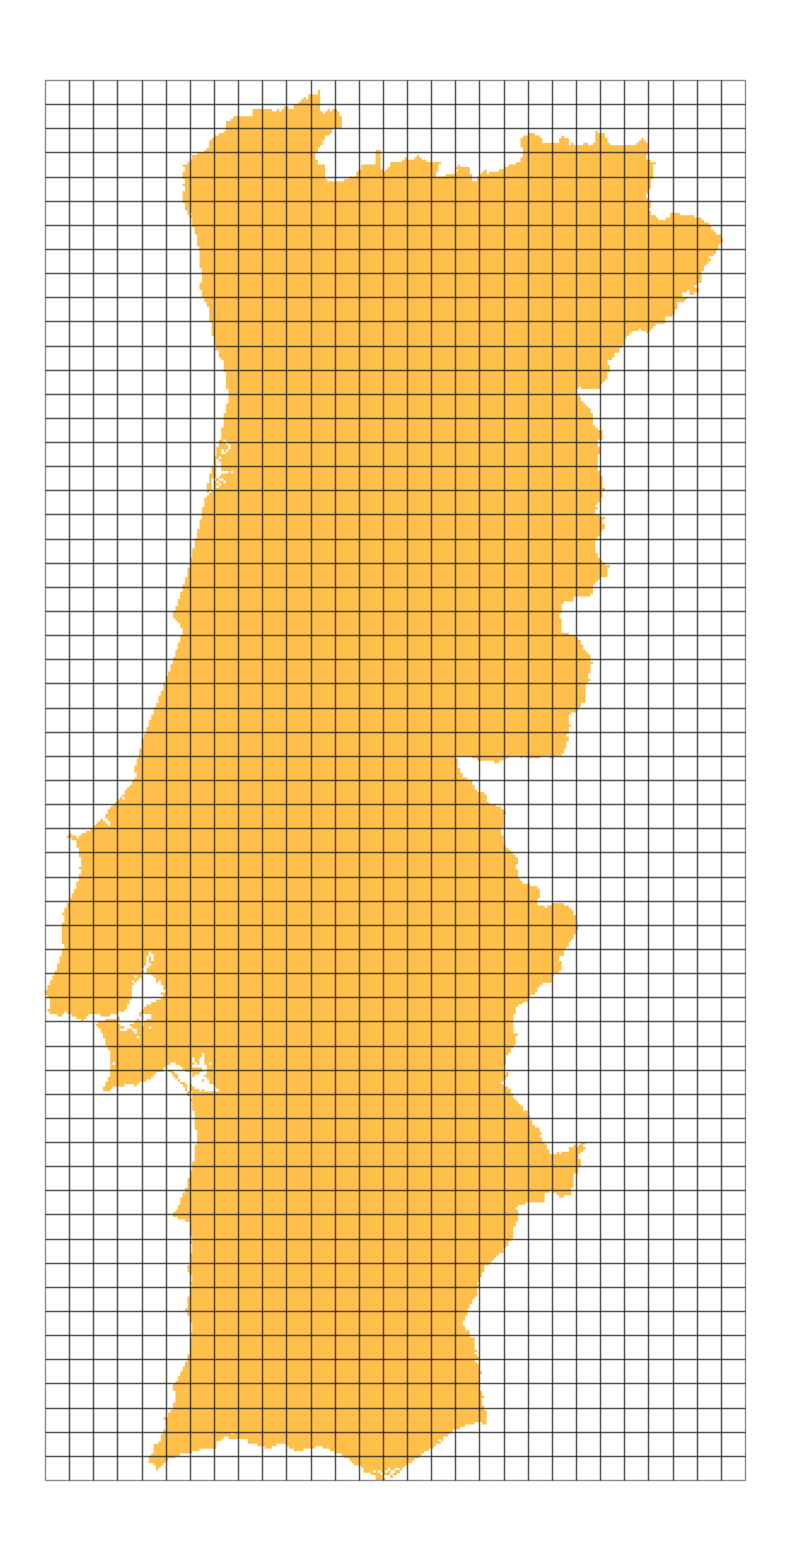

In [25]:
# Merge all raster pixels to show in the plot
shape_merged = present_maxent_sdf.dissolve()

fig, ax = plt.subplots(figsize=(20, 20))

# Set the background to transparent
fig.patch.set_facecolor('none')
ax.set_facecolor('none')

# Plot the geometry
shape_merged.plot(ax=ax, color="orange", edgecolor='none', alpha=0.7)

# Plot block_dataframe
block_dataframe.plot(ax=ax, edgecolor="k", facecolor="none", alpha=0.5)

# Remove x and y axes
ax.axis('off')

# Show the plot
plt.show()

In [26]:
# assign each observation to a block

#  calculate the centroids of wildfires because for within the geometry has to be COMPLETELY WITHIN.
# i.e. if you use the raw polygons, there may be a slight difference which may not result in the desired outcome
# converting it into centroids will ensure that that will work as we intend! 
present_maxent_sdf['centroid'] = present_maxent_sdf.geometry.centroid

# Then, create a new GeoDataFrame with the same data but set the geometry to the centroids
wild_fires_centroids = gpd.GeoDataFrame(present_maxent_sdf, geometry='centroid')

# Now, perform the spatial join using the 'within' operation
present_maxent_sdf = gpd.sjoin(wild_fires_centroids, 
                           block_dataframe, 
                           how="inner", 
                           predicate='within')

# After the join, you can set the geometry back to the original polygons if needed
present_maxent_sdf.set_geometry('geometry', inplace=True)

In [27]:
present_maxent_sdf.shape

(88761, 23)

In [28]:
# rename the 'index right' column to something more sensible.

present_maxent_sdf= present_maxent_sdf.rename(columns = {'index_right': 'block_id'})
# drop the 'layer' field because that's not required
present_maxent_sdf = present_maxent_sdf.drop(columns=['centroid'])

In [29]:
present_maxent_sdf.sort_index(inplace=True)

In [30]:
# now what we want to do is to split the block ids into the train-test-validation set.
# after that, the nodes that correspond to these block ids will be masked during training.
# i.e. the algorithm will train weights only on the training set.

# first get the unique id 
unique_blocks = present_maxent_sdf['block_id'].unique()
unique_blocks

array([ 695,  637,  636,  694,  578,  520,  752,  462,  461,  519,  577,
        635,  693, 1331, 1215, 1389, 1157, 1273,  403, 1447,  809,  402,
        460,  518,  576,  634,  692,  808, 1156, 1214, 1272, 1330, 1388,
       1446,  924,  866, 1504,  344,  982, 1040, 1098,  750,  343,  401,
        459,  517,  575,  633,  691,  749,  807,  865,  923,  981, 1039,
       1097, 1155, 1213, 1271, 1329, 1387, 1445, 1503,  342,  400,  458,
        516,  574,  632,  690,  748,  806,  864,  922,  980, 1038, 1096,
       1154, 1212, 1270, 1328, 1386, 1444, 1502, 1560, 1618,  399,  457,
        515,  573,  631,  689,  747,  805,  863,  921,  979, 1037, 1095,
       1153, 1211, 1269, 1327, 1385, 1443, 1501, 1559, 1617, 1675,  398,
        456,  514,  572,  630,  688,  746,  804,  862,  920,  978, 1036,
       1094, 1152, 1210, 1268, 1326, 1384, 1442, 1500, 1558, 1616,  397,
        455,  513,  571,  629,  687,  745,  803,  861,  919,  977, 1035,
       1093, 1151, 1209, 1267, 1325, 1383, 1441, 14

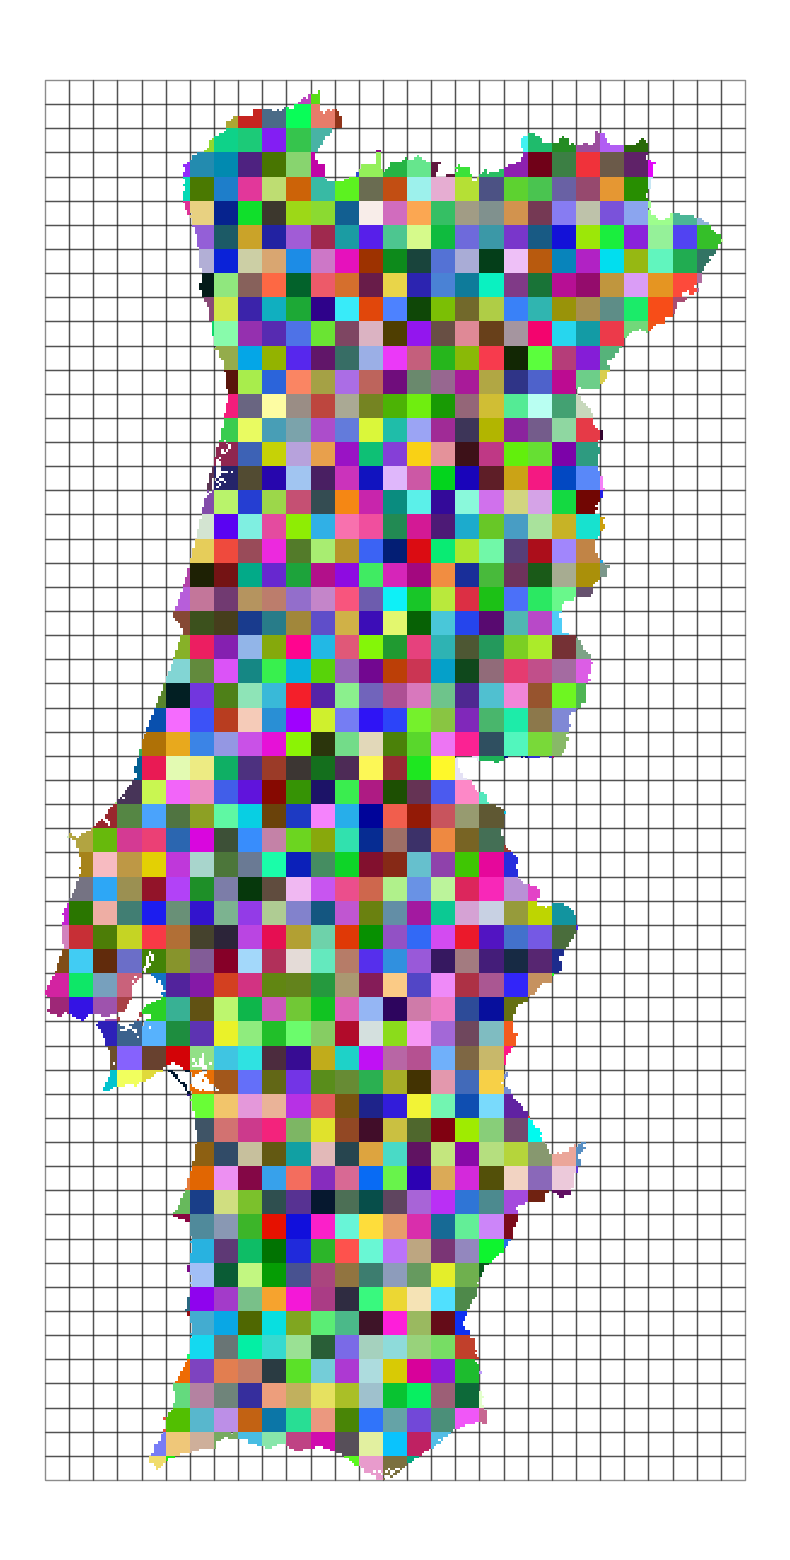

In [31]:
import random

# Assign a random color to each unique block ID (RGB values)
colours = np.random.rand(len(unique_blocks), 3)
colourmap = {block: colour for block, colour in zip(unique_blocks, colours)}

# Merge all raster pixels by dissolving them based on 'block_id'
merged = present_maxent_sdf.dissolve(by='block_id')

# Plot the blocks
fig, ax = plt.subplots(figsize=(20, 20))

# Set the background to transparent
fig.patch.set_facecolor('none')
ax.set_facecolor('none')

# Remove x and y axes
ax.axis('off')

# Plot the base layer (e.g., block boundaries)
block_dataframe.plot(ax=ax, edgecolor="k", facecolor="none", alpha=0.5)

# Plot the merged blocks with the assigned colors
for value, colour in colourmap.items():
    merged[merged.index == value].plot(ax=ax, color=colour, edgecolor="none", label=value)

# Show the plot
plt.show()

In [32]:
from sklearn.model_selection import train_test_split

train_block, intermediate_block = train_test_split(unique_blocks, 
                                                  test_size = 0.3,
                                                  random_state = 1)

test_block, validation_block = train_test_split(intermediate_block,#
                                               test_size = 0.5,
                                               random_state = 7)


In [33]:
# lets count the number of instances in each split:

train_count = present_maxent_sdf[present_maxent_sdf['block_id'].isin(train_block)].shape[0]
test_count = present_maxent_sdf[present_maxent_sdf['block_id'].isin(test_block)].shape[0]
val_count = present_maxent_sdf[present_maxent_sdf['block_id'].isin(validation_block)].shape[0]

total_count =  train_count + test_count + val_count

print(f'Total: {total_count}')

print(f"Train count: {train_count}, percentage: {(train_count/total_count) * 100}") 
print(f"Test count: {test_count}, percentage: {(test_count/total_count) * 100}") 
print(f"Validation count: {val_count}, percentage: {(val_count/total_count) * 100}") 

# the split is actually not bad considering we have some edge blocks that have very low number of instances.

Total: 88761
Train count: 62061, percentage: 69.91922127961605
Test count: 13413, percentage: 15.11136647852097
Validation count: 13287, percentage: 14.969412241862981


In [34]:
condition_train = present_maxent_sdf['block_id'].isin(train_block)
condition_test = present_maxent_sdf['block_id'].isin(test_block)
condition_val = present_maxent_sdf['block_id'].isin(validation_block)

conditions = [condition_train, condition_test, condition_val]

labels = ['train', 'test', 'validation']

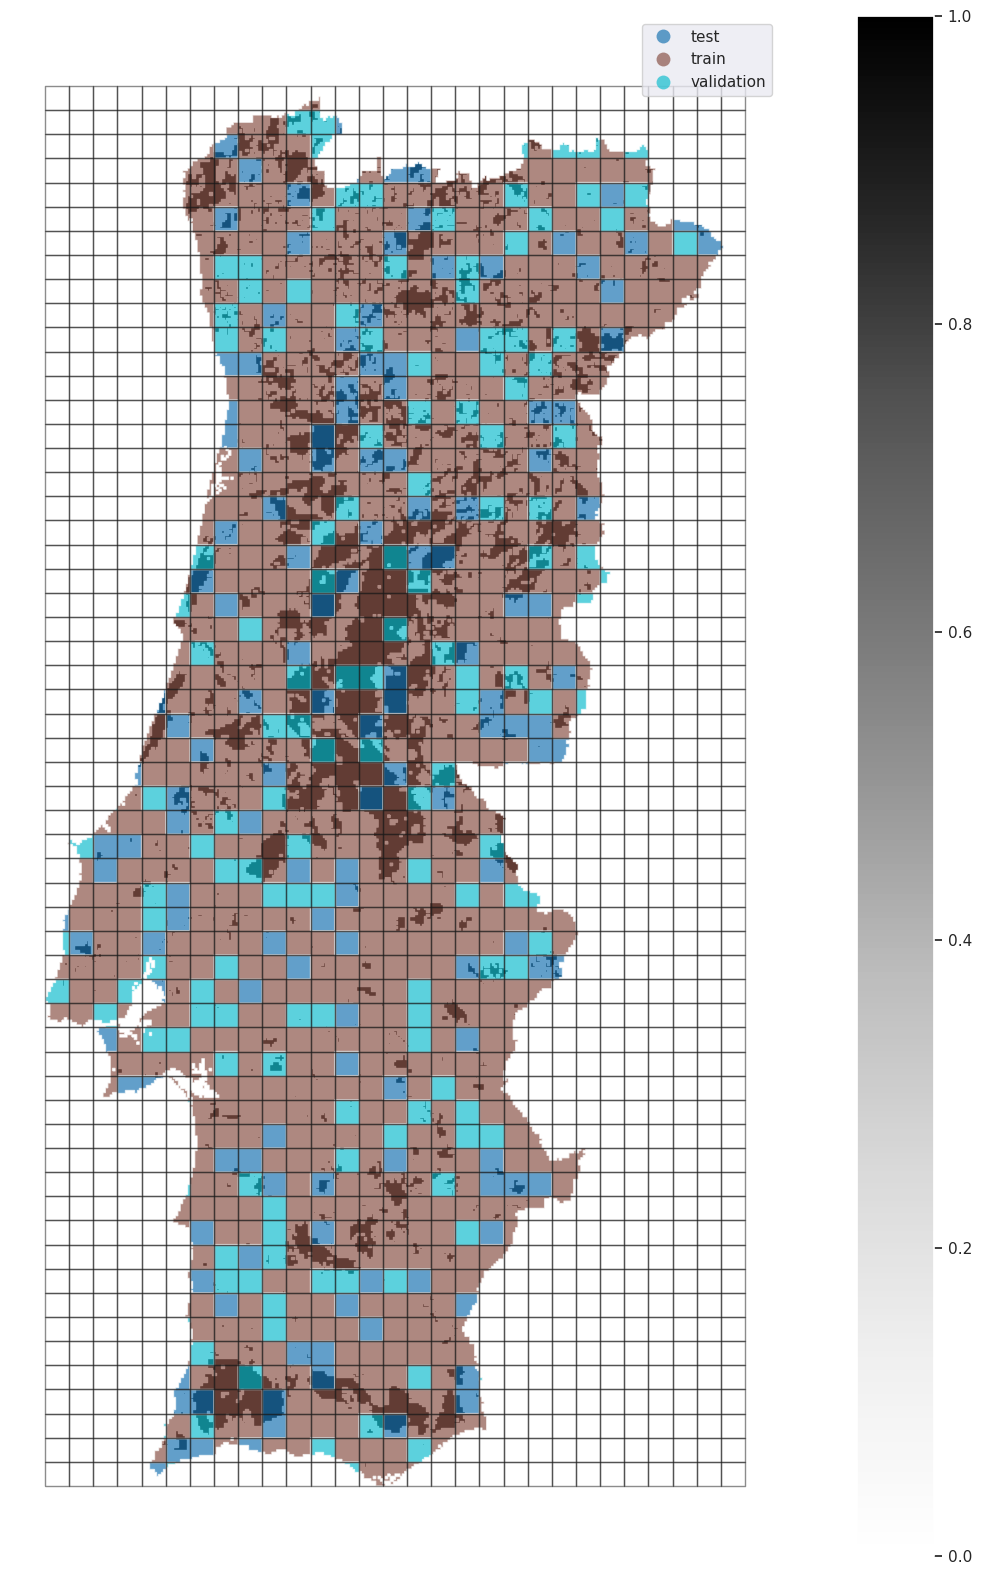

In [35]:
present_maxent_sdf['split'] = np.select(conditions, labels)

# Merge small grid cells based on the 'split' column, retaining the split values
merged_split = present_maxent_sdf.dissolve(by='split', aggfunc='first').reset_index()
merged_mods = present_maxent_sdf.dissolve(by='modis_wf',aggfunc='first').reset_index()

# Plot the blocks
fig, ax = plt.subplots(figsize=(20, 20))
# Set the background to transparent
fig.patch.set_facecolor('none')
ax.set_facecolor('none')

ax.axis('off')


# Plot the base layer from present_cci_sdf with 'mods_wf' column
merged_mods.plot(
    ax=ax, 
    legend=True,
    column='modis_wf',
    cmap='Greys'
)

# Plot the merged regions for train-test-validation on top, with transparency
merged_split.plot(
    ax=ax,
    column='split',  # Use the 'split' column for coloring
    legend=True,
    alpha=0.7
)

# Optionally overlay the block grid (if needed for reference)
block_dataframe.plot(ax=ax, edgecolor="k", facecolor="none", alpha=0.5)

# Show the plot
plt.show()

In [36]:
# data normalization.

def extract_x_y_i(split):
    
    # features
    xs = split[['hurs', 'pr', 'tas', 'tasmax', 'tasmin', 'sfcWind', 'aspect_sin',
                'aspect_cos','DEM', 'slope', 'river']]
    
    # target label
    ys = split['modis_wf']
    
    # save the id as well so that we can reconstruct the dataframe with the normalised values.
    
    ids = split['id']
    
    return xs, ys, ids
    

# subset the data based on the train/test/validation labels.
train_split = present_maxent_sdf[present_maxent_sdf['split'] == 'train']
test_split = present_maxent_sdf[present_maxent_sdf['split'] == 'test']
validation_split = present_maxent_sdf[present_maxent_sdf['split'] == 'validation']

# now lets extract the values
xs_train, ys_train, id_train = extract_x_y_i(train_split)
xs_test, ys_test, id_test = extract_x_y_i(test_split)
xs_validation, ys_validation, id_validation = extract_x_y_i(validation_split)

id_test

81          81
115        115
116        116
151        151
152        152
         ...  
88676    88676
88677    88677
88700    88700
88701    88701
88720    88720
Name: id, Length: 13413, dtype: int64

In [37]:
# standard scaling:

from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler

scaler = RobustScaler()

xs_train_scaled = scaler.fit_transform(xs_train)
xs_validation_scaled = scaler.transform(xs_validation)
xs_test_scaled = scaler.transform(xs_test)
    

# check if the normalisation worked:
np.set_printoptions(suppress=True)
print ("\n")
print(np.mean(xs_train_scaled, axis = 0))
print(np.mean(xs_validation_scaled, axis=0))
print(np.mean(xs_test_scaled, axis=0))

# satisfactory




[ 0.00626207  0.12974974 -0.10809004 -0.0096527  -0.16240834 -0.01236367
 -0.00270648  0.43333206  0.2501257   0.22714521  0.25291539]
[ 0.05388192  0.15008915 -0.12655259 -0.02903213 -0.17821338  0.00644551
  0.0176975   0.40917907  0.3063338   0.24708174  0.26289195]
[ 0.03453382  0.13337764 -0.12160565 -0.06703598 -0.1498962   0.03285094
  0.01954781  0.45383727  0.2171738   0.28840512  0.24605233]


In [38]:
# now we reconstruct the dataframe with these scaled values!

import pandas as pd


# first we need to convert the x values back into dataframes, preserving both the indices and the column names:
xs_train_2 = pd.DataFrame(xs_train_scaled, index=xs_train.index, columns=xs_train.columns)
xs_test_2 = pd.DataFrame(xs_test_scaled, index=xs_test.index, columns=xs_test.columns)
xs_validation_2 = pd.DataFrame(xs_validation_scaled, index=xs_validation.index, columns=xs_validation.columns)



scaled_train_split = pd.concat([id_train, xs_train_2, ys_train], axis=1)
scaled_test_split = pd.concat([id_test, xs_test_2, ys_test], axis=1)
scaled_validation_split = pd.concat([id_validation, xs_validation_2, ys_validation], axis=1)


In [39]:
# check intregity of the indices
# bascially, this checks to see if the index in the original dataframe is equal to the index in the train test and 
# validation splits
# if they're not you fucked up and you need to go back and check that shit

mask_train = (scaled_train_split.index == scaled_train_split['id'])
mask_test = (scaled_test_split.index == scaled_test_split['id'])
mask_val = (scaled_validation_split.index == scaled_validation_split['id'])


print(f'train set validity: {mask_train.all()}')
print(f'test set validity: {mask_test.all()}')
print(f'validation set validity: {mask_val.all()}')

train set validity: True
test set validity: True
validation set validity: True


In [40]:
scaled_validation_split.head()

id      hurs        pr       tas    tasmax    tasmin   sfcWind  \
30  30  1.346402  2.093933 -1.184241 -1.581275 -0.837225  0.315441   
31  31  1.338558  2.085322 -1.211758 -1.606649 -0.862737  0.304647   
32  32  1.330713  2.076710 -1.239274 -1.632022 -0.888248  0.293853   
33  33  1.322869  2.068099 -1.266790 -1.657396 -0.913760  0.283059   
34  34  1.315024  2.059487 -1.294305 -1.682770 -0.939271  0.272266   

    aspect_sin  aspect_cos       DEM     slope     river  modis_wf  
30    0.241369   -0.318279 -0.500718  0.308874 -0.177086       0.0  
31    0.692699    0.329795 -0.397332 -0.026125  0.718191       0.0  
32    1.195682    2.425086 -0.267841  0.599410  0.719255       0.0  
33    1.095017    1.778634 -0.241251  0.671810 -0.399615       0.0  
34    1.001937    1.324077 -0.144745  0.457764 -0.403196       0.0

In [41]:
# check to see for any NA values - indicates that something went wrong.
scaled_test_split.isna().any().any()


False

In [42]:
# and finally, we can attach this back to the original dataset for processing further on:

# first let's get rid of all the un-scaled features.
present_maxent_sdf = present_maxent_sdf[['geometry', 'block_id','Acacia', 'Cstnstv','Eclypts','Pnspnst','Pinuspn', 'Qrcsrtn', 'Qrcssbr' ]]

# merge the scaled train test and validation sets vertically:
merged_scaled = pd.concat([scaled_train_split, scaled_test_split, scaled_validation_split])
merged_scaled.sort_index(inplace=True)

In [43]:
# Calculate the mean of each numeric column
column_means = merged_scaled.mean()

print(column_means)

id            44380.000000
hurs              0.017663
pr                0.133343
tas              -0.112896
tasmax           -0.021225
tasmin           -0.162884
sfcWind          -0.002716
aspect_sin        0.003711
aspect_cos        0.432815
DEM               0.253560
slope             0.239387
river             0.253372
modis_wf          0.213720
dtype: float64


In [44]:
mask = (merged_scaled.index == merged_scaled['id'])
print(mask.all())

True


In [45]:
present_maxent_sdf.sort_index(inplace=True)

In [46]:
# then perform a left join with the original dataset (which have had the unscaled features removed)
present_maxent_sdf = pd.concat([present_maxent_sdf, merged_scaled], axis=1)


In [47]:
present_maxent_sdf.head()

geometry  block_id  Acacia  \
0  POLYGON ((194175.268 576088.229, 195175.268 57...       695     1.0   
1  POLYGON ((194175.268 575088.229, 195175.268 57...       695     1.0   
2  POLYGON ((190175.268 574088.229, 191175.268 57...       637     1.0   
3  POLYGON ((191175.268 574088.229, 192175.268 57...       695     1.0   
4  POLYGON ((192175.268 574088.229, 193175.268 57...       695     1.0   

   Cstnstv  Eclypts  Pnspnst  Pinuspn  Qrcsrtn  Qrcssbr  id  ...       tas  \
0      0.0      0.0      1.0      0.0      0.0      0.0   0  ... -1.343517   
1      0.0      0.0      1.0      0.0      0.0      0.0   1  ... -1.362831   
2      0.0      1.0      1.0      0.0      0.0      0.0   2  ... -1.273754   
3      0.0      0.0      1.0      0.0      0.0      0.0   3  ... -1.300852   
4      0.0      0.0      1.0      0.0      0.0      0.0   4  ... -1.327950   

     tasmax    tasmin   sfcWind  aspect_sin  aspect_cos       DEM     slope  \
0 -1.688320 -1.007103  0.224341    0.567612    0.073647 -0.471548  1.403488   
1 -1.712769 -1.021309  0.221534    1.005403    1.339251 -0.099611  1.715315   
2 -1.638350 -0.934416  0.261743    1.075421    1.673929 -0.236942  1.090637   
3 -1.663067 -0.959691  0.250989    1.292995    3.389249 -0.281292  1.745133   
4 -1.687784 -0.984966  0.240235    0.804443    0.620475 -0.346460  1.653556   

      river  modis_wf  
0 -0.673874       0.0  
1 -0.240922       0.0  
2  0.104478       0.0  
3 -0.170286       0.0  
4 -0.535997       0.0  

[5 rows x 22 columns]

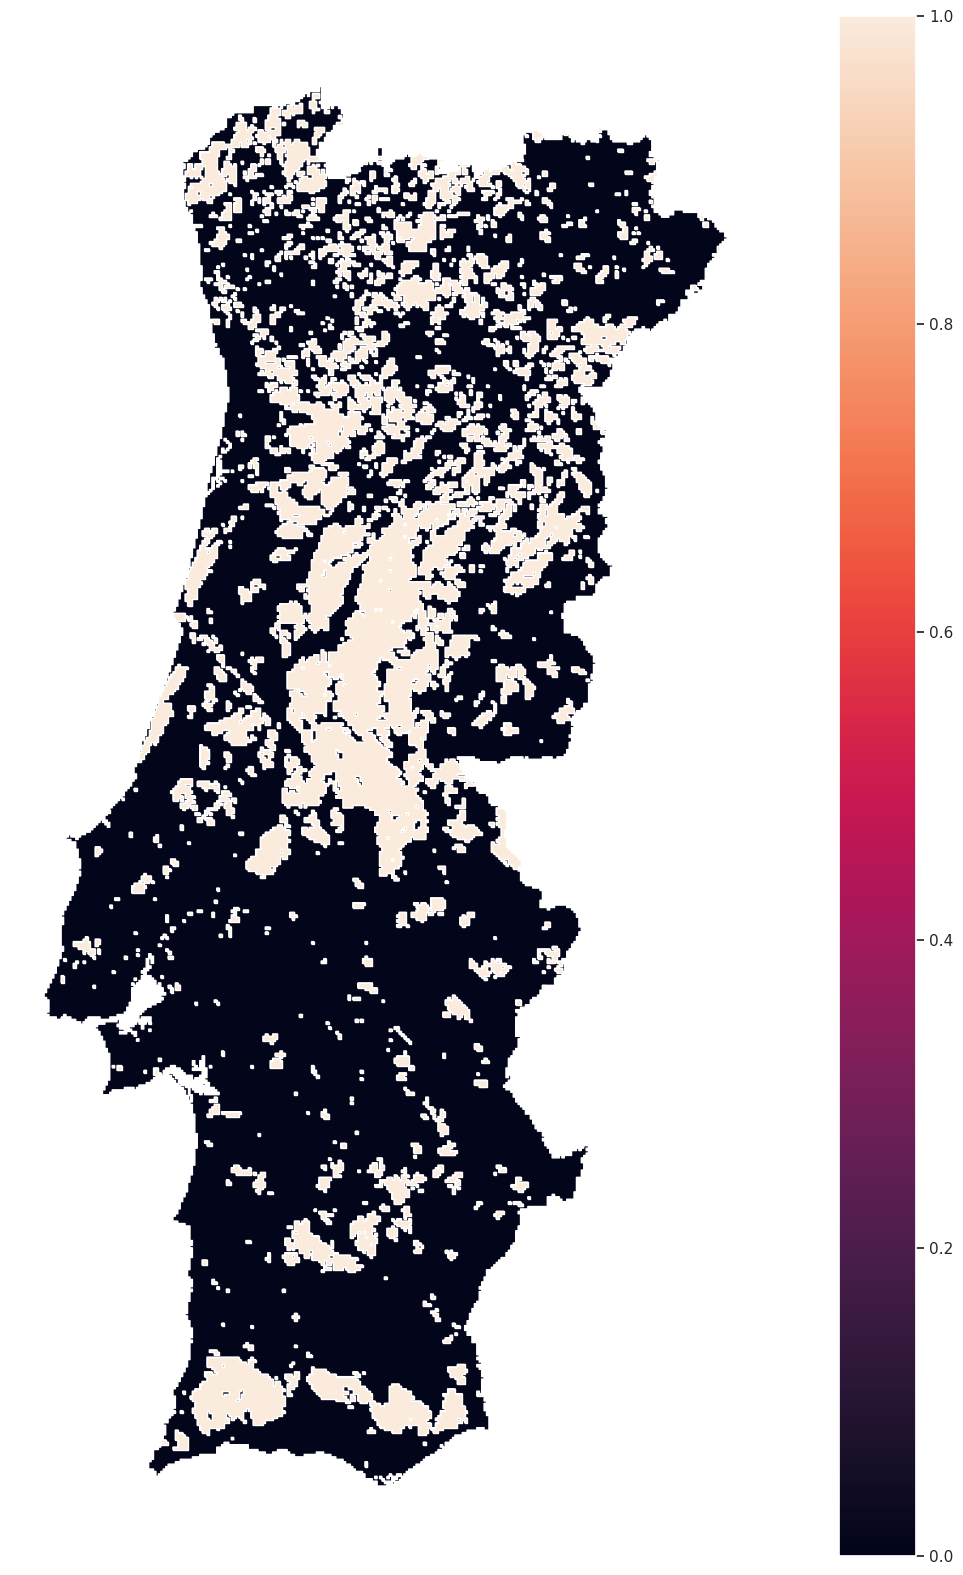

In [48]:
# visualise the final output.
# we will use the wild fire attribute just to see if there has been any mix up (because i know what it looks like).

fig, ax = plt.subplots(figsize=(20, 20))
# Set the background to transparent
fig.patch.set_facecolor('none')
ax.set_facecolor('none')
ax.axis('off')

ax.spines['bottom'].set_color('black')  # Bottom spine
ax.spines['left'].set_color('black')    # Left spine
ax.tick_params(axis='x', colors='black')  # x-axis ticks
ax.tick_params(axis='y', colors='black')  # y-axis ticks


merged_mods = present_maxent_sdf.dissolve(by='modis_wf',aggfunc='first').reset_index()
merged_mods.plot(ax=ax, 
                   legend = True,
                   column = 'modis_wf')


plt.show()

# Section : Converting our Dataset into a Graph representation.

In [49]:
# now we will represent our raster-like strucutured polygon data as a graph.

# networkx is used to build the graph
# pysal is used to define the 'edges' of the graph.
# this will be based on 'queens' contiguity

# code adapted from : RoperMaps (2017)
# found at: https://gis.stackexchange.com/questions/244576/using-geopandas-to-create-a-graph

# where inconsistencies arose, the PySal documentation was consulted:
# https://pysal.org/notebooks/lib/libpysal/weights.html

import networkx as nx
from libpysal.weights import Queen, Rook

In [50]:
def networkx_graph_gen(dataframe):
    
    # code adapted from Rey, et al. (2020)
    # https://geographicdata.science/book/intro.html
    
    # generate the contiguity matrix with the id.
    contiguity_matrix = Queen.from_dataframe(dataframe, idVariable= 'id')

    # now we create a graph from the contiguity matrix
    nodes = contiguity_matrix.weights.keys() # get the unique id of the nodes.

    edges = [(node,neighbour) for node in nodes for neighbour in contiguity_matrix[node]]
    graph = nx.Graph(edges)
    
    # add the attributes to each node in the graph directly from the GeoDataFrame.

    # create a dictionary mapping ids to attributes
    attribute_dict = dataframe.set_index('id').to_dict('index')

    # add each attribute to the nodes
    for node_id in graph.nodes():

        attributes = attribute_dict.get(node_id)

        if attributes is not None:

            attributes = {k: v for k, v in attributes.items() if k not in ['block_id', 'geometry']}
            graph.nodes[node_id].update(attributes)

        # just double checking - this will pop up if something went wrong
        else:
            print(f"Node {node_id} does not have corresponding data in the dataframe.")
    
    # print the data of a node and compare it to the dataframe that we had above to see if it worked.
    print(graph.nodes[1])
    
    return(graph, contiguity_matrix)



#### Code below not required by the machine learning algorithm. It's just there to check whether the graph was built correctly. 

#### You can view the saved file against your polygons to see if the graph has been generated correctly.


#### I highly recommend that you do.


In [51]:
def write_contiguity_matrix(dataframe, contiguity_matrix, output_path):
                            
    import geopandas as gpd
    from shapely.geometry import LineString

    # calculate the centroids of your polygons
    dataframe['centroid'] = dataframe.geometry.centroid

    # initialize an empty list to store your new LineStrings
    lines = []

    # loop through the contiguity matrix
    for polygon_id, neighbors in contiguity_matrix.neighbors.items():
        for neighbor_id in neighbors:
            # Create a LineString between their centroids
            new_line = LineString([dataframe.loc[polygon_id, 'centroid'], 
                                   dataframe.loc[neighbor_id, 'centroid']])

            # append the new LineString to your list
            lines.append(new_line)

    # convert your list of LineStrings to a GeoDataFrame
    lines_gdf = gpd.GeoDataFrame(lines, columns=['geometry'])

    # set the CRS to match your original data
    lines_gdf.crs = dataframe.crs

    # save as a shapefile
    full_output_path = os.path.join(current_dir, output_path)

    # Check if the file exists and delete it if needed
    if os.path.exists(full_output_path):
        os.remove(full_output_path)
    
    # Save the GeoDataFrame as a shapefile
    lines_gdf.to_file(full_output_path)


In [52]:
# finally, convert that graph into a pytorch geometric graph so that it can be ingested into the GCN model:

# code adapted from: Sparky05 (2021)
# found at: https://stackoverflow.com/questions/70452465/how-to-load-in-graph-from-networkx-into-pytorch-geometric-and-set-node-features

# bascially, pytorch likes having its labels in a specific convention.
# namely: 'x' for features and 'y' for labels.

# therefore, we will need to compress all the information into a feature vector for 'x' and the target label itself 
# will suffice for 'y'.

def pyG_graph_gen(networkX_graph): 
    
    from torch_geometric.utils import from_networkx

    # assign node attributes in the networkX graph to 'x' key

    x_attribute_title = ['hurs', 'pr', 'tas','tasmax', 'tasmin', 'sfcWind', 'aspect_sin', 
                         'aspect_cos','DEM', 'slope', 'river', 'Acacia', 'Cstnstv', 
                         'Eclypts','Pnspnst','Pinuspn', 'Qrcsrtn', 'Qrcssbr']


    for node, row_data in networkX_graph.nodes(data=True):

        # if any value in the row corresponds to the column defined in the x_attribute_title list, then append that data to the 
        # features list:

        features = [row_data[attr] for attr in x_attribute_title]

        # this will create a feature vector (of type torch.tensor) = length of x_attr which can then be input into the pytroch 
        # graph on the 'x' attribute:


        networkX_graph.nodes[node]['x'] = torch.tensor(features, dtype=torch.float)

        # much easier for the target labels as this is just a scalar (1x1 matrix) and can directly be input into the 'y' field.
        # use an if statement to assign the y value.
        # this is because when we make predictions with future data we won't have a 'y'
        if 'modis_wf' in row_data:
            networkX_graph.nodes[node]['y'] = row_data['modis_wf']

        # remove all the other attributes that have been put into 'x' and 'y.
        # this data will have already been stored in a suitable format

        remove_attr = [attr for attr in list(row_data.keys()) if attr not in ['x', 'y']]

        for attr in remove_attr:

            # delete this information from the node:
            del networkX_graph.nodes[node][attr]


    # save the original ids for later 
    id_map = {i: node_id for i, node_id in enumerate(networkX_graph.nodes())}

    final_graph = from_networkx(networkX_graph)
    
    return final_graph, id_map

In [54]:
# now lets run the functions:

# step 1: generate the networkX graph and retrieve the contiguity matrix:
present_maxent_graph, present_maxent_contiguity_matrix = networkx_graph_gen(present_maxent_sdf)

# step 2 (optional): save the contiguity matrix to view in QGIS to see if you made any mistakes:
maxent_present_contiguity_path = os.path.join("Data", "outputs", "contiguity_matrix_maxent.shp")
write_contiguity_matrix(present_maxent_sdf, present_maxent_contiguity_matrix, maxent_present_contiguity_path)

# step 3: Convert the graph to a pyG graph and extract the ids for later use:
present_maxent_pyg_graph, present_id_map =  pyG_graph_gen(present_maxent_graph)

/state/partition1/job-1034833/ipykernel_2040629/1258916992.py:7: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  contiguity_matrix = Queen.from_dataframe(dataframe, idVariable= 'id')
/home/fr2303/.local/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 68304.
  W.__init__(self, neighbors, ids=ids, **kw)


{'Acacia': 1.0, 'Cstnstv': 0.0, 'Eclypts': 0.0, 'Pnspnst': 1.0, 'Pinuspn': 0.0, 'Qrcsrtn': 0.0, 'Qrcssbr': 0.0, 'hurs': 1.2998205148811917, 'pr': 2.0352237105377298, 'tas': -1.3628313409295871, 'tasmax': -1.712769015236035, 'tasmin': -1.0213094025301594, 'sfcWind': 0.22153419450958362, 'aspect_sin': 1.0054031709725284, 'aspect_cos': 1.3392511799988993, 'DEM': -0.09961067034599956, 'slope': 1.7153154763662875, 'river': -0.24092167431585182, 'modis_wf': 0.0}


In [55]:
# Now we have a sneak-peak at the graph structure.

print(f'Number of nodes: {present_maxent_pyg_graph.num_nodes}')
print(f'Number of edges: {present_maxent_pyg_graph.num_edges}')
print(f'Number of features: {present_maxent_pyg_graph.num_features}')


Number of nodes: 88760
Number of edges: 702960
Number of features: 18


In [56]:
x = present_maxent_pyg_graph.x
print(x)

y = present_maxent_pyg_graph.y
print(y)

# graph generation = done

tensor([[ 1.3062,  2.0407, -1.3435,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.2998,  2.0352, -1.3628,  ...,  0.0000,  0.0000,  0.0000],
        [ 1.3012,  2.0388, -1.3550,  ...,  0.0000,  0.0000,  0.0000],
        ...,
        [-0.2057, -0.6836,  0.7265,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2147, -0.6844,  0.7489,  ...,  0.0000,  0.0000,  0.0000],
        [-0.2238, -0.6852,  0.7713,  ...,  0.0000,  0.0000,  0.0000]])
tensor([0., 0., 0.,  ..., 0., 0., 0.])


In [57]:
present_maxent_pyg_graph.edge_index

tensor([[    0,     1,     1,  ..., 88758, 88759, 88759],
        [    1,     0,     2,  ..., 88759, 88754, 88758]])

We can see some places in the borders of the country that actually have very few cells within their respective blocks. If we perform a random split on the blocks and end up having to train, validate or test such low number of cells, it could be detrimental. Therefore, we will define a threshold in which if a block has < the threshold, then the cells in that block will be assigned to the block which shares the longest border with the cell. 

# Section 4: Graph Convolution Network.

#### The GCN model below took inspiration from 2 primary sources :

1. DeepFindr (2020) - Youtube videos on the theory of GCNS and tutorials on how to implement this in python:

video = https://www.youtube.com/watch?v=ex2qllcVneY&list=PLV8yxwGOxvvoNkzPfCx2i8an--Tkt7O8Z&index=4
code tutorial = https://colab.research.google.com/drive/1LJir3T6M6Omc2Vn2GV2cDW_GV2YfI53_?usp=sharing#scrollTo=jNsToorfSgS0
        
2. Bourke, Daniel (No date) - https://www.learnpytorch.io/02_pytorch_classification/

In [58]:
# set the seed for reproducibility
# https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/seed.html

from torch_geometric.seed import seed_everything

seed_everything(7)

In [59]:
# because the train-test-validation sets have been determined through blocking, we will need to access the indicies of the ids
# that correspond to these blocks to let the algorithm know which instances fall in which set.

train_indices = present_maxent_sdf[present_maxent_sdf['block_id'].isin(train_block)]['id'].to_list()
test_indices = present_maxent_sdf[present_maxent_sdf['block_id'].isin(test_block)]['id'].to_list()
val_indices = present_maxent_sdf[present_maxent_sdf['block_id'].isin(validation_block)]['id'].to_list()


In [60]:

# when we train the GCN model, the validation and test set nodes are hidden from the algorithm.
# therefore, the gradients and weights during training will only be computed for the training set.

# however, when we want to evaluate or test the model, we want to ensure that there is no information being leaked from the 
# training set to the validation or test set.
# what this means is that because the data is already available during training, the nodes in the validation or test set
# can be influenced by this neighbourhood training node information depending on the size of the convolutions.

# essentially, we want it so that nodes in the validation and test they are treated like islands relative to other sets
# to prevent this information being leaked. This will prevent an artificial inflation in the performance of the model.

# imagine this: we have a training node which is 'on fire'. Now, right next to that is a validation or test set node which we
# want to classify. Due to Tobler's law of geography (where close objects are simmilar to each other), you can expect them to have
# very similar values in the features, as well as the fact that they are most likely on fire.
# Now of course, since the training set information is available and the size of the convolution goes outside of the validation
# or test set block, it may use this information to predict the value in the node.
# so its not really an unseen data point because it can see the neighbours values! therefore, we get a very optimistic output.

# this can be achieved by singling out the edge indices for the validation and test set and masking all other edge indices.

# we will masks for the validation and test set
val_mask = torch.zeros(present_maxent_pyg_graph.num_nodes, dtype=bool)
val_mask[val_indices] = True

test_mask = torch.zeros(present_maxent_pyg_graph.num_nodes, dtype=bool)
test_mask[test_indices] = True

# Create edge masks for the validation and test sets
val_edge_mask = val_mask[present_maxent_pyg_graph.edge_index[0]] & val_mask[present_maxent_pyg_graph.edge_index[1]]
test_edge_mask = test_mask[present_maxent_pyg_graph.edge_index[0]] & test_mask[present_maxent_pyg_graph.edge_index[1]]

# Use the masks to get edge indices for validation and testing
val_edge_indices = present_maxent_pyg_graph.edge_index[:, val_edge_mask]
test_edge_indices = present_maxent_pyg_graph.edge_index[:, test_edge_mask]




In [61]:
# for debugging.
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ['TORCH_USE_CUDA_DSA'] = '1'

gcn without weighted parameters

In [62]:
# class GCN(torch.nn.Module):
    
#     def __init__(self, graph):
#         super(GCN, self).__init__()
#         torch.manual_seed(7)

#          # initialize the layers
#         self.conv1 = GCNConv(graph.num_features, 100) # 3 km radius
#         self.conv2 = GCNConv(100, 50) # 5 km radius
#         self.conv3 = GCNConv(50, 50) # 7 km radius
#         self.conv4 = GCNConv(50, 30) # 9 km radius
#         self.conv5 = GCNConv(30, 12) # 11 km radius

        
#         self.out = Linear(12, 1)  # 1 output because we are dealing with a binary classification.

#     def forward(self, x, edge_index):
#         x = self.conv1(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=0.5, training=self.training)

#         x = self.conv2(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=0.5, training=self.training)
        
#         x = self.conv3(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=0.5, training=self.training)
        
#         x = self.conv4(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=0.5, training=self.training)
        
#         x = self.conv5(x, edge_index)
#         x = F.elu(x)
#         x = F.dropout(x, p=0.5, training=self.training)
        
        
#         x = self.out(x) 
#         return x.squeeze(-1) 

# # instantiate the model
# model = GCN(present_maxent_pyg_graph)

# print(model)

In [63]:
def set_global_seeds(seed: int):
    torch.manual_seed(seed)
    np.random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)



In [88]:
class GCN(nn.Module):
    """
    GCN with ELU activations and module Dropout for MC-Dropout at inference.
    The final Linear layer is defined explicitly and matches the last conv size.
    """
    def __init__(self, graph, hidden_dim=100, dropout_rate=0.5):
        super().__init__()
        self.dropout_rate = float(dropout_rate)

        # Convolutions
        self.conv1 = GCNConv(graph.num_features, hidden_dim)  # 3 km radius
        self.conv2 = GCNConv(hidden_dim, 50)                  # 5 km radius
        self.conv3 = GCNConv(50, 50)                          # 7 km radius
        self.conv4 = GCNConv(50, 30)                          # 9 km radius
        self.conv5 = GCNConv(30, 12)                          # 11 km radius

        # Module-style dropout (so _set_dropout_train_only can activate it)
        self.dropout = nn.Dropout(p=self.dropout_rate)

        # Output head: binary classification → 1 logit
        last_channels = 12  # must match conv5 out_channels
        self.out = Linear(last_channels, 1)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv2(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv3(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv4(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.conv5(x, edge_index)
        x = F.elu(x)
        x = self.dropout(x)

        x = self.out(x)  # (N, 1)
        return x.squeeze(-1)  # (N,)

model = GCN(present_maxent_pyg_graph)

print(model)

GCN(
  (conv1): GCNConv(18, 100)
  (conv2): GCNConv(100, 50)
  (conv3): GCNConv(50, 50)
  (conv4): GCNConv(50, 30)
  (conv5): GCNConv(30, 12)
  (dropout): Dropout(p=0.5, inplace=False)
  (out): Linear(in_features=12, out_features=1, bias=True)
)


In [89]:
# weighted loss function:
# most ML algorithms assume that the target labels are equally represented.
# However, our data is severly imbalanced, with the presence of wildfires being significantly lower 
# (< 20% of total observations) than no wildfires (> 80% total).
# common approaches to deal with imbalanced datasets = over or under sampling methods.
# however, we cannot employ these methods because we are using a graph neural network.
# i.e. our graph has a fixed structure. Removing or adding more instances will only mess this up.

# Therefore, we will employ a weighted loss function.
# code and the idea came from  Tantai (2023), 
# found at: https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75#:~:text=A%20weighted%20loss%20function%20assigns,improved%20performance%20on%20imbalanced%20datasets.


# first get the class labels
train_classes = present_maxent_sdf[present_maxent_sdf['block_id'].isin(train_block)]['modis_wf'].to_list()

# convert the list to a tensor so that it can be used by pyTorch's functions
train_classes = torch.tensor(train_classes)

# get the sum of the instances which have label = 1 ('fire') and 0 ('no fire')
fire = torch.sum(train_classes == 1).item()
no_fire = torch.sum(train_classes == 0).item()


# simple weight variable calculated by dividing the number of negative classes by the number of positive classes.
pos_weights = torch.tensor([no_fire/fire])

# pos_weights = torch.tensor([4.0])

print(pos_weights)

tensor([3.6899])


In [90]:
# our processing will be done on the gpu because this will significantly improve processing time. 
# check if the gpu is available - if it is, use it and if its not, use the cpu.
device =  "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
torch.backends.cudnn.benchmark = True
print(f'Device: {device}')

# lets put all our data on the GPU for processing:

# the model 
model = model.to(device)

# the graph of our AOI that we created earlier.
present_maxent_pyg_graph = present_maxent_pyg_graph.to(device)

# the train-test-validation indices so that we can seperate them during training:
train_indices = torch.tensor(train_indices, dtype=torch.long).to(device)
test_indices = torch.tensor(test_indices, dtype=torch.long).to(device)
val_indices = torch.tensor(val_indices, dtype=torch.long).to(device)

# the edge indices
val_edge_indices = torch.tensor(val_edge_indices, dtype=torch.long).to(device)
test_edge_indices = torch.tensor(test_edge_indices, dtype=torch.long).to(device)

# the weights for the weighted loss function.
pos_weights = pos_weights.to(device)


Device: cuda


/state/partition1/job-1034833/ipykernel_2040629/4093043876.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_indices = torch.tensor(train_indices, dtype=torch.long).to(device)
/state/partition1/job-1034833/ipykernel_2040629/4093043876.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_indices = torch.tensor(test_indices, dtype=torch.long).to(device)
/state/partition1/job-1034833/ipykernel_2040629/4093043876.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_indices = torch.tensor(val_indices, dtype=torch.long).to(dev

In [91]:
def train_one_model(
    graph,
    train_indices,
    val_indices,
    val_edge_indices,
    pos_weights,
    hidden_dim=100,
    dropout_rate=0.5,
    seed=7,
    max_epochs=10000,
    lr=2e-4,
    weight_decay=5e-5,
    patience=100,
    min_delta=0.01,
    log_every=50,
):
    """
    Train a single GCN model with early stopping on validation loss.
    Returns: best_model (on CPU), history dict, best_val_metrics dict
    """
    set_global_seeds(seed)

    model = GCN(graph, hidden_dim=hidden_dim, dropout_rate=dropout_rate).to(device)
    graph = graph.to(device)
    train_indices = torch.as_tensor(train_indices, dtype=torch.long, device=device)
    val_indices = torch.as_tensor(val_indices, dtype=torch.long, device=device)
    val_edge_indices = torch.as_tensor(val_edge_indices, dtype=torch.long, device=device)
    pos_weights = pos_weights.to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.BCEWithLogitsLoss(pos_weight=pos_weights)

    best_state = None
    best_val_loss = float("inf")
    epochs_no_improve = 0

    history = {
        "train_loss": [], "val_loss": [],
        "train_roc_auc": [], "val_roc_auc": [],
        "train_pr_auc": [], "val_pr_auc": []
    }

    for epoch in range(max_epochs + 1):
        # Train
        model.train()
        logits_train = model(graph.x, graph.edge_index)[train_indices]
        y_train = graph.y[train_indices].float()
        prob_train = torch.sigmoid(logits_train)

        loss_train = criterion(logits_train, y_train)
        optimizer.zero_grad()
        loss_train.backward()
        optimizer.step()

        # Validation
        model.eval()
        with torch.no_grad():
            logits_val = model(graph.x, val_edge_indices)[val_indices]
            y_val = graph.y[val_indices].float()
            prob_val = torch.sigmoid(logits_val)

            loss_val = criterion(logits_val, y_val)

            # Metrics
            train_roc = roc_auc_score(y_train.detach().cpu().numpy(), prob_train.detach().cpu().numpy())
            val_roc = roc_auc_score(y_val.detach().cpu().numpy(), prob_val.detach().cpu().numpy())
            train_pr = average_precision_score(y_train.detach().cpu().numpy(), prob_train.detach().cpu().numpy())
            val_pr = average_precision_score(y_val.detach().cpu().numpy(), prob_val.detach().cpu().numpy())

        # Log
        history["train_loss"].append(float(loss_train.detach().cpu()))
        history["val_loss"].append(float(loss_val.detach().cpu()))
        history["train_roc_auc"].append(float(train_roc))
        history["val_roc_auc"].append(float(val_roc))
        history["train_pr_auc"].append(float(train_pr))
        history["val_pr_auc"].append(float(val_pr))

        if epoch % log_every == 0:
            print(f"Epoch {epoch:5d} | Train Loss {loss_train:.4f} | Val Loss {loss_val:.4f} | "
                  f"Train ROC-AUC {train_roc:.3f} | Val ROC-AUC {val_roc:.3f} | "
                  f"Train PR-AUC {train_pr:.3f} | Val PR-AUC {val_pr:.3f}")

        # Early stopping on validation loss
        if loss_val < best_val_loss - min_delta:
            best_val_loss = float(loss_val.detach().cpu())
            best_state = {k: v.detach().cpu().clone() for k, v in model.state_dict().items()}
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= patience:
                print("Early stopping triggered.")
                break

    # Restore best state
    if best_state is not None:
        model.load_state_dict(best_state)
    model = model.to("cpu")  # return a CPU model for safety
    best_val_metrics = {
        "val_loss": best_val_loss,
        "val_roc_auc": history["val_roc_auc"][-1],
        "val_pr_auc": history["val_pr_auc"][-1]
    }
    return model, history, best_val_metrics

In [92]:
def _set_dropout_train_only(module: nn.Module):
    """
    Enable Dropout (train mode) while keeping BatchNorm in eval mode.
    """
    for m in module.modules():
        if isinstance(m, (nn.Dropout, nn.Dropout1d, nn.Dropout2d, nn.Dropout3d)):
            m.train()
        elif isinstance(m, (nn.BatchNorm1d, nn.BatchNorm2d, nn.BatchNorm3d)):
            m.eval()

def _binary_probs_from_logits(logits: torch.Tensor) -> torch.Tensor:
    return torch.sigmoid(logits).view(-1)

@torch.inference_mode()
def monte_carlo_dropout_predict(
    model: nn.Module,
    graph,
    n_samples: int = 100,
    edge_indices: torch.Tensor | None = None,
    node_indices: torch.Tensor | np.ndarray | list | None = None,
):
    """
    MC-Dropout inference for binary classification.
    Returns: mean_pred (N,), std_pred (N,), all_pred (T,N), pred_entropy (N,), mutual_info (N,)
    """
    device_m = next(model.parameters()).device
    x = graph.x.to(device_m)
    eidx = (edge_indices if edge_indices is not None else graph.edge_index).to(device_m)
    if node_indices is not None:
        node_indices = torch.as_tensor(node_indices, dtype=torch.long, device=device_m)

    model.eval()
    preds = []
    for _ in range(n_samples):
        _set_dropout_train_only(model)
        logits = model(x, eidx)
        if node_indices is not None:
            logits = logits.index_select(0, node_indices)
        probs = _binary_probs_from_logits(logits)
        preds.append(probs.detach())

    all_pred = torch.stack(preds, dim=0)           # (T, N)
    mean_pred = all_pred.mean(dim=0)               # (N,)
    std_pred = all_pred.std(dim=0)                 # (N,)

    # Uncertainty metrics: predictive entropy and BALD mutual information
    p = torch.stack([all_pred, 1.0 - all_pred], dim=-1)   # (T,N,2)
    p_mean = p.mean(dim=0)                                 # (N,2)
    pred_entropy = -(p_mean * (p_mean.clamp_min(1e-12)).log()).sum(dim=-1)  # (N,)
    exp_entropy = -(p * (p.clamp_min(1e-12)).log()).sum(dim=-1).mean(dim=0) # (N,)
    mutual_info = pred_entropy - exp_entropy

    return (mean_pred.cpu().numpy(),
            std_pred.cpu().numpy(),
            all_pred.cpu().numpy(),
            pred_entropy.cpu().numpy(),
            mutual_info.cpu().numpy())

In [93]:
def plot_uncertainty_analysis(mean_pred, std_pred, true_labels, entropy=None, mutual_info=None, title=""):
    fig_w = 15 if (entropy is None and mutual_info is None) else 22
    ncols = 2 + int(entropy is not None) + int(mutual_info is not None)
    fig, axes = plt.subplots(1, ncols, figsize=(fig_w, 6))

    mean_pred = np.asarray(mean_pred).squeeze()
    std_pred = np.asarray(std_pred).squeeze()
    y = np.asarray(true_labels).squeeze()

    ax = axes[0]
    sc = ax.scatter(mean_pred, std_pred, alpha=0.6, c=y, cmap='RdYlBu')
    ax.set_xlabel('Mean predicted probability')
    ax.set_ylabel('Predictive std (MC-Dropout)')
    ax.set_title(f'{title}: Mean vs Std')

    axes[1].hist(std_pred, bins=50, alpha=0.8, edgecolor='black')
    axes[1].set_xlabel('Predictive std')
    axes[1].set_ylabel('Count')
    axes[1].set_title(f'{title}: Std distribution')

    idx = 2
    if entropy is not None:
        ent = np.asarray(entropy).squeeze()
        axes[idx].hist(ent, bins=50, alpha=0.8, edgecolor='black')
        axes[idx].set_xlabel('Predictive entropy')
        axes[idx].set_title(f'{title}: Entropy')
        idx += 1

    if mutual_info is not None:
        mi = np.asarray(mutual_info).squeeze()
        axes[idx].hist(mi, bins=50, alpha=0.8, edgecolor='black')
        axes[idx].set_xlabel('Mutual information (BALD)')
        axes[idx].set_title(f'{title}: Epistemic (MI)')

    plt.tight_layout()
    plt.show()



=== Tuning: training with dropout_rate=0.30 ===
Epoch     0 | Train Loss 1.1112 | Val Loss 1.0849 | Train ROC-AUC 0.428 | Val ROC-AUC 0.430 | Train PR-AUC 0.178 | Val PR-AUC 0.166
Epoch   100 | Train Loss 0.9280 | Val Loss 0.8872 | Train ROC-AUC 0.756 | Val ROC-AUC 0.775 | Train PR-AUC 0.472 | Val PR-AUC 0.494
Epoch   200 | Train Loss 0.8938 | Val Loss 0.8507 | Train ROC-AUC 0.778 | Val ROC-AUC 0.793 | Train PR-AUC 0.505 | Val PR-AUC 0.535
Epoch   300 | Train Loss 0.8658 | Val Loss 0.8389 | Train ROC-AUC 0.794 | Val ROC-AUC 0.797 | Train PR-AUC 0.526 | Val PR-AUC 0.546
Epoch   400 | Train Loss 0.8433 | Val Loss 0.8338 | Train ROC-AUC 0.807 | Val ROC-AUC 0.802 | Train PR-AUC 0.535 | Val PR-AUC 0.548
Epoch   500 | Train Loss 0.8256 | Val Loss 0.8283 | Train ROC-AUC 0.816 | Val ROC-AUC 0.808 | Train PR-AUC 0.545 | Val PR-AUC 0.556
Epoch   600 | Train Loss 0.8121 | Val Loss 0.8242 | Train ROC-AUC 0.823 | Val ROC-AUC 0.813 | Train PR-AUC 0.559 | Val PR-AUC 0.567
Epoch   700 | Train Loss 0.

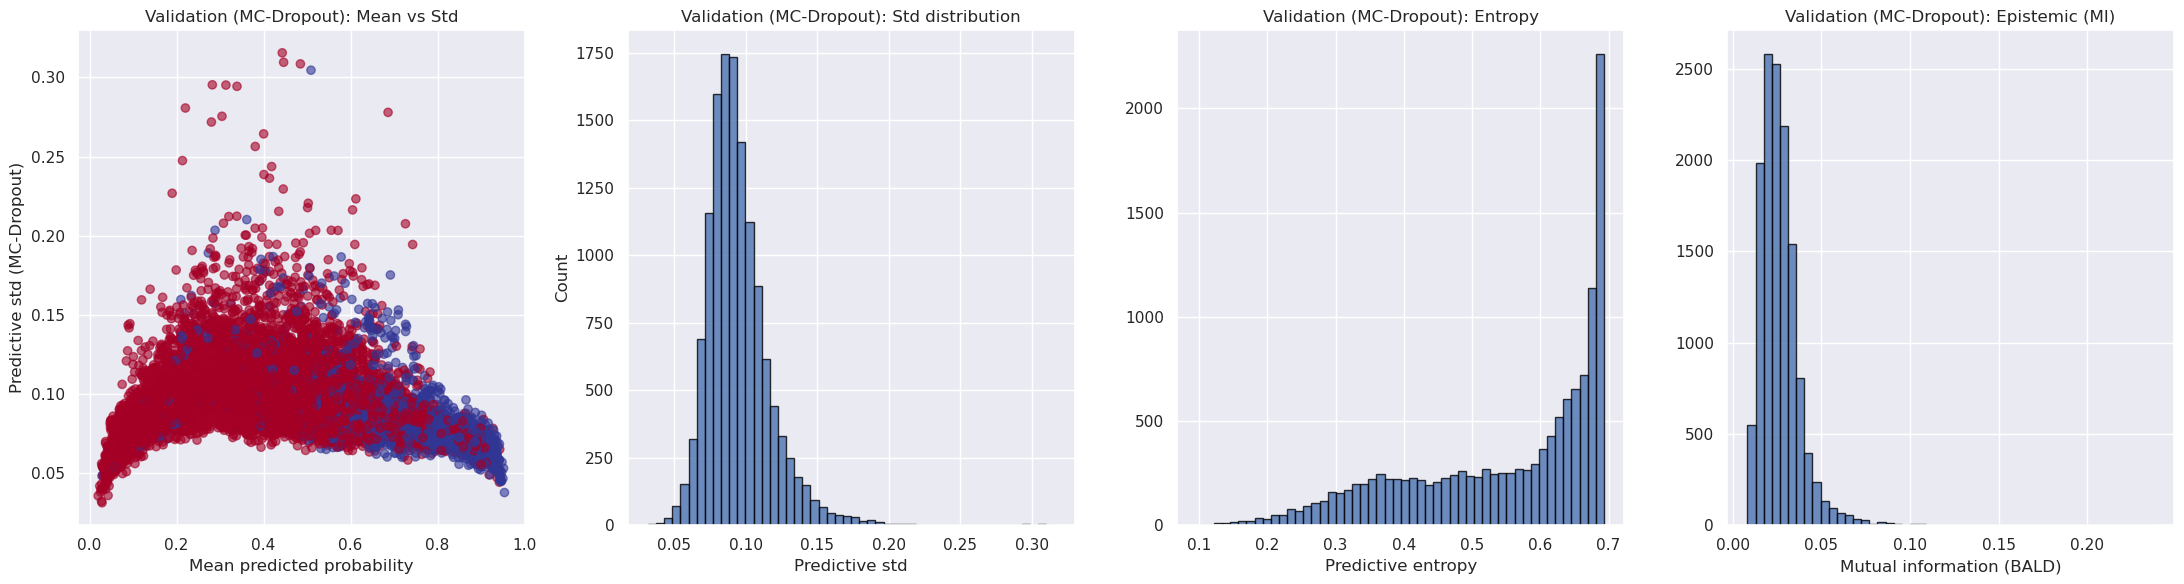

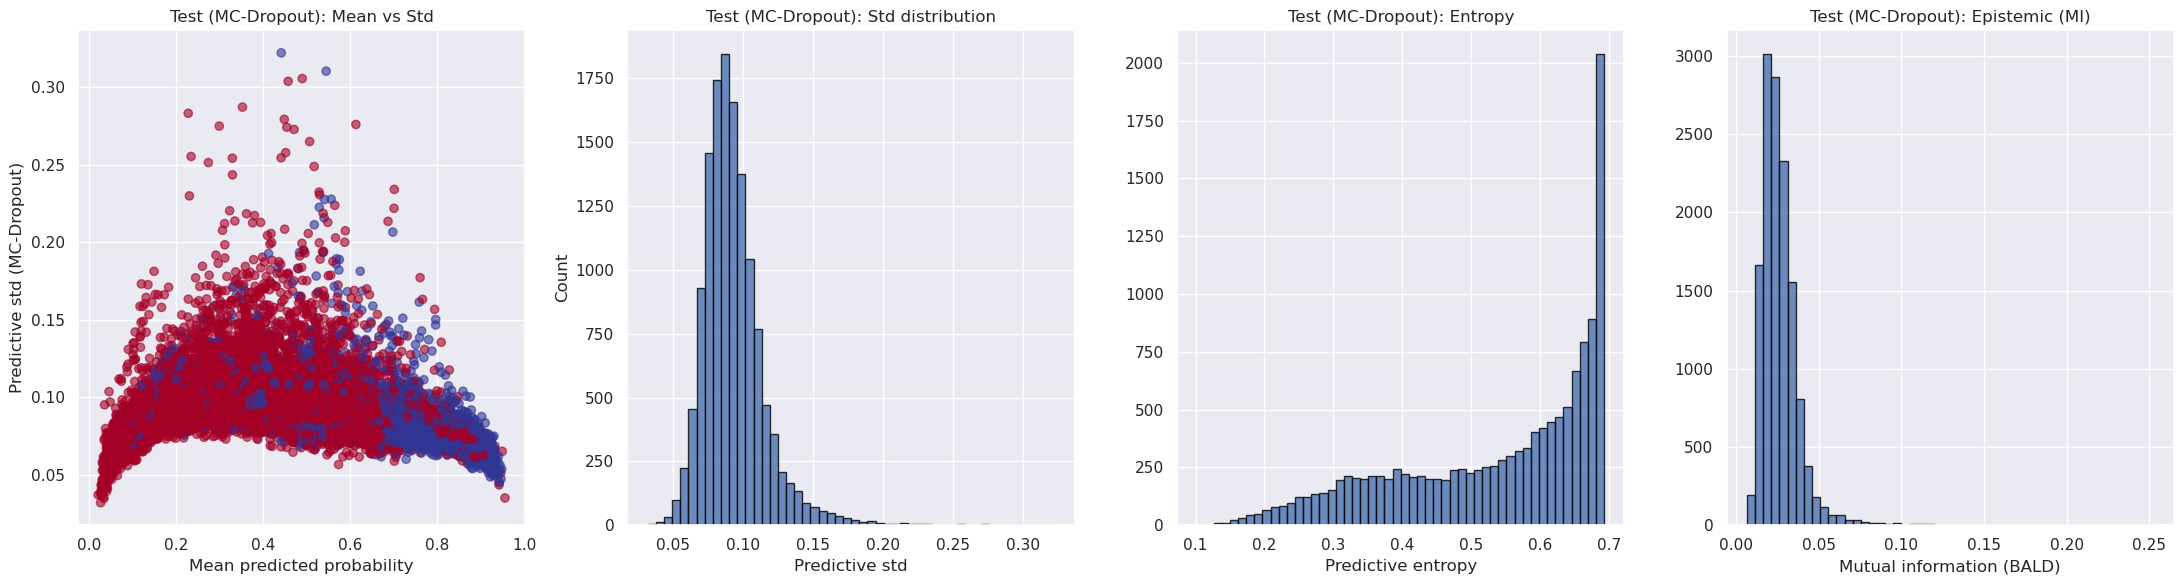


=== Training ensemble model 1/5 (seed=7) ===
Epoch     0 | Train Loss 1.1166 | Val Loss 1.0850 | Train ROC-AUC 0.444 | Val ROC-AUC 0.430 | Train PR-AUC 0.184 | Val PR-AUC 0.166
Epoch   200 | Train Loss 0.9072 | Val Loss 0.8530 | Train ROC-AUC 0.771 | Val ROC-AUC 0.792 | Train PR-AUC 0.492 | Val PR-AUC 0.532
Epoch   400 | Train Loss 0.8664 | Val Loss 0.8363 | Train ROC-AUC 0.795 | Val ROC-AUC 0.799 | Train PR-AUC 0.518 | Val PR-AUC 0.546
Epoch   600 | Train Loss 0.8410 | Val Loss 0.8280 | Train ROC-AUC 0.809 | Val ROC-AUC 0.808 | Train PR-AUC 0.538 | Val PR-AUC 0.555
Early stopping triggered.

=== Training ensemble model 2/5 (seed=42) ===
Epoch     0 | Train Loss 1.1696 | Val Loss 1.1324 | Train ROC-AUC 0.381 | Val ROC-AUC 0.356 | Train PR-AUC 0.164 | Val PR-AUC 0.151
Epoch   200 | Train Loss 0.9104 | Val Loss 0.8576 | Train ROC-AUC 0.769 | Val ROC-AUC 0.789 | Train PR-AUC 0.489 | Val PR-AUC 0.531
Epoch   400 | Train Loss 0.8727 | Val Loss 0.8389 | Train ROC-AUC 0.791 | Val ROC-AUC 0.7

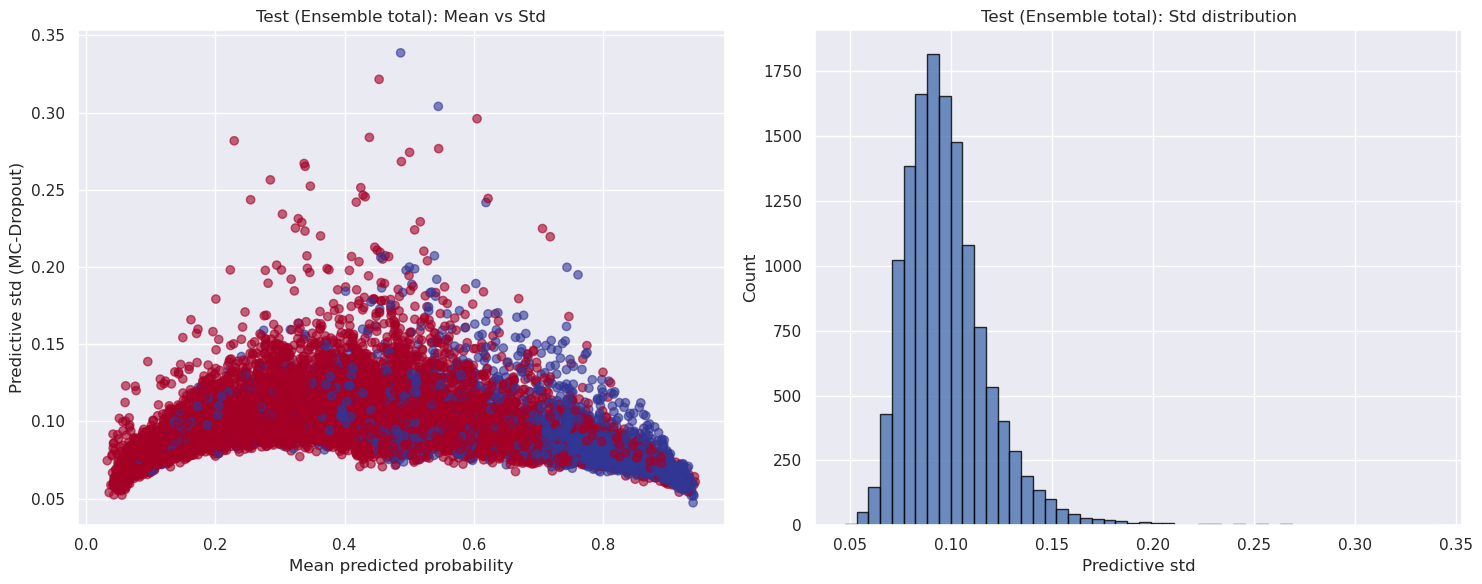


Summary:
- Best dropout rate (validation): 0.50
- MC-Dropout Test: std mean=0.0933, MI mean=0.026555
- Ensemble Test: total std mean=0.0978, epistemic std mean=0.0259, aleatoric std mean=0.0936


In [94]:

# ============================
# Deep ensemble with principled variance decomposition
# ============================
@torch.inference_mode()
def ensemble_predict_with_uncertainty(
    ensemble_models,
    graph,
    n_mc=50,
    edge_indices=None,
    node_indices=None
):
    """
    Law of total variance:
        total_var = E_m[Var(Y|m)] + Var_m(E[Y|m])
        aleatoric_var  = mean within-model variance from MC-Dropout
        epistemic_var  = variance across model means
    Returns mean_pred, total_std, epistemic_std, aleatoric_std (all as numpy arrays).
    """
    device_m = next(ensemble_models[0].parameters()).device
    x = graph.x.to(device_m)
    eidx = (edge_indices if edge_indices is not None else graph.edge_index).to(device_m)
    if node_indices is not None:
        node_indices = torch.as_tensor(node_indices, dtype=torch.long, device=device_m)

    model_means = []
    model_vars = []

    for mdl in ensemble_models:
        mc_probs = []
        for _ in range(n_mc):
            _set_dropout_train_only(mdl)
            logits = mdl(x, eidx)
            if node_indices is not None:
                logits = logits.index_select(0, node_indices)
            probs = torch.sigmoid(logits).detach()
            mc_probs.append(probs)
        mc_stack = torch.stack(mc_probs, dim=0)         # (T,N)
        model_means.append(mc_stack.mean(dim=0))        # (N,)
        model_vars.append(mc_stack.var(dim=0, unbiased=False))  # (N,)

    model_means = torch.stack(model_means, dim=0)  # (M,N)
    model_vars  = torch.stack(model_vars,  dim=0)  # (M,N)

    epistemic_var = model_means.var(dim=0, unbiased=False)  # Var_m(E[Y|m])
    aleatoric_var = model_vars.mean(dim=0)                  # E_m[Var(Y|m)]
    total_var = epistemic_var + aleatoric_var

    mean_pred = model_means.mean(dim=0)

    return (mean_pred.cpu().numpy(),
            torch.sqrt(total_var).cpu().numpy(),
            torch.sqrt(epistemic_var).cpu().numpy(),
            torch.sqrt(aleatoric_var).cpu().numpy())

# ============================
# Dropout tuning on validation set
# ============================
def tune_best_dropout(
    graph,
    train_indices,
    val_indices,
    val_edge_indices,
    pos_weights,
    candidate_dr=(0.3, 0.4, 0.5),
    seed=7,
    hidden_dim=100,
    max_epochs=4000,
    lr=2e-4,
    weight_decay=5e-5,
    patience=200,
    min_delta=0.005,
    log_every=100,
):
    """
    Train a model for each dropout rate and pick the best by validation ROC-AUC (tie-break by val loss).
    Returns: best_dr, best_model (CPU), records list
    """
    records = []
    best = None

    for dr in candidate_dr:
        print(f"\n=== Tuning: training with dropout_rate={dr:.2f} ===")
        model_dr, hist, val_metrics = train_one_model(
            graph=graph,
            train_indices=train_indices,
            val_indices=val_indices,
            val_edge_indices=val_edge_indices,
            pos_weights=pos_weights,
            hidden_dim=hidden_dim,
            dropout_rate=dr,
            seed=seed,
            max_epochs=max_epochs,
            lr=lr,
            weight_decay=weight_decay,
            patience=patience,
            min_delta=min_delta,
            log_every=log_every,
        )
        rec = {
            "dropout_rate": dr,
            "val_roc_auc": val_metrics["val_roc_auc"],
            "val_loss": val_metrics["val_loss"],
            "model": model_dr
        }
        records.append(rec)

        if best is None:
            best = rec
        else:
            if rec["val_roc_auc"] > best["val_roc_auc"] + 1e-6:
                best = rec
            elif abs(rec["val_roc_auc"] - best["val_roc_auc"]) <= 1e-6 and rec["val_loss"] < best["val_loss"]:
                best = rec

    print(f"\nBest dropout rate by validation ROC-AUC: {best['dropout_rate']:.2f} "
          f"(Val ROC-AUC={best['val_roc_auc']:.4f}, Val Loss={best['val_loss']:.4f})")
    return best["dropout_rate"], best["model"], records

# ============================
# Deep ensemble training (N models, different seeds)
# ============================
def train_deep_ensemble(
    graph,
    train_indices,
    val_indices,
    val_edge_indices,
    pos_weights,
    n_models=5,
    base_seed=7,
    hidden_dim=100,
    dropout_rate=0.4,
    max_epochs=4000,
    lr=2e-4,
    weight_decay=5e-5,
    patience=200,
    min_delta=0.005,
    log_every=200,
):
    """
    Train n_models copies with different seeds. Returns a list of CPU models.
    """
    seeds = [base_seed, 42, 123, 456, 789]
    if n_models > len(seeds):
        seeds = seeds + list(range(1000, 1000 + (n_models - len(seeds))))

    models = []
    for i in range(n_models):
        print(f"\n=== Training ensemble model {i+1}/{n_models} (seed={seeds[i]}) ===")
        mdl, _, _ = train_one_model(
            graph=graph,
            train_indices=train_indices,
            val_indices=val_indices,
            val_edge_indices=val_edge_indices,
            pos_weights=pos_weights,
            hidden_dim=hidden_dim,
            dropout_rate=dropout_rate,
            seed=seeds[i],
            max_epochs=max_epochs,
            lr=lr,
            weight_decay=weight_decay,
            patience=patience,
            min_delta=min_delta,
            log_every=log_every,
        )
        models.append(mdl.to(device))  # move to device for ensemble prediction
    return models

# ============================
# Confidence intervals for probabilities (clipped to [0,1])
# ============================
def calculate_confidence_intervals(mean_pred, std_pred, confidence_levels=(0.68, 0.95)):
    from scipy import stats
    mean_pred = np.asarray(mean_pred)
    std_pred  = np.asarray(std_pred)
    cis = {}
    for level in confidence_levels:
        z = stats.norm.ppf(0.5 + level/2.0)
        lower = np.clip(mean_pred - z * std_pred, 0.0, 1.0)
        upper = np.clip(mean_pred + z * std_pred, 0.0, 1.0)
        cis[f'{int(level*100)}%'] = {"lower": lower, "upper": upper}
    return cis

# ============================
# ======== RUN PIPELINE ======
# ============================

# 0) Ensure data on device (if not already)
present_maxent_pyg_graph = present_maxent_pyg_graph.to(device)
val_edge_indices = torch.as_tensor(val_edge_indices, dtype=torch.long, device=device)
test_edge_indices = torch.as_tensor(test_edge_indices, dtype=torch.long, device=device)
train_indices = torch.as_tensor(train_indices, dtype=torch.long, device=device)
val_indices = torch.as_tensor(val_indices, dtype=torch.long, device=device)
test_indices = torch.as_tensor(test_indices, dtype=torch.long, device=device)
pos_weights = pos_weights.to(device)

# 1) Tune dropout rate on validation set
best_dr, best_model_cpu, tuning_records = tune_best_dropout(
    graph=present_maxent_pyg_graph,
    train_indices=train_indices,
    val_indices=val_indices,
    val_edge_indices=val_edge_indices,
    pos_weights=pos_weights,
    candidate_dr=(0.3, 0.4, 0.5),
    hidden_dim=100,
    seed=7,
    max_epochs=4000,     # adjust for compute
    lr=2e-4,
    weight_decay=5e-5,
    patience=200,
    min_delta=0.005,
    log_every=100,
)

# Move best model back to device for inference
best_model = copy.deepcopy(best_model_cpu).to(device)

# 2) MC-Dropout on validation and test
mc_mean_val, mc_std_val, _, mc_H_val, mc_MI_val = monte_carlo_dropout_predict(
    model=best_model, graph=present_maxent_pyg_graph, n_samples=100,
    edge_indices=val_edge_indices, node_indices=val_indices
)
plot_uncertainty_analysis(
    mean_pred=mc_mean_val,
    std_pred=mc_std_val,
    true_labels=present_maxent_pyg_graph.y[val_indices].detach().cpu().numpy(),
    entropy=mc_H_val, mutual_info=mc_MI_val, title="Validation (MC-Dropout)"
)

mc_mean_test, mc_std_test, _, mc_H_test, mc_MI_test = monte_carlo_dropout_predict(
    model=best_model, graph=present_maxent_pyg_graph, n_samples=100,
    edge_indices=test_edge_indices, node_indices=test_indices
)
plot_uncertainty_analysis(
    mean_pred=mc_mean_test,
    std_pred=mc_std_test,
    true_labels=present_maxent_pyg_graph.y[test_indices].detach().cpu().numpy(),
    entropy=mc_H_test, mutual_info=mc_MI_test, title="Test (MC-Dropout)"
)

# Optional confidence intervals on test probabilities
cis_test = calculate_confidence_intervals(mc_mean_test, mc_std_test, confidence_levels=(0.68, 0.95))

# 3) Deep ensemble training using best_dr (optional; comment out if not needed)
n_ens = 5
ensemble_models = train_deep_ensemble(
    graph=present_maxent_pyg_graph,
    train_indices=train_indices,
    val_indices=val_indices,
    val_edge_indices=val_edge_indices,
    pos_weights=pos_weights,
    n_models=n_ens,
    base_seed=7,
    hidden_dim=100,
    dropout_rate=best_dr,        # use tuned dropout
    max_epochs=3000,             # can be shorter than the tuning runs
    lr=2e-4,
    weight_decay=5e-5,
    patience=150,
    min_delta=0.005,
    log_every=200,
)

# 4) Ensemble uncertainty on test set (total/epistemic/aleatoric)
ens_mean, ens_total_std, ens_epi_std, ens_ale_std = ensemble_predict_with_uncertainty(
    ensemble_models=ensemble_models,
    graph=present_maxent_pyg_graph,
    n_mc=50,
    edge_indices=test_edge_indices,
    node_indices=test_indices
)

# Quick plot of ensemble total uncertainty
plot_uncertainty_analysis(
    mean_pred=ens_mean,
    std_pred=ens_total_std,
    true_labels=present_maxent_pyg_graph.y[test_indices].detach().cpu().numpy(),
    title="Test (Ensemble total)"
)

print("\nSummary:")
print(f"- Best dropout rate (validation): {best_dr:.2f}")
print(f"- MC-Dropout Test: std mean={mc_std_test.mean():.4f}, MI mean={mc_MI_test.mean():.6f}")
print(f"- Ensemble Test: total std mean={ens_total_std.mean():.4f}, "
      f"epistemic std mean={ens_epi_std.mean():.4f}, aleatoric std mean={ens_ale_std.mean():.4f}")

In [95]:
# weighted loss function:
# most ML algorithms assume that the target labels are equally represented.
# However, our data is severly imbalanced, with the presence of wildfires being significantly lower 
# (< 20% of total observations) than no wildfires (> 80% total).
# common approaches to deal with imbalanced datasets = over or under sampling methods.
# however, we cannot employ these methods because we are using a graph neural network.
# i.e. our graph has a fixed structure. Removing or adding more instances will only mess this up.

# Therefore, we will employ a weighted loss function.
# code and the idea came from  Tantai (2023), 
# found at: https://medium.com/@zergtant/use-weighted-loss-function-to-solve-imbalanced-data-classification-problems-749237f38b75#:~:text=A%20weighted%20loss%20function%20assigns,improved%20performance%20on%20imbalanced%20datasets.


# first get the class labels
train_classes = present_maxent_sdf[present_maxent_sdf['block_id'].isin(train_block)]['modis_wf'].to_list()

# convert the list to a tensor so that it can be used by pyTorch's functions
train_classes = torch.tensor(train_classes)

# get the sum of the instances which have label = 1 ('fire') and 0 ('no fire')
fire = torch.sum(train_classes == 1).item()
no_fire = torch.sum(train_classes == 0).item()


# simple weight variable calculated by dividing the number of negative classes by the number of positive classes.
pos_weights = torch.tensor([no_fire/fire])

# pos_weights = torch.tensor([4.0])

print(pos_weights)


tensor([3.6899])


In [96]:
# our processing will be done on the gpu because this will significantly improve processing time. 
# check if the gpu is available - if it is, use it and if its not, use the cpu.
device =  "cuda" if torch.cuda.is_available() else "cpu"
#device = "cpu"
torch.backends.cudnn.benchmark = True
print(f'Device: {device}')

# lets put all our data on the GPU for processing:

# the model 
model = model.to(device)

# the graph of our AOI that we created earlier.
present_maxent_pyg_graph = present_maxent_pyg_graph.to(device)

# the train-test-validation indices so that we can seperate them during training:
train_indices = torch.tensor(train_indices, dtype=torch.long).to(device)
test_indices = torch.tensor(test_indices, dtype=torch.long).to(device)
val_indices = torch.tensor(val_indices, dtype=torch.long).to(device)

# the edge indices
val_edge_indices = torch.tensor(val_edge_indices, dtype=torch.long).to(device)
test_edge_indices = torch.tensor(test_edge_indices, dtype=torch.long).to(device)

# the weights for the weighted loss function.
pos_weights = pos_weights.to(device)


Device: cuda


/state/partition1/job-1034833/ipykernel_2040629/4093043876.py:17: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_indices = torch.tensor(train_indices, dtype=torch.long).to(device)
/state/partition1/job-1034833/ipykernel_2040629/4093043876.py:18: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  test_indices = torch.tensor(test_indices, dtype=torch.long).to(device)
/state/partition1/job-1034833/ipykernel_2040629/4093043876.py:19: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  val_indices = torch.tensor(val_indices, dtype=torch.long).to(dev

In [97]:
# initialize Optimizer with learning rate and decay 
optimizer = torch.optim.AdamW(model.parameters(),
                              lr=0.0002, # learning rate
                              weight_decay=5e-5) # weight decay - weight_decay=5e-4

# define loss function Binary cross entropy loss for binary classification problems.
# we will also input our weights for the class imbalance into the pos_weight argument.
criterion = torch.nn.BCEWithLogitsLoss(pos_weight=pos_weights) #

# empty list to contain all the loss.
losses = []

# define a function to calculate the accuracy:
def acc_func(y_pred, ys):
    
    # check which prediction is equal to the actual label and then obtain the sum
    correct = np.sum(y_pred == ys)
    
    # after that, divide the number of correct predictions by the total number of y class labels.
    acc = correct / ys.shape[0]
    
    return acc * 100

In [98]:
# early stopping:
# code by isle_of_gods (2022)
# found at https://stackoverflow.com/questions/71998978/early-stopping-in-pytorch

class EarlyStopper:
    
    def __init__(self, patience=1, min_delta=0):
        
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    
    def early_stop(self, validation_loss):
        
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            
            self.counter += 1
            
            if self.counter >= self.patience:
                return True
        
        return False

In [99]:
epochs = 10001

from sklearn.metrics import roc_auc_score, average_precision_score

train_loss_list = []
val_loss_list = []
count = []

train_roc_auc_list = []
val_roc_auc_list = []

train_pr_auc_list = []
val_pr_auc_list = []

# initialise the early stopper class
early_stopper = EarlyStopper(patience=100, min_delta=0.01)

In [100]:
# check and revise indices
def fix_training_indices(train_indices, num_nodes):
    # ensure that all the indices are in the bound
    valid_mask = (train_indices >= 0) & (train_indices < num_nodes)
    valid_indices = train_indices[valid_mask]
    
    print(f"Removed {len(train_indices) - len(valid_indices)} invalid indices")
    return valid_indices


num_nodes = present_maxent_pyg_graph.num_nodes
train_indices = fix_training_indices(train_indices, num_nodes)

Removed 0 invalid indices


In [101]:
def validate_before_training(model, graph, train_indices, device):
    """
    check everything before use with safer CUDA operations
    """
    print("\n=== Starting Pre-training Validation ===")
    is_valid = True

    # 1. 检查设备一致性 - 更安全的实现
    print("\n1. Checking device consistency:")
    try:
        model_device = next(model.parameters()).device
        graph_x_device = graph.x.device
        graph_edge_device = graph.edge_index.device
        indices_device = train_indices.device
        
        print(f"Model device: {model_device}")
        print(f"Graph x device: {graph_x_device}")
        print(f"Graph edge_index device: {graph_edge_device}")
        print(f"Train indices device: {indices_device}")
    except Exception as e:
        print(f"Error checking devices: {e}")
        is_valid = False

    # 2. 检查图的基本属性 - 避免直接访问CUDA属性
    print("\n2. Checking graph properties:")
    try:
        num_nodes = graph.x.size(0)  # 使用size而不是num_nodes
        num_edges = graph.edge_index.size(1)  # 使用size而不是num_edges
        print(f"Number of nodes: {num_nodes}")
        print(f"Number of edges: {num_edges}")
        print(f"Node features shape: {graph.x.shape}")
        print(f"Edge index shape: {graph.edge_index.shape}")
        print(f"Labels shape: {graph.y.shape}")
    except Exception as e:
        print(f"Error checking graph properties: {e}")
        is_valid = False

    # 3. 检查边索引的有效性 - 分批处理
    print("\n3. Checking edge indices:")
    try:
        edge_index = graph.edge_index.cpu()  # 移到CPU进行检查
        max_index = edge_index.max().item()
        min_index = edge_index.min().item()
        print(f"Edge index range: [{min_index}, {max_index}]")
        
        if min_index < 0:
            print("Error: Negative edge indices found")
            is_valid = False
        if max_index >= num_nodes:
            print("Error: Edge indices exceed number of nodes")
            is_valid = False
    except Exception as e:
        print(f"Error checking edge indices: {e}")
        is_valid = False

    # 4. 检查训练索引的有效性 - 移到CPU检查
    print("\n4. Checking training indices:")
    try:
        train_indices_cpu = train_indices.cpu()
        print(f"Number of training indices: {len(train_indices_cpu)}")
        print(f"Training indices range: [{train_indices_cpu.min().item()}, {train_indices_cpu.max().item()}]")
        
        if train_indices_cpu.max().item() >= num_nodes:
            print("Error: Training indices exceed number of nodes")
            is_valid = False
        if train_indices_cpu.min().item() < 0:
            print("Error: Negative training indices found")
            is_valid = False
    except Exception as e:
        print(f"Error checking training indices: {e}")
        is_valid = False

    # 5. 检查模型输入维度
    print("\n5. Checking model dimensions:")
    try:
        input_features = graph.x.size(1)  # 使用size而不是num_features
        print(f"Input features: {input_features}")
        print(f"Model's first layer input dimensions: {model.conv1.in_channels}")
    except Exception as e:
        print(f"Error checking model dimensions: {e}")
        is_valid = False

    # 6. 检查数据类型 - 不进行设备操作
    print("\n6. Checking data types:")
    try:
        print(f"Node features dtype: {graph.x.dtype}")
        print(f"Edge index dtype: {graph.edge_index.dtype}")
        print(f"Labels dtype: {graph.y.dtype}")
        print(f"Training indices dtype: {train_indices.dtype}")
    except Exception as e:
        print(f"Error checking data types: {e}")
        is_valid = False

    # 7. NaN
    print("\n7. Checking for NaN values:")
    try:
        
        batch_size = 10000
        has_nan_features = False
        has_nan_labels = False
        
        for i in range(0, graph.x.size(0), batch_size):
            end_idx = min(i + batch_size, graph.x.size(0))
            if torch.isnan(graph.x[i:end_idx]).any().item():
                has_nan_features = True
                break
                
        for i in range(0, graph.y.size(0), batch_size):
            end_idx = min(i + batch_size, graph.y.size(0))
            if torch.isnan(graph.y[i:end_idx]).any().item():
                has_nan_labels = True
                break
        
        print(f"NaN in features: {has_nan_features}")
        print(f"NaN in labels: {has_nan_labels}")
        
        if has_nan_features or has_nan_labels:
            print("Error: NaN values found in data")
            is_valid = False
    except Exception as e:
        print(f"Error checking NaN values: {e}")
        is_valid = False

    # 总结
    print("\n=== Validation Summary ===")
    if is_valid:
        print("All checks passed! The model and data are ready for training.")
    else:
        print("Some checks failed. Please review the warnings and errors above.")

    return is_valid

In [102]:
try:
    valid = validate_before_training(model, present_maxent_pyg_graph, train_indices, device)
    if not valid:
        print("Please fix the issues before proceeding with training")
        exit()
except Exception as e:
    print(f"Critical error during validation: {e}")
    exit()


=== Starting Pre-training Validation ===

1. Checking device consistency:
Model device: cuda:0
Graph x device: cuda:0
Graph edge_index device: cuda:0
Train indices device: cuda:0

2. Checking graph properties:
Number of nodes: 88760
Number of edges: 702960
Node features shape: torch.Size([88760, 18])
Edge index shape: torch.Size([2, 702960])
Labels shape: torch.Size([88760])

3. Checking edge indices:
Edge index range: [0, 88759]

4. Checking training indices:
Number of training indices: 62060
Training indices range: [0, 88759]

5. Checking model dimensions:
Input features: 18
Model's first layer input dimensions: 18

6. Checking data types:
Node features dtype: torch.float32
Edge index dtype: torch.int64
Labels dtype: torch.float32
Training indices dtype: torch.int64

7. Checking for NaN values:
NaN in features: False
NaN in labels: False

=== Validation Summary ===
All checks passed! The model and data are ready for training.


In [103]:
# TRAINING LOOP:
for e in range(epochs):
  
    # Go into training mode.
    model.train()

    # Step 1: forward pass.
    
    logits_train = model(present_maxent_pyg_graph.x, present_maxent_pyg_graph.edge_index).squeeze()[train_indices]
    train_ys_prob = torch.sigmoid(logits_train)  # Probabilities for ROC-AUC

    # Step 2: calculate loss and accuracy
    train_loss = criterion(logits_train, present_maxent_pyg_graph.y[train_indices].float()) # upgraded to weighted loss

    # Calculate train roc-auc and pr-auc
    train_roc_auc = roc_auc_score(present_maxent_pyg_graph.y[train_indices].cpu().numpy(), train_ys_prob.cpu().detach().numpy())
    train_pr_auc = average_precision_score(present_maxent_pyg_graph.y[train_indices].cpu().numpy(), train_ys_prob.cpu().detach().numpy())
    
    # Step 3: optimizer zero gradient.
    optimizer.zero_grad()

    # Step 4: loss back-propagation.
    train_loss.backward()
    
    # Step 5: optimizer step.
    optimizer.step()

    # Step 6: model evaluation on validation set.
    model.eval()
    
    with torch.no_grad():
        
        logits_val = model(present_maxent_pyg_graph.x, val_edge_indices).squeeze()[val_indices]
        val_ys_prob = torch.sigmoid(logits_val) # use the sigmoid function to calculate probabilities

        # calculate loss
        val_loss = criterion(logits_val, present_maxent_pyg_graph.y[val_indices].float())

        # Calculate validation ROC-AUC and PR-AUC
        val_roc_auc = roc_auc_score(present_maxent_pyg_graph.y[val_indices].cpu().numpy(), val_ys_prob.cpu().detach().numpy())
        val_pr_auc = average_precision_score(present_maxent_pyg_graph.y[val_indices].cpu().numpy(), val_ys_prob.cpu().detach().numpy())
        
        # break out of the training loop if the early stopper has been triggered after the validation loss has been calculated.
        if early_stopper.early_stop(val_loss.cpu().detach().numpy()):
                
            print("\nEarly stopping triggered!\n")
                
            break
            
        # print message:
        if e % 10 == 0:
            print(f"\nEpoch ({e}/{epochs})")
            print(f"Training set:     Loss {train_loss:.5f}  |  ROC-AUC: {train_roc_auc:.2f} |  PR-AUC: {train_pr_auc:.2f}")
            print(f"Validation set:   Loss {val_loss:.5f} |  ROC-AUC: {val_roc_auc:.2f} |  PR-AUC: {val_pr_auc:.2f}")
            
    # for plotting
    count.append(e) # storing the epoch 
    
    train_loss_list.append(train_loss.cpu().detach().numpy())
    train_roc_auc_list.append(train_roc_auc)
    train_pr_auc_list.append(train_pr_auc)
    
    val_loss_list.append(val_loss.cpu().detach().numpy())
    val_roc_auc_list.append(val_roc_auc)
    val_pr_auc_list.append(val_pr_auc)


Epoch (0/10001)
Training set:     Loss 1.12093  |  ROC-AUC: 0.51 |  PR-AUC: 0.22
Validation set:   Loss 1.09504 |  ROC-AUC: 0.59 |  PR-AUC: 0.26

Epoch (10/10001)
Training set:     Loss 1.07423  |  ROC-AUC: 0.65 |  PR-AUC: 0.31
Validation set:   Loss 1.04834 |  ROC-AUC: 0.74 |  PR-AUC: 0.38

Epoch (20/10001)
Training set:     Loss 1.03828  |  ROC-AUC: 0.69 |  PR-AUC: 0.35
Validation set:   Loss 1.01198 |  ROC-AUC: 0.73 |  PR-AUC: 0.39

Epoch (30/10001)
Training set:     Loss 1.01593  |  ROC-AUC: 0.70 |  PR-AUC: 0.36
Validation set:   Loss 0.98203 |  ROC-AUC: 0.74 |  PR-AUC: 0.42

Epoch (40/10001)
Training set:     Loss 0.99421  |  ROC-AUC: 0.72 |  PR-AUC: 0.39
Validation set:   Loss 0.95584 |  ROC-AUC: 0.75 |  PR-AUC: 0.44

Epoch (50/10001)
Training set:     Loss 0.97467  |  ROC-AUC: 0.73 |  PR-AUC: 0.42
Validation set:   Loss 0.93276 |  ROC-AUC: 0.76 |  PR-AUC: 0.46

Epoch (60/10001)
Training set:     Loss 0.96249  |  ROC-AUC: 0.74 |  PR-AUC: 0.43
Validation set:   Loss 0.91384 |  RO

In [104]:
import glob

def save_shapefile(gdf, path, driver="ESRI Shapefile"):
    """
    Save a GeoDataFrame to a shapefile, ensuring the directory exists and no overwrite conflicts.

    Parameters:
    - gdf: GeoDataFrame to save.
    - path: Path to the shapefile (including .shp extension).
    - driver: File format driver (default: "ESRI Shapefile").
    """
    try:
        # Ensure the output directory exists
        output_dir = os.path.dirname(path)
        if not os.path.exists(output_dir):
            print(f"Directory {output_dir} does not exist. Creating it.")
            os.makedirs(output_dir, exist_ok=True)
        else:
            print(f"Directory {output_dir} already exists.")

        # Remove existing shapefile components if they exist
        base_name = os.path.splitext(path)[0]
        related_files = glob.glob(f"{base_name}.*")
        for file in related_files:
            print(f"Removing existing file: {file}")
            os.remove(file)

        # Save the new shapefile
        print(f"Saving new shapefile to: {path}")
        gdf.to_file(path, driver=driver)
        print(f"Shapefile saved successfully at: {path}")

    except Exception as e:
        print(f"Error saving shapefile: {e}")

Text(0.5, 0, 'Epoch number')

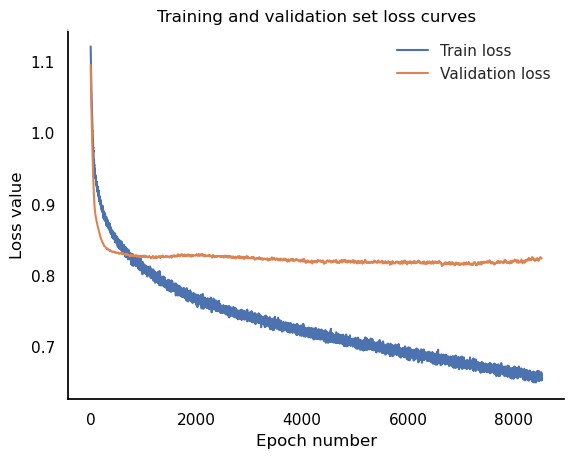

In [105]:
fig, ax = plt.subplots()
fig.patch.set_facecolor('none')  # Set the figure background to none
ax.set_facecolor('none')         # Set the axis background to none

# Keep the x and y axes
ax.spines['bottom'].set_color('black')  # x-axis spine color
ax.spines['left'].set_color('black')    # y-axis spine color
ax.tick_params(axis='x', colors='black')  # x-axis ticks
ax.tick_params(axis='y', colors='black')  # y-axis ticks

# Plotting the loss curves
plt.plot(count, train_loss_list, label="Train loss")
plt.plot(count, val_loss_list, label="Validation loss")

# Customize legend to remove background and border
legend = plt.legend()
legend.get_frame().set_facecolor('none')  # Remove legend background color
legend.get_frame().set_edgecolor('none')  # Remove legend border

# Add titles and labels with axis colors
plt.title("Training and validation set loss curves", color='black')  # Title color
plt.ylabel("Loss value", color='black')  # y-axis label color
plt.xlabel("Epoch number", color='black')  # x-axis label color


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


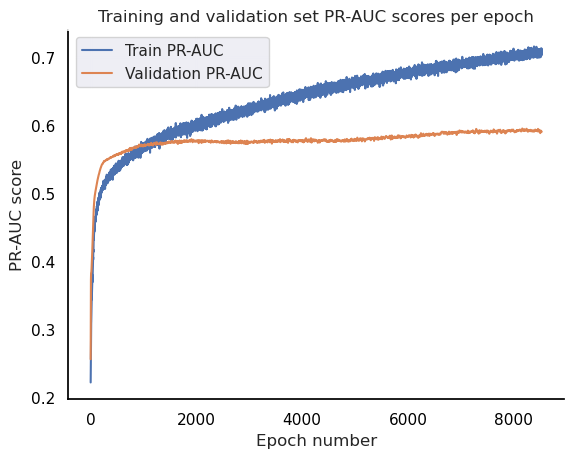

In [106]:
# plotting the loss curves:
fig, ax = plt.subplots()
fig.patch.set_facecolor('none')  # Set the figure background to none
ax.set_facecolor('none')         # Set the axis background to none

# Keep the x and y axes
ax.spines['bottom'].set_color('black')  # x-axis spine color
ax.spines['left'].set_color('black')    # y-axis spine color
ax.tick_params(axis='x', colors='black')  # x-axis ticks
ax.tick_params(axis='y', colors='black')  # y-axis ticks
# Customize legend to remove background and border
legend = plt.legend()
legend.get_frame().set_facecolor('none')  # Remove legend background color
legend.get_frame().set_edgecolor('none')  # Remove legend border
plt.plot(count, train_pr_auc_list, label="Train PR-AUC")
plt.plot(count, val_pr_auc_list, label="Validation PR-AUC")
plt.title("Training and validation set PR-AUC scores per epoch")
plt.ylabel("PR-AUC score")
plt.xlabel("Epoch number")
plt.legend();

In [107]:
def ROC_AUC_plot(val_true, val_pp):
    from sklearn.metrics import roc_curve, auc
    import matplotlib.pyplot as plt

    # Compute ROC curve and ROC area
    FPR, TPR, thresholds = roc_curve(val_true, val_pp)
    roc_auc = auc(FPR, TPR)

    # Create figure and axis with transparent background
    fig, ax = plt.subplots()
    fig.patch.set_facecolor('none')  # Set figure background to none
    ax.set_facecolor('none')         # Set axis background to none

    # Keep x and y axis visible
    ax.spines['bottom'].set_color('black')  # x-axis spine color
    ax.spines['left'].set_color('black')    # y-axis spine color
    ax.tick_params(axis='x', colors='black')  # x-axis ticks
    ax.tick_params(axis='y', colors='black')  # y-axis ticks

    # Plot ROC curve
    ax.plot(FPR, TPR, lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    ax.plot([0, 1], [0, 1], lw=2, linestyle='--')  # Diagonal line

    # Set axis limits and labels
    ax.set_xlim([0.0, 1.0])
    ax.set_ylim([0.0, 1.05])
    ax.set_xlabel('False Positive Rate', color='black')
    ax.set_ylabel('True Positive Rate', color='black')
    ax.set_title('Receiver Operating Characteristic (ROC) Curve', color='black')

    # Customize legend to remove background and border
    legend = ax.legend(loc="lower right")
    legend.get_frame().set_facecolor('none')  # Remove legend background color
    legend.get_frame().set_edgecolor('none')  # Remove legend border

    # Show the plot
    plt.show()

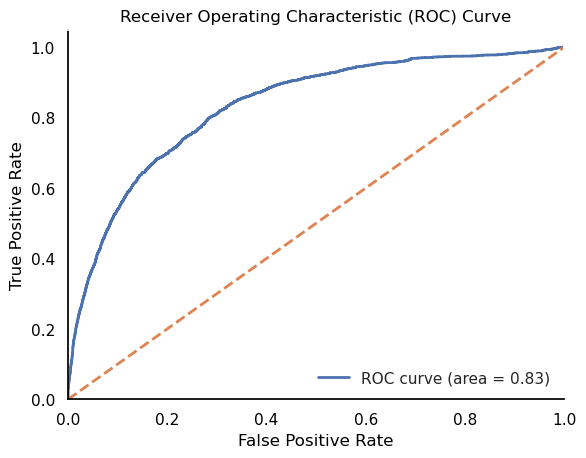

In [108]:
# plot the ROC-AUC for our validation set to determine the threshold
# first put the data on the cpu because it'll spit out an error saying numpy doesn't work on the GPU.
if isinstance(val_ys_prob, torch.Tensor):
    val_ys_prob = val_ys_prob.cpu().detach().numpy()

# Ground truth
val_true = present_maxent_pyg_graph.y[val_indices].cpu()

# Plot the ROC-AUC
ROC_AUC_plot(val_true, val_ys_prob)

In [109]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(val_true, val_ys_prob)
J = tpr - fpr
ix = J.argmax()
best_thresh = thresholds[ix]
print('最优阈值（Youden’s J）:', best_thresh)

最优阈值（Youden’s J）: 0.40681916


In [110]:
# further evaluation:

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

def evaluation_metrics_calculator(true, pred):
    
    # Precision
    precision = precision_score(true, pred)
    print(f"\nPrecision: {precision:.4f}")

    # Recall
    recall = recall_score(true, pred)
    print(f"Recall: {recall:.4f}")
    
    # lets get the specificity
    TN, FP, FN, TP = confusion_matrix(true, pred).ravel()
    specificity = TN / (TN + FP)
    print(f"Specificity: {specificity:.4f}")

    # F1 Score
    f1 = f1_score(true, pred)
    print(f"\nF1 Score: {f1:.4f}")

    # Confusion Matrix as percentages

    conf_matrix = confusion_matrix(true, pred)
    
    # convert he matrix to type float and then find the sum across each row.
    # because remember each row represents a class label and the sum of the values across each row = sum of observations 
    # for that class.
    conf_matrix_perc = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
    conf_matrix_perc = conf_matrix_perc * 100
    
    
    print("\nConfusion Matrix:")
    
    # visualize the confusion matrix

    schematic = ConfusionMatrixDisplay(confusion_matrix=conf_matrix_perc, 
                                       display_labels=[0, 1])
    
    fig, ax = plt.subplots()
    schematic.plot(cmap=plt.cm.Greens, ax=ax)
    
    for text in ax.texts:
        text.set_size(20)
    
    # adjust font size 
    ax.set_xlabel('Predicted label', fontsize=16)
    ax.set_ylabel('True label', fontsize=16)

    ax.tick_params(axis='both', which='major', labelsize=16)
    
    plt.show()



In [111]:
def binarize(prob_array, threshold):
    
    # Convert probabilities to binary predictions based on the threshold
    binary_prediction = (prob_array > threshold).astype(int)
    
    return binary_prediction


/state/partition1/job-1034833/ipykernel_2040629/2693227491.py:4: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  train_ys_prob = torch.tensor(train_ys_prob).clone().detach().cpu().numpy()


Train set evaluation:

ROC-AUC: 0.8892188933183065

Accuracy of train set : 74.70

Precision: 0.4523
Recall: 0.8922
Specificity: 0.7078

F1 Score: 0.6003

Confusion Matrix:


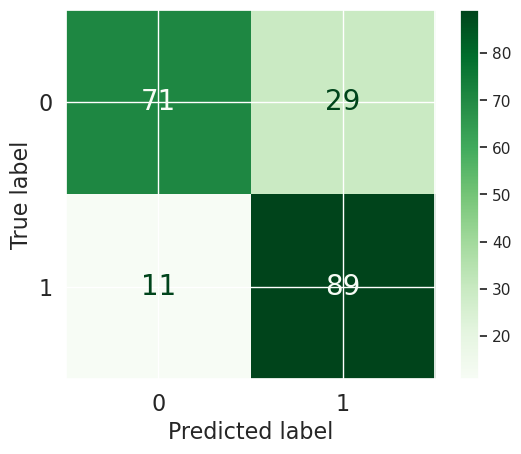

In [112]:
# evaluation on training set:
# first put the data on the cpu because it'll spit out an error saying numpy doesn't work on the GPU.

train_ys_prob = torch.tensor(train_ys_prob).clone().detach().cpu().numpy()
train_ys_pred = binarize(train_ys_prob, 0.4)   # because the true predictions are attached to the gradient
train_true = present_maxent_pyg_graph.y[train_indices].cpu().numpy()

# calculate accuracy
train_acc = acc_func(train_ys_pred, train_true)


print("Train set evaluation:\n")

print (f"ROC-AUC: {train_roc_auc}")

print(f"\nAccuracy of train set : {train_acc:.2f}")

evaluation_metrics_calculator(true = train_true, 
                              pred = train_ys_pred)


Validation set evaluation:

ROC-AUC: 0.8328331663797993

Accuracy of validation set : 72.78

Precision: 0.4130
Recall: 0.8049
Specificity: 0.7081

F1 Score: 0.5459

Confusion Matrix:


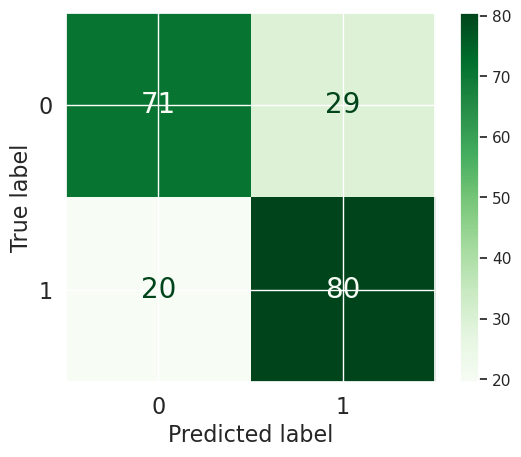

In [113]:

# evaluation on validation set:

val_ys_pred = binarize(val_ys_prob, 0.4)

val_true = present_maxent_pyg_graph.y[val_indices].cpu().numpy()

# compute accuracy:
val_acc = acc_func(val_ys_pred, val_true)

print("Validation set evaluation:\n")

print (f"ROC-AUC: {val_roc_auc}")

print(f"\nAccuracy of validation set : {val_acc:.2f}")

evaluation_metrics_calculator(true = val_true , 
                              pred = val_ys_pred)

ROC-AUC: 0.848681472605977
Test set evaluation:

Accuracy of test set : 73.18

Precision: 0.4517
Recall: 0.8276
Specificity: 0.7036

F1 Score: 0.5844

Confusion Matrix:


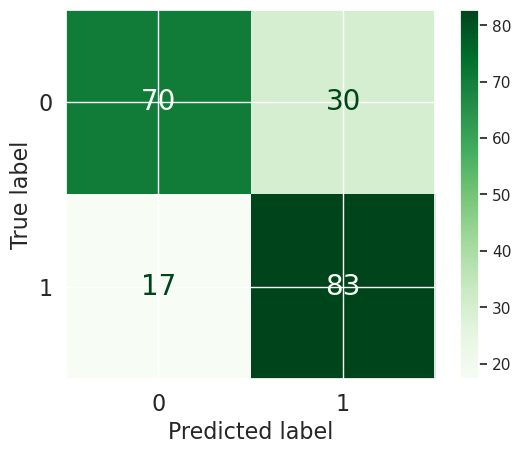

In [114]:

# test set:

# set your model to evaluation mode
model.eval()

# make predictions on your new data using your loaded model

with torch.no_grad():
    
    logits_test = model(present_maxent_pyg_graph.x, test_edge_indices).squeeze()[test_indices]
    test_ys_prob = torch.sigmoid(logits_test) # use the sigmoid function to calculate probabilities

        
    # Calculate validation roc-auc
    test_roc_auc = roc_auc_score(present_maxent_pyg_graph.y[test_indices].cpu().numpy(), test_ys_prob.cpu().detach().numpy())
    test_pr_auc = average_precision_score(present_maxent_pyg_graph.y[test_indices].cpu().numpy(), test_ys_prob.cpu().detach().numpy())
        
# convert the predictions tensor to a numpy array

print (f"ROC-AUC: {test_roc_auc}")
test_ys_prob = test_ys_prob.cpu().detach().numpy()
test_ys_pred = binarize(test_ys_prob, 0.4)
test_true = present_maxent_pyg_graph.y[test_indices].cpu().numpy()


# calculate accuracy
test_acc = acc_func(test_ys_pred, test_true)

print("Test set evaluation:")

print(f"\nAccuracy of test set : {test_acc:.2f}")

evaluation_metrics_calculator(true = test_true, 
                              pred = test_ys_pred)




In [115]:
# USING CURRET DATA TO OBSERVE FIRE TRENDS

model.eval()  

with torch.no_grad(): 
    
    # calculate the logits
    logits_new = model(present_maxent_pyg_graph.x, present_maxent_pyg_graph.edge_index).squeeze()
    
    # convert the logits to probabilities - this will be intrepreted as prediction probabilities for wildfire susceptibility
    prediction_probabilities = torch.sigmoid(logits_new).cpu().numpy()
    


In [116]:
print(len(prediction_probabilities))

88760


In [117]:
# USING CURRET DATA TO OBSERVE FIRE TRENDS (bascially just inputting all the data into the trained model)

model.eval()  

with torch.no_grad(): 
    
    # calculate the logits
    logits_new = model(present_maxent_pyg_graph.x, present_maxent_pyg_graph.edge_index).squeeze()
    
    # convert the logits to probabilities - this will be intrepreted as prediction probabilities for wildfire susceptibility
    prediction_probabilities = torch.sigmoid(logits_new).cpu().numpy()
    


In [118]:
def Remapper(pred_prob, dataframe):
    df_pred = pd.DataFrame({
        'id': [present_id_map[i] for i in range(len(prediction_probabilities))],
        'probability': prediction_probabilities
    })
   
    
    # # Merge the probabilities into the duplicated dataframe
    # final = duplicated_df.merge(df_pred, on='id', how='left')
    
    # # Plot the original visualization
    # fig, ax = plt.subplots(figsize=(20, 20))
    # final.plot(
    #     ax=ax,
    #     legend=True,
    #     column='probability',
    #     cmap='RdYlGn_r'
    # )
    # plt.show()
    
    # Create a fine-detailed visualization
    duplicated_df = dataframe.copy()
    fine_detailed_final = duplicated_df.merge(df_pred, on='id', how='left')
    
    fig, ax = plt.subplots(figsize=(20, 20))
    fig.patch.set_facecolor('none')
    ax.set_facecolor('none')
    
    # Customize the axes
    ax.spines['bottom'].set_color('black')  # Bottom spine
    ax.spines['left'].set_color('black')    # Left spine
    ax.axis('off')
    
    # Plot the fine-detailed visualization
    fine_detailed_final.plot(
        ax=ax,
        column='probability',
        legend=True,
        alpha=0.9,
        edgecolor='none',
        cmap='RdYlGn_r'
    )
    
    # Set the title for the fine-detailed plot
    ax.set_title("Current Wildfire Susceptibility", fontsize=20)
    plt.show()
    
    # Return both the original and fine-detailed DataFrames
    return fine_detailed_final

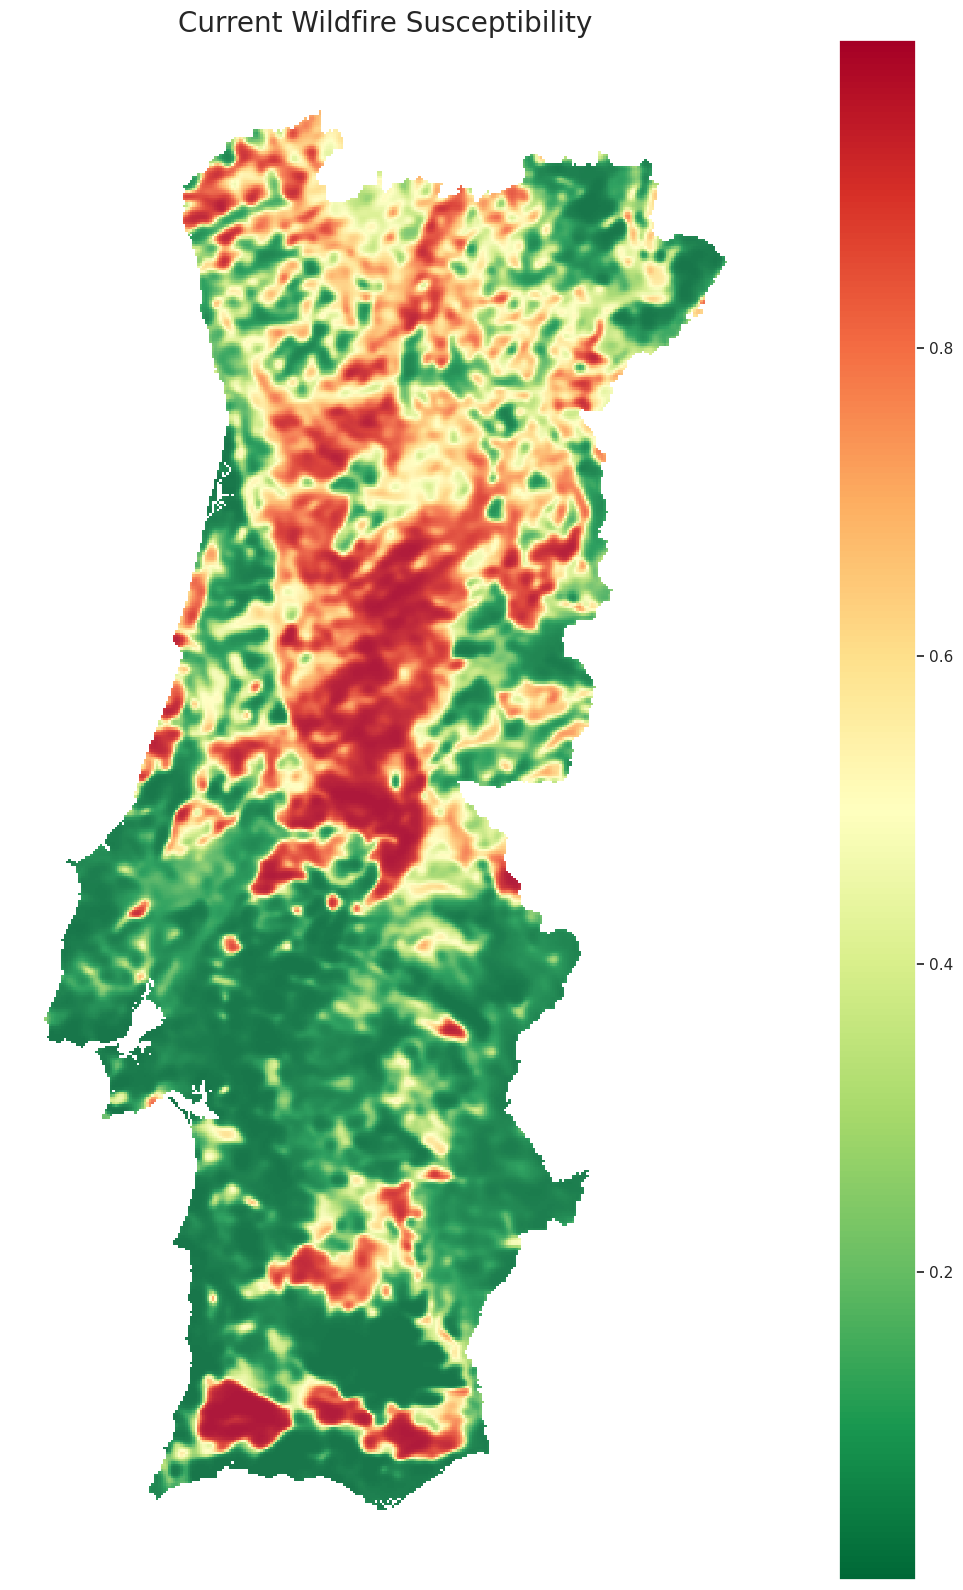

In [119]:
current_susceptibility = Remapper(prediction_probabilities,present_maxent_sdf_dup)

In [120]:
current_susceptibility

id       hurs        pr   sfcWind        tas     tasmax     tasmin  \
0          0  75.291946  2.065749  4.023667  18.056183  23.885965  12.226403   
1          1  75.253838  2.062917  4.020584  18.011454  23.842161  12.180749   
2          2  75.400543  2.078799  4.064763  18.217747  23.975496  12.459999   
3          3  75.354340  2.074121  4.052947  18.154991  23.931211  12.378773   
4          4  75.308128  2.069443  4.041131  18.092236  23.886927  12.297546   
...      ...        ...       ...       ...        ...        ...        ...   
88756  88756  65.967583  0.655851  3.879901  23.073225  28.664127  17.482327   
88757  88757  66.304100  0.658734  3.937026  22.798132  28.258600  17.337667   
88758  88758  66.249931  0.658295  3.927784  22.850080  28.334303  17.365858   
88759  88759  66.195763  0.657857  3.918541  22.902027  28.410006  17.394049   
88760  88760  66.141594  0.657418  3.909299  22.953974  28.485710  17.422239   

              DEM      slope       river  ...  Eclypts  Pnspnst  Pinuspn  \
0       82.986618  14.933476   74.257401  ...      0.0      1.0      0.0   
1      204.336868  16.949665  318.608276  ...      0.0      1.0      0.0   
2      159.530380  12.910676  513.545715  ...      1.0      1.0      0.0   
3      145.060379  17.142456  358.473694  ...      0.0      1.0      0.0   
4      123.798340  16.550346  152.072922  ...      0.0      1.0      0.0   
...           ...        ...         ...  ...      ...      ...      ...   
88756    2.545327   1.853419  696.071777  ...      0.0      0.0      0.0   
88757    1.099293   1.207141  215.039566  ...      0.0      0.0      0.0   
88758    1.197518   1.603551  231.404037  ...      0.0      0.0      0.0   
88759    1.623115   1.331315  227.402740  ...      0.0      0.0      0.0   
88760    1.982349   1.290080  215.649963  ...      0.0      0.0      0.0   

       Qrcsrtn  Qrcssbr  modis_wf  \
0          0.0      0.0       0.0   
1          0.0      0.0       0.0   
2          0.0      0.0       0.0   
3          0.0      0.0       0.0   
4          0.0      0.0       0.0   
...        ...      ...       ...   
88756      0.0      0.0       0.0   
88757      0.0      0.0       0.0   
88758      0.0      0.0       0.0   
88759      0.0      0.0       0.0   
88760      0.0      0.0       0.0   

                                                geometry  aspect_sin  \
0      POLYGON ((194175.268 576088.229, 195175.268 57...    0.411631   
1      POLYGON ((194175.268 575088.229, 195175.268 57...    0.743156   
2      POLYGON ((190175.268 574088.229, 191175.268 57...    0.796179   
3      POLYGON ((191175.268 574088.229, 192175.268 57...    0.960941   
4      POLYGON ((192175.268 574088.229, 193175.268 57...    0.590976   
...                                                  ...         ...   
88756  POLYGON ((224175.268 2088.229, 225175.268 2088...    0.911699   
88757  POLYGON ((218175.268 1088.229, 219175.268 1088...    0.986568   
88758  POLYGON ((219175.268 1088.229, 220175.268 1088...    0.512003   
88759  POLYGON ((220175.268 1088.229, 221175.268 1088...    0.301694   
88760  POLYGON ((221175.268 1088.229, 222175.268 1088...    0.612106   

      aspect_cos  probability  
0      -0.911351     0.686704  
1      -0.669118     0.692404  
2      -0.605061     0.735437  
3      -0.276754     0.742142  
4      -0.806689     0.704917  
...          ...          ...  
88756  -0.410859     0.031222  
88757  -0.163352     0.032098  
88758  -0.858984     0.018485  
88759  -0.953405     0.021486  
88760  -0.790775     0.036501  

[88761 rows x 22 columns]

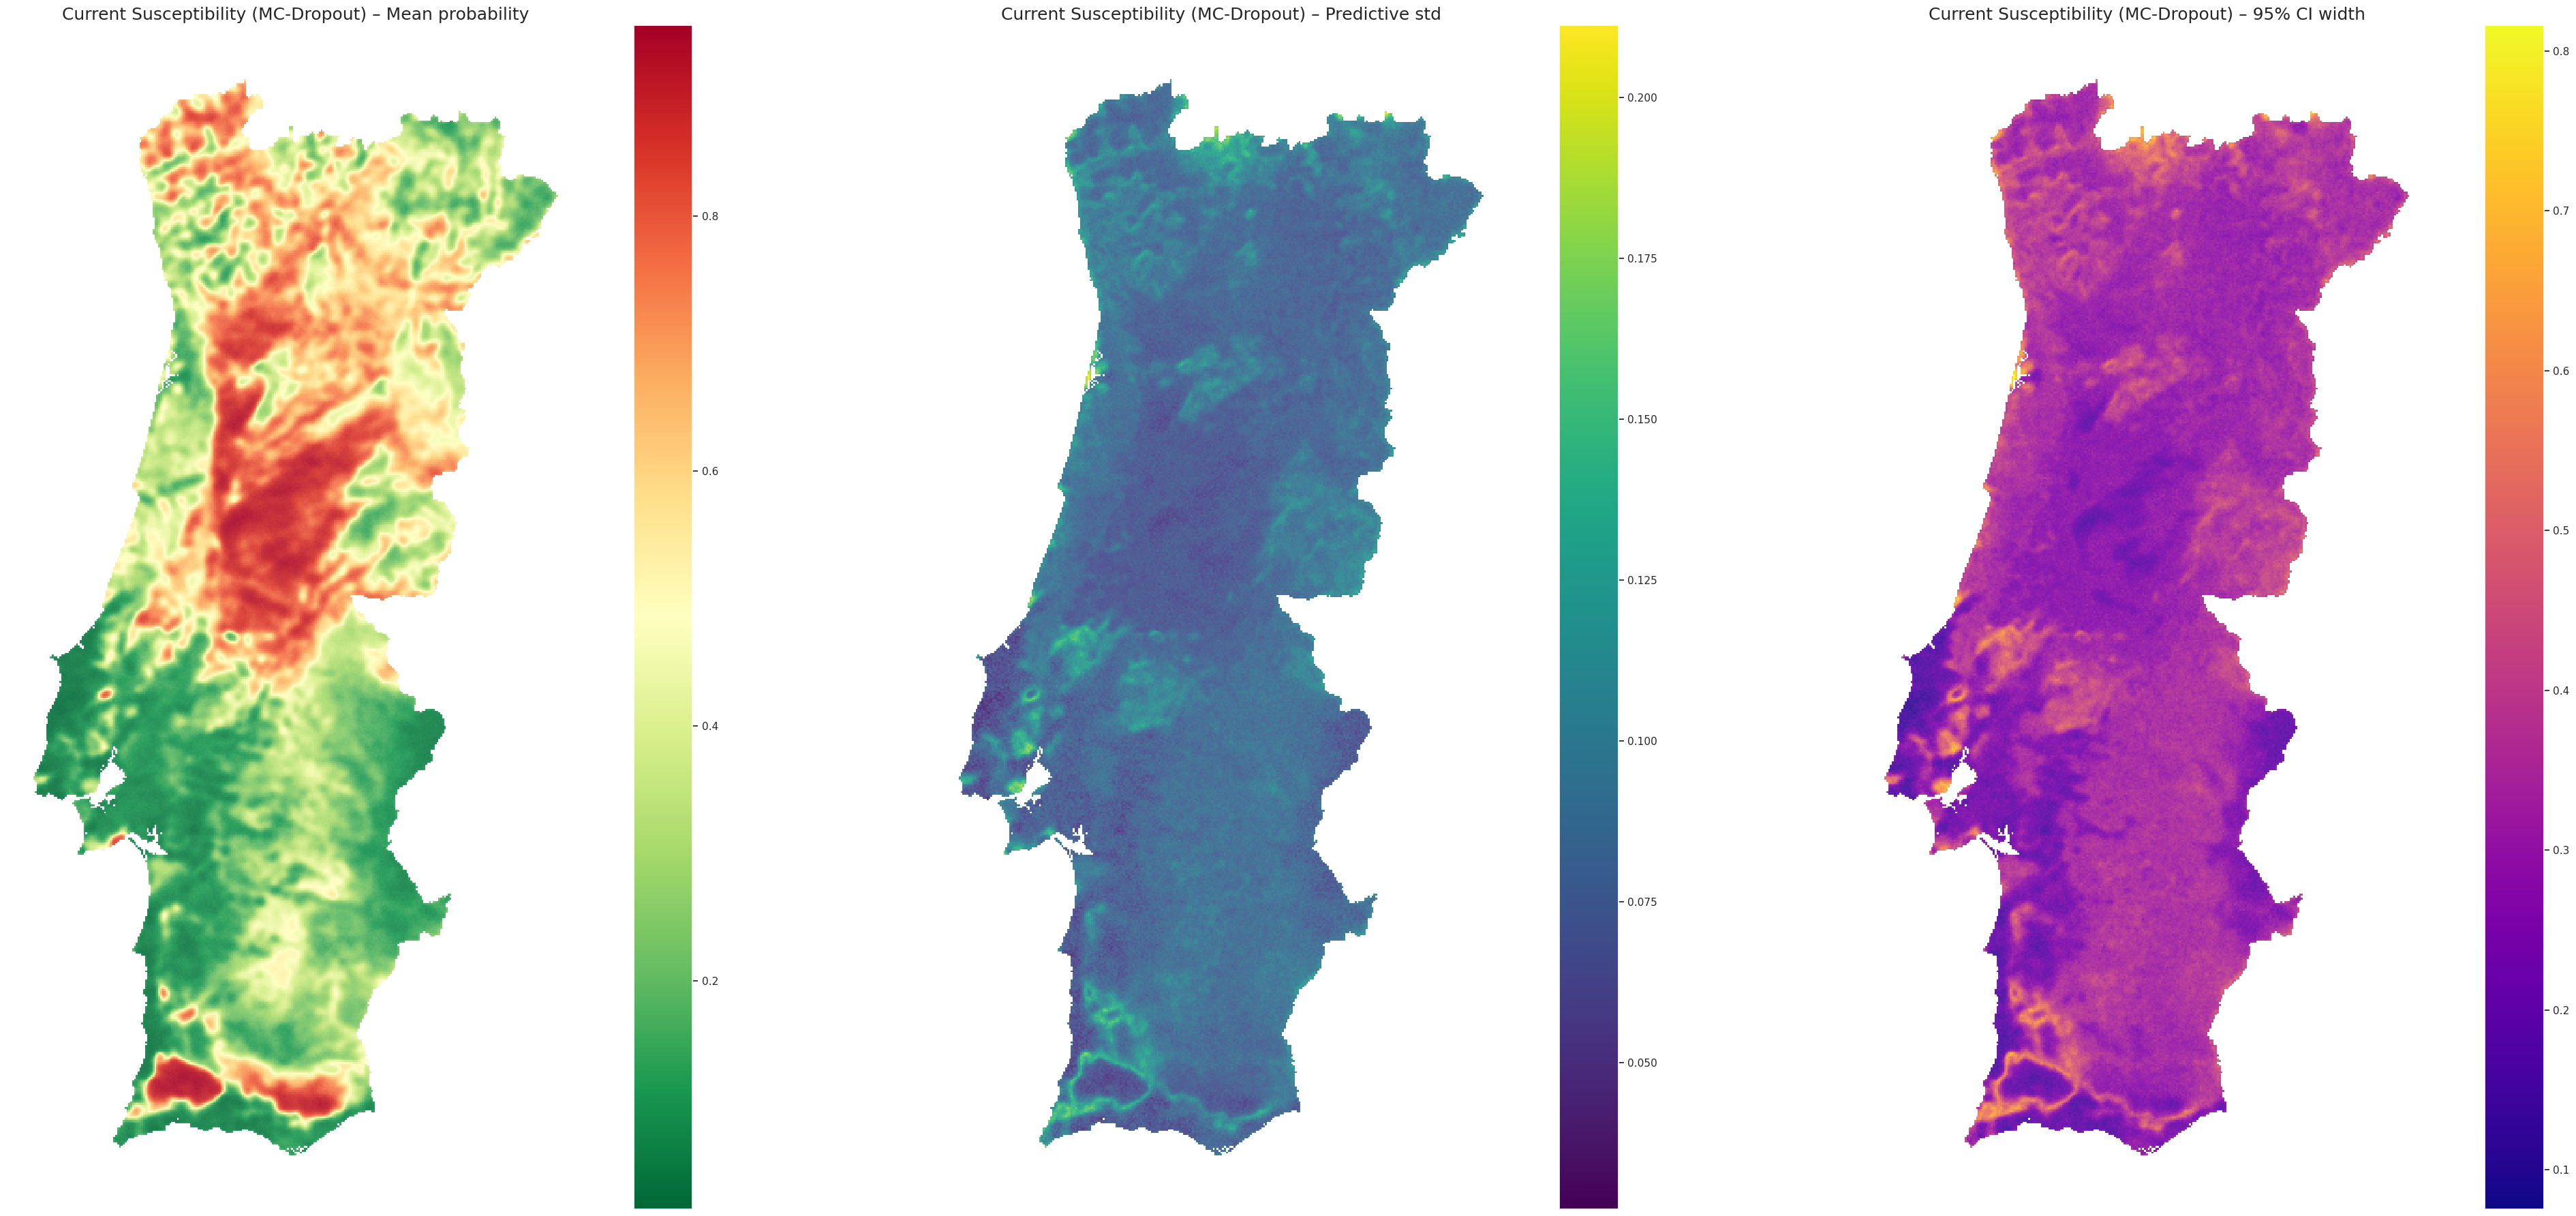

In [121]:
def remap_mc_uncertainty(
    mean_pred,
    std_pred,
    dataframe,
    id_map,
    confidence=0.95,
    title="Current Wildfire Susceptibility (MC-Dropout)"
):
    """
    Make 3 spatial plots: mean probability, predictive std, and CI width.

    Args:
        mean_pred: array-like, shape (N,) – MC-Dropout mean probabilities.
        std_pred:  array-like, shape (N,) – MC-Dropout predictive std.
        dataframe: GeoDataFrame with an 'id' column (spatial units to plot).
        id_map:    index->id mapping (list or dict) so predictions align to 'id'.
        confidence: float in (0,1), e.g. 0.95 for 95% CI.
        title: plot title prefix.

    Returns:
        gdf: GeoDataFrame with merged columns:
             ['mean_probability','std_pred','lower_ci','upper_ci','ci_width']
    """
    mean_pred = np.asarray(mean_pred).reshape(-1)
    std_pred  = np.asarray(std_pred).reshape(-1)

    # Compute z for normal-based CI; clip to [0,1] since these are probabilities
    try:
        from scipy import stats
        z = stats.norm.ppf(0.5 + confidence/2.0)
    except Exception:
        z = 1.96 if abs(confidence - 0.95) < 1e-6 else 1.96  # fallback

    lower = np.clip(mean_pred - z * std_pred, 0.0, 1.0)
    upper = np.clip(mean_pred + z * std_pred, 0.0, 1.0)
    ci_width = upper - lower

    # Build prediction table; id_map can be a list (index->id) or dict
    if isinstance(id_map, dict):
        ids = [id_map[i] for i in range(len(mean_pred))]
    else:
        ids = [id_map[i] for i in range(len(mean_pred))]

    df_pred = pd.DataFrame({
        "id": ids,
        "mean_probability": mean_pred,
        "std_pred": std_pred,
        "lower_ci": lower,
        "upper_ci": upper,
        "ci_width": ci_width
    })

    # Merge onto the spatial dataframe
    gdf = dataframe.copy()
    gdf = gdf.merge(df_pred, on="id", how="left")

    # Basic QA
    missing = gdf["mean_probability"].isna().sum()
    if missing > 0:
        print(f"Warning: {missing} geometries have no predictions after merge.")

    # Plot: mean prob, predictive std, CI width
    fig, axes = plt.subplots(1, 3, figsize=(42, 18))
    for ax in axes:
        ax.axis("off")
        ax.set_facecolor("none")

    gdf.plot(
        ax=axes[0], column="mean_probability", legend=True,
        cmap="RdYlGn_r", edgecolor="none", alpha=0.9
    )
    axes[0].set_title(f"{title} – Mean probability", fontsize=18)

    gdf.plot(
        ax=axes[1], column="std_pred", legend=True,
        cmap="viridis", edgecolor="none", alpha=0.9
    )
    axes[1].set_title(f"{title} – Predictive std", fontsize=18)

    gdf.plot(
        ax=axes[2], column="ci_width", legend=True,
        cmap="plasma", edgecolor="none", alpha=0.9
    )
    axes[2].set_title(f"{title} – {int(confidence*100)}% CI width", fontsize=18)

    plt.tight_layout()
    plt.show()

    return gdf

# Example: full-graph MC-Dropout results
mc_mean_full, mc_std_full, _, _, _ = monte_carlo_dropout_predict(
    model=best_model,
    graph=present_maxent_pyg_graph,
    n_samples=200,          # more samples → smoother estimates
)

# Spatial maps: mean, std, and 95% CI width
gdf_maps = remap_mc_uncertainty(
    mean_pred=mc_mean_full,
    std_pred=mc_std_full,
    dataframe=present_maxent_sdf_dup,  # must contain 'id'
    id_map=present_id_map,
    confidence=0.95,
    title="Current Susceptibility (MC-Dropout)"
)

# Random Forest baseline

In [124]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import make_scorer, roc_auc_score

# 定义搜索范围（小范围即可）
param_grid = {
    'n_estimators': [200, 500],
    'max_depth': [10, 20, None],
    'min_samples_split': [2, 5, 10],
    'max_features': ['sqrt', 'log2'],
    'class_weight': ['balanced']
}

rf = RandomForestClassifier(random_state=7, n_jobs=-1)

# 用验证集AUC作为搜索标准
grid_search = GridSearchCV(
    rf,
    param_grid,
    scoring=make_scorer(roc_auc_score, needs_proba=True),
    cv=3,
    verbose=2,
    n_jobs=-1
)

# 拆分数据
X = present_maxent_pyg_graph.x.cpu().numpy()
y = present_maxent_pyg_graph.y.cpu().numpy().astype(int)

X_train = X[train_indices.cpu()]
y_train = y[train_indices.cpu()]

# 开始搜索
grid_search.fit(X_train, y_train)

print("Best RF parameters:", grid_search.best_params_)
best_rf = grid_search.best_estimator_

Fitting 3 folds for each of 36 candidates, totalling 108 fits
Best RF parameters: {'class_weight': 'balanced', 'max_depth': 10, 'max_features': 'log2', 'min_samples_split': 5, 'n_estimators': 200}


In [125]:
# 验证和测试性能
rf_val_probs  = best_rf.predict_proba(X[val_indices.cpu()])[:, 1]
rf_test_probs = best_rf.predict_proba(X[test_indices.cpu()])[:, 1]

val_auc = roc_auc_score(y[val_indices.cpu()], rf_val_probs)
test_auc = roc_auc_score(y[test_indices.cpu()], rf_test_probs)
print(f"Val ROC-AUC={val_auc:.3f} | Test ROC-AUC={test_auc:.3f}")

Val ROC-AUC=0.847 | Test ROC-AUC=0.852
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=5, n_estimators=200; total time=  19.4s
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=10, n_estimators=200; total time=  20.3s
[CV] END class_weight=balanced, max_depth=10, max_features=log2, min_samples_split=2, n_estimators=500; total time=  50.1s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=5, n_estimators=200; total time=  28.7s
[CV] END class_weight=balanced, max_depth=20, max_features=sqrt, min_samples_split=10, n_estimators=500; total time= 1.0min
[CV] END class_weight=balanced, max_depth=20, max_features=log2, min_samples_split=10, n_estimators=500; total time= 1.0min
[CV] END class_weight=balanced, max_depth=None, max_features=sqrt, min_samples_split=10, n_estimators=500; total time= 1.0min
[CV] END class_weight=balanced, max_depth=10, max_features=sqrt, min_samples_split=2, n_estima

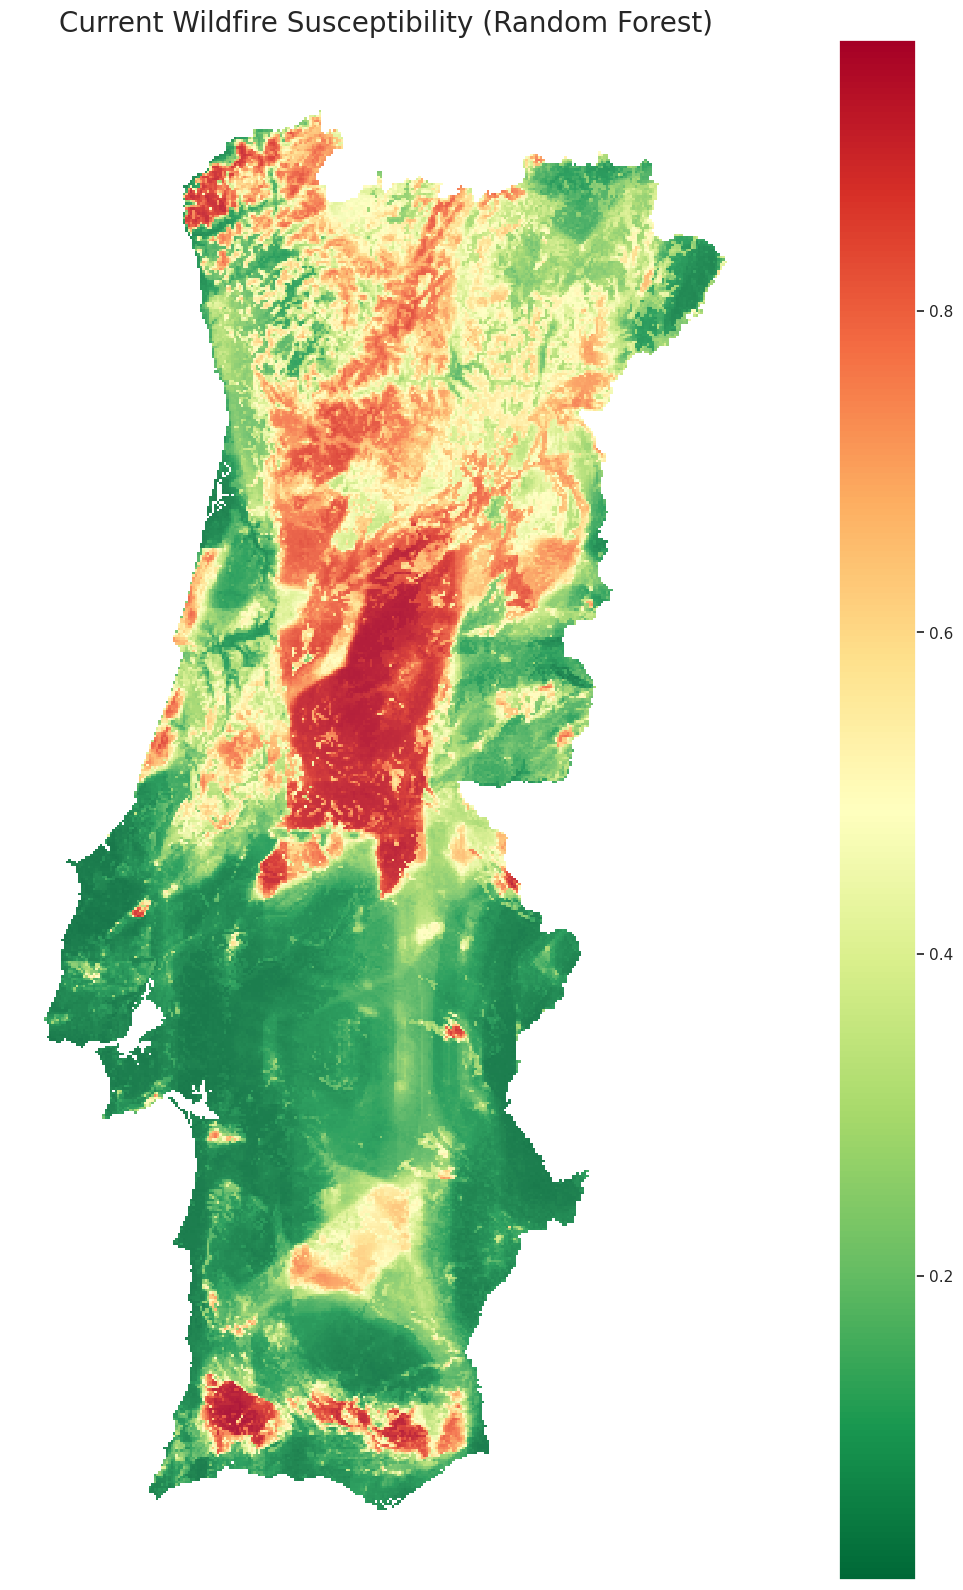

In [126]:
def remap_rf_susceptibility(
    rf_model,
    dataframe,
    id_map,
    graph,
    title="Current Wildfire Susceptibility (Random Forest)"
):
    """
    Visualize RF susceptibility over space, aligned with GCN results.

    Args:
        rf_model: trained RandomForestClassifier
        dataframe: GeoDataFrame with 'id' column
        id_map: list or dict mapping index -> id
        graph: PyG graph object (contains .x features)
        title: plot title
    """
    # 1. Predict probabilities on all nodes (same as GCN inputs)
    X_all = graph.x.cpu().numpy()
    rf_pred_prob = rf_model.predict_proba(X_all)[:, 1]

    # 2. Align predictions to spatial IDs
    if isinstance(id_map, dict):
        ids = [id_map[i] for i in range(len(rf_pred_prob))]
    else:
        ids = [id_map[i] for i in range(len(rf_pred_prob))]

    df_pred = pd.DataFrame({
        "id": ids,
        "rf_probability": rf_pred_prob
    })

    # 3. Merge onto the spatial GeoDataFrame
    gdf = dataframe.copy()
    gdf = gdf.merge(df_pred, on="id", how="left")

    missing = gdf["rf_probability"].isna().sum()
    if missing > 0:
        print(f"Warning: {missing} geometries have no predictions after merge.")

    # 4. Plot
    fig, ax = plt.subplots(figsize=(20, 20))
    fig.patch.set_facecolor('none')
    ax.set_facecolor('none')
    ax.axis("off")

    gdf.plot(
        ax=ax,
        column="rf_probability",
        legend=True,
        cmap="RdYlGn_r",
        edgecolor="none",
        alpha=0.9
    )

    ax.set_title(title, fontsize=20)
    plt.show()

    return gdf, rf_pred_prob

# Example call (assuming your variables are consistent):
gdf_rf, rf_pred_prob = remap_rf_susceptibility(
    rf_model=best_rf,
    dataframe=present_maxent_sdf_dup,
    id_map=present_id_map,
    graph=present_maxent_pyg_graph,
    title="Current Wildfire Susceptibility (Random Forest)"
)

In [152]:
def compare_gcn_rf_susceptibility(
    gcn_prob,
    rf_prob,
    id_map,
    dataframe,
    title_prefix="GCN vs Random Forest – Susceptibility Comparison"
):
    """
    Compare GCN and RF wildfire susceptibility predictions.
    """
    gcn_prob = np.ravel(gcn_prob).astype(float)
    rf_prob  = np.ravel(rf_prob).astype(float)

    # Align IDs
    if isinstance(id_map, dict):
        ids = [id_map[i] for i in range(len(gcn_prob))]
    else:
        ids = [id_map[i] for i in range(len(gcn_prob))]

    df_compare = pd.DataFrame({
        "id": ids,
        "gcn_prob_num": gcn_prob,
        "rf_prob_num": rf_prob[:len(gcn_prob)],
    })

    df_compare["diff_num"] = df_compare["gcn_prob_num"] - df_compare["rf_prob_num"]

    # Merge to GeoDataFrame (rename columns to avoid geometry confusion)
    gdf = dataframe.copy()
    gdf = gdf.drop(columns=[c for c in ["gcn_prob", "rf_prob", "diff"] if c in gdf.columns], errors="ignore")
    gdf = gdf.merge(df_compare, on="id", how="left")

    corr = np.corrcoef(df_compare["gcn_prob_num"], df_compare["rf_prob_num"])[0, 1]
    mean_diff = df_compare["diff_num"].mean()
    print(f"Spatial Pearson correlation (GCN vs RF): {corr:.3f}")
    print(f"Mean GCN − RF difference: {mean_diff:.4f}")

    # Plot
    import matplotlib.pyplot as plt
    fig, axes = plt.subplots(1, 3, figsize=(42, 18))
    for ax in axes:
        ax.axis("off")

    gdf.plot(ax=axes[0], column="rf_prob_num", cmap="RdYlGn_r", legend=True,
             edgecolor="none", alpha=0.9)
    axes[0].set_title("Random Forest – Susceptibility", fontsize=18)

    gdf.plot(ax=axes[1], column="gcn_prob_num", cmap="RdYlGn_r", legend=True,
             edgecolor="none", alpha=0.9)
    axes[1].set_title("GCN – Susceptibility", fontsize=18)

    gdf.plot(ax=axes[2], column="diff_num", cmap="coolwarm", legend=True,
             edgecolor="none", alpha=0.9, vmin=-0.4, vmax=0.4)
    axes[2].set_title("Difference (GCN − RF)", fontsize=18)

    plt.suptitle(title_prefix, fontsize=22)
    plt.tight_layout()
    plt.show()

    return gdf, df_compare


In [153]:
print("current_susceptibility type:", type(current_susceptibility))
print("rf_pred_prob type:", type(rf_pred_prob))

# If they're arrays/lists, inspect first few elements:
try:
    print("Example GCN element:", current_susceptibility[0])
    print("Example RF element:", rf_pred_prob[0])
except Exception as e:
    print("Error inspecting elements:", e)


current_susceptibility type: <class 'geopandas.geodataframe.GeoDataFrame'>
rf_pred_prob type: <class 'numpy.ndarray'>
Error inspecting elements: 0


In [154]:
print("GCN prob stats:")
print("  count:", np.sum(~np.isnan(gcn_prob)))
print("  mean:", np.nanmean(gcn_prob))
print("  std:", np.nanstd(gcn_prob))

print("\nRF prob stats:")
print("  count:", np.sum(~np.isnan(rf_pred_prob)))
print("  mean:", np.nanmean(rf_pred_prob))
print("  std:", np.nanstd(rf_pred_prob))

GCN prob stats:
  count: 88760
  mean: 0.3602062
  std: 0.32409933

RF prob stats:
  count: 88760
  mean: 0.3550089838777362
  std: 0.2760450558656252


In [155]:
gcn_prob = current_susceptibility["probability"].values

In [156]:
# Remove NaNs and ensure valid numeric values
valid_mask = (
    np.isfinite(df_compare["gcn_prob_num"]) &
    np.isfinite(df_compare["rf_prob_num"])
)

if valid_mask.sum() > 2 and df_compare.loc[valid_mask, "gcn_prob_num"].std() > 0 and df_compare.loc[valid_mask, "rf_prob_num"].std() > 0:
    corr = np.corrcoef(
        df_compare.loc[valid_mask, "gcn_prob_num"],
        df_compare.loc[valid_mask, "rf_prob_num"]
    )[0, 1]
else:
    corr = np.nan

print(f"Spatial Pearson correlation (GCN vs RF): {corr:.3f}")


Spatial Pearson correlation (GCN vs RF): 0.889


Spatial Pearson correlation (GCN vs RF): nan
Mean GCN − RF difference: 0.0052


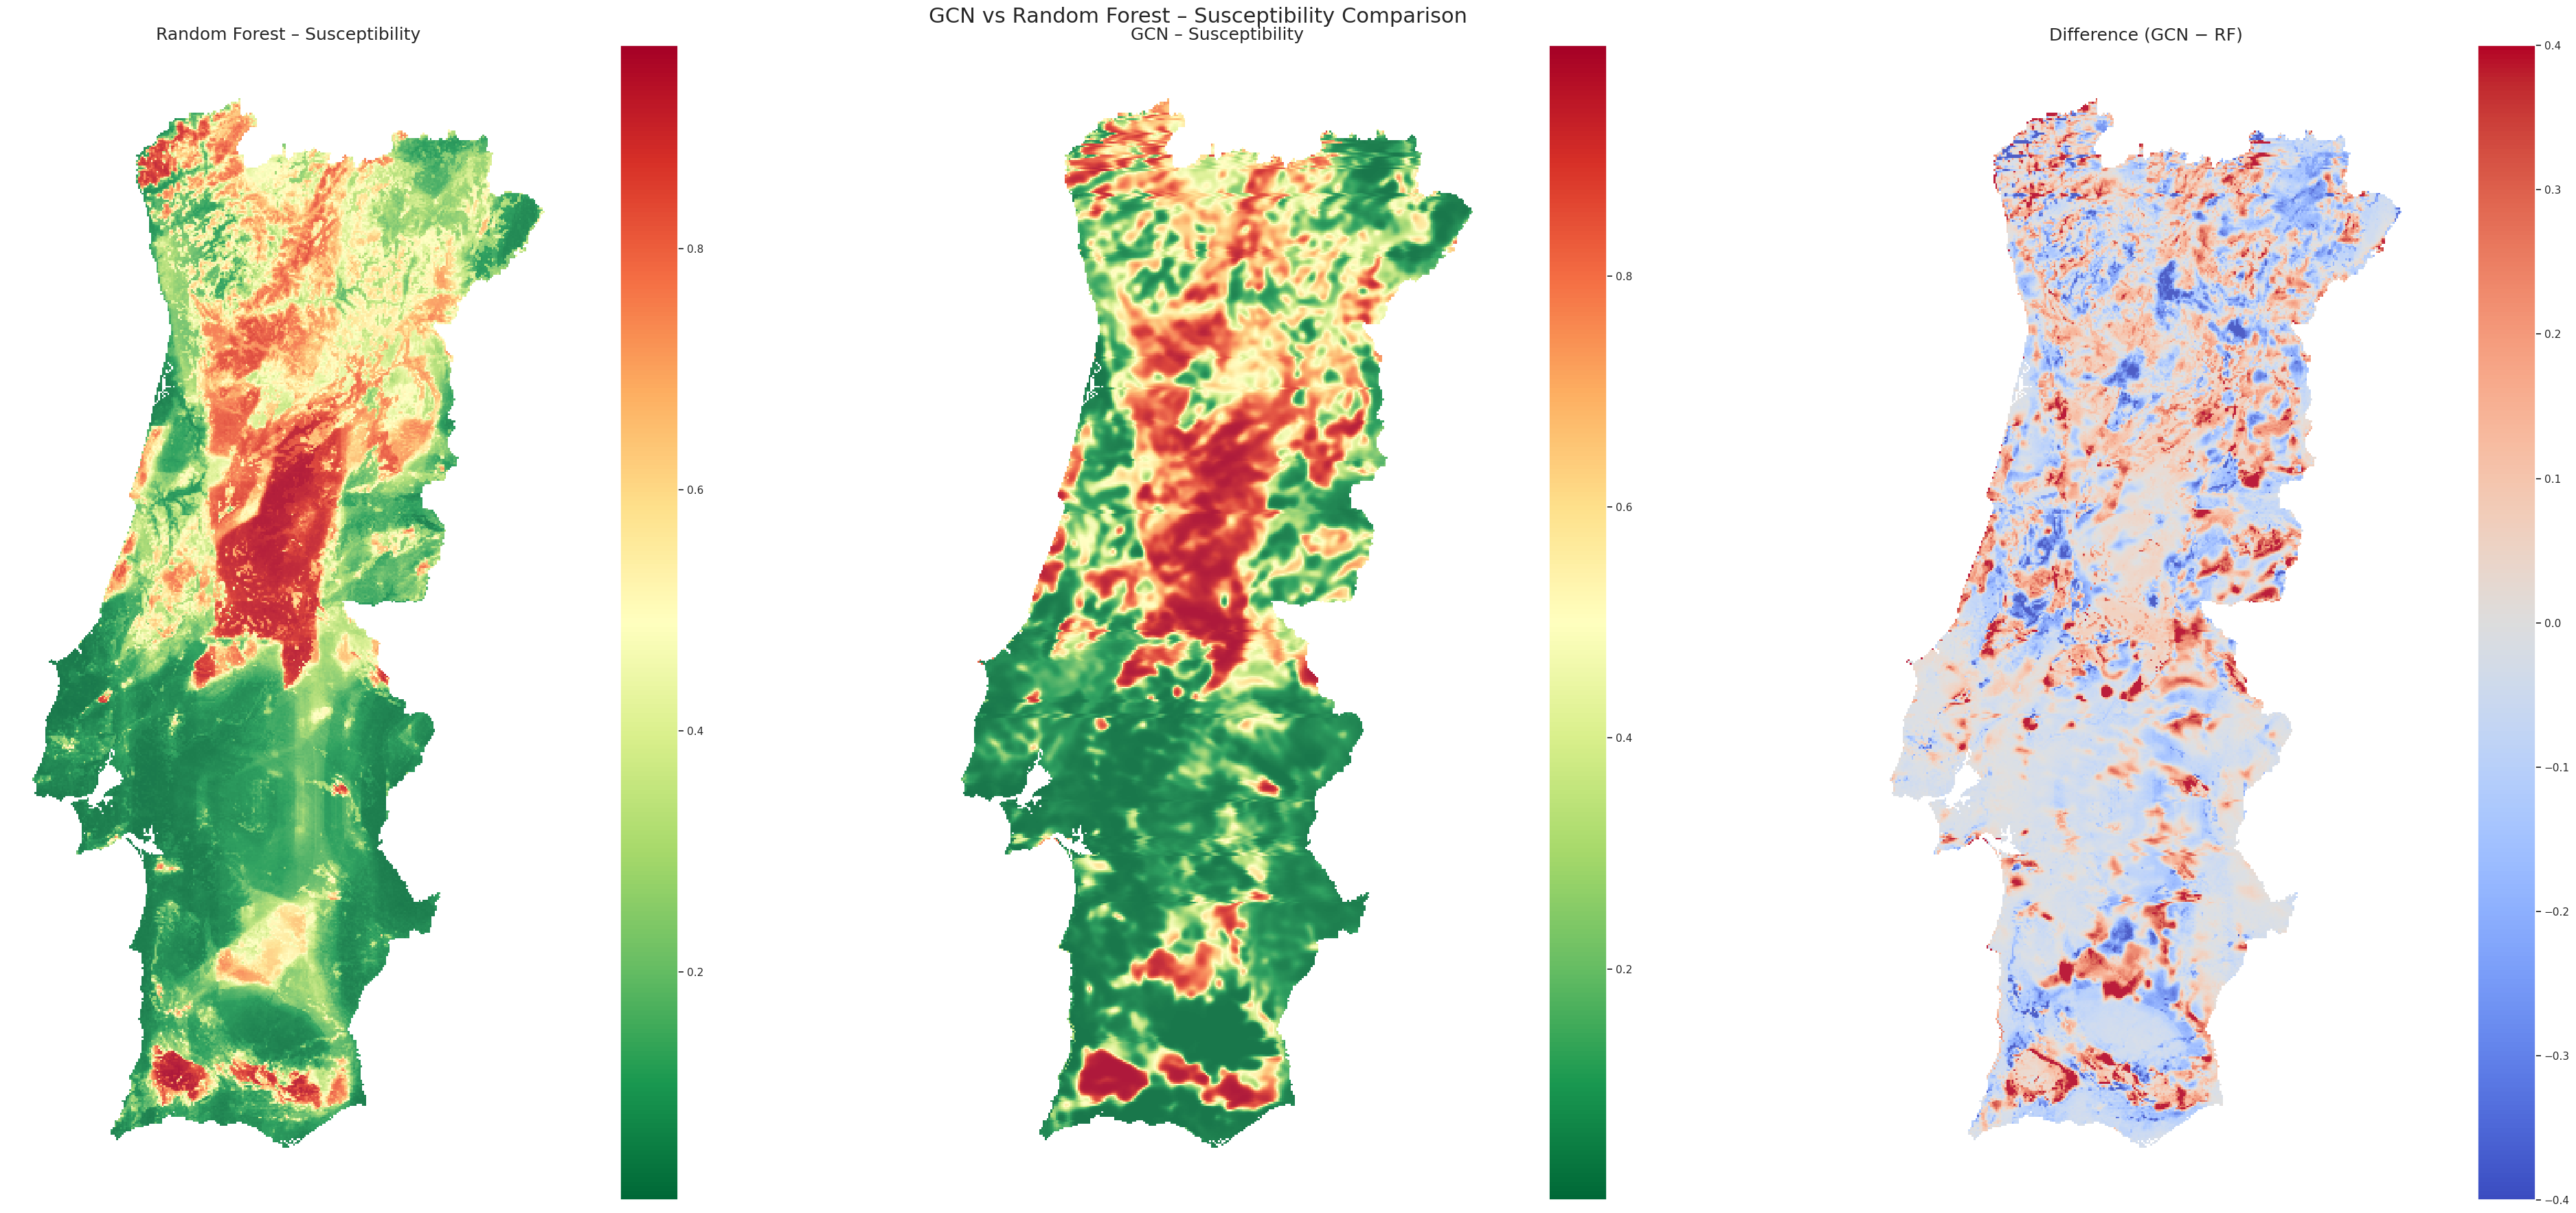

In [157]:
min_len = min(len(gcn_prob), len(rf_pred_prob), len(present_id_map))

gdf_comparison, df_compare = compare_gcn_rf_susceptibility(
    gcn_prob=gcn_prob[:min_len],
    rf_prob=rf_pred_prob[:min_len],
    id_map={k: present_id_map[k] for k in range(min_len)},
    dataframe=present_maxent_sdf_dup,
)


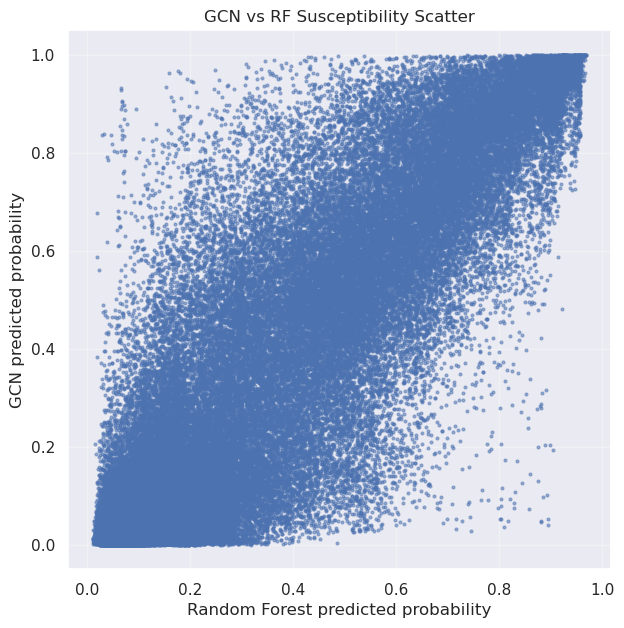

In [145]:
import matplotlib.pyplot as plt

plt.figure(figsize=(7,7))
plt.scatter(df_compare["rf_prob_num"], df_compare["gcn_prob_num"], s=4, alpha=0.5)
plt.xlabel("Random Forest predicted probability")
plt.ylabel("GCN predicted probability")
plt.title("GCN vs RF Susceptibility Scatter")
plt.grid(True, alpha=0.3)
plt.show()

In [147]:
def compute_aic_bic(y_true, y_prob, k, model_name="Model"):
    """
    Approximate AIC and BIC for probabilistic classifiers.
    
    Args:
        y_true: binary ground truth (0/1)
        y_prob: predicted probability (0–1)
        k: number of model parameters (effective complexity)
        model_name: label for printing
    """
    eps = 1e-9  # numerical stability
    y_true = np.asarray(y_true).astype(float)
    y_prob = np.clip(np.asarray(y_prob), eps, 1 - eps)
    
    # Negative log-likelihood (binary cross-entropy)
    neg_loglik = -np.mean(
        y_true * np.log(y_prob) + (1 - y_true) * np.log(1 - y_prob)
    )
    
    n = len(y_true)
    AIC = 2 * k + 2 * n * neg_loglik
    BIC = k * np.log(n) + 2 * n * neg_loglik
    
    print(f"{model_name}:")
    print(f"  BCE loss = {neg_loglik:.4f}")
    print(f"  AIC = {AIC:.2f}")
    print(f"  BIC = {BIC:.2f}\n")
    
    return AIC, BIC


In [151]:
# Ensure test_indices is on CPU and converted to numpy
test_indices_np = test_indices.cpu().numpy() if hasattr(test_indices, "cpu") else np.array(test_indices)

# Ground truth labels for test samples
y_true = present_maxent_pyg_graph.y[test_indices_np].cpu().numpy()

# Match predictions for those indices
rf_probs_test = rf_pred_prob[test_indices_np]  # RF is numpy
gcn_probs_test = current_susceptibility.loc[test_indices_np, "probability"].values

# Compute AIC / BIC
aic_rf, bic_rf = compute_aic_bic(y_true, rf_probs_test, k=5000, model_name="Random Forest")
aic_gcn, bic_gcn = compute_aic_bic(y_true, gcn_probs_test, k=12000, model_name="GCN")


Random Forest:
  BCE loss = 0.4339
  AIC = 21639.64
  BIC = 59159.54

GCN:
  BCE loss = 0.4804
  AIC = 36888.33
  BIC = 126936.09



# lets see if we can find any trends:

In [90]:
# define the bins for susceptibility
bins = [0, 0.20, 0.40, 0.60, 0.80, 1]

# define labels
labels = ["Very Low", "Low", "Medium", "High", "Very High"]

# Create the new column
current_susceptibility['susceptibility'] = pd.cut(current_susceptibility['probability'], bins=bins, labels=labels, include_lowest=True)
current_susceptibility.head()

id  hurs   pr  sfcWind  tas  tasmax  tasmin         DEM      slope  \
0   0   0.0  0.0      0.0  0.0     0.0     0.0   82.986618  14.933476   
1   1   0.0  0.0      0.0  0.0     0.0     0.0  204.336868  16.949665   
2   2   0.0  0.0      0.0  0.0     0.0     0.0  159.530380  12.910676   
3   3   0.0  0.0      0.0  0.0     0.0     0.0  145.060379  17.142456   
4   4   0.0  0.0      0.0  0.0     0.0     0.0  123.798340  16.550346   

        river  ...  Pnspnst  Pinuspn  Qrcsrtn  Qrcssbr  modis_wf  \
0   74.257401  ...      1.0      0.0      0.0      0.0       0.0   
1  318.608276  ...      1.0      0.0      0.0      0.0       0.0   
2  513.545715  ...      1.0      0.0      0.0      0.0       0.0   
3  358.473694  ...      1.0      0.0      0.0      0.0       0.0   
4  152.072922  ...      1.0      0.0      0.0      0.0       0.0   

                                            geometry  aspect_sin  aspect_cos  \
0  POLYGON ((194175.268 576088.229, 195175.268 57...    0.411631   -0.911351   
1  POLYGON ((194175.268 575088.229, 195175.268 57...    0.743156   -0.669118   
2  POLYGON ((190175.268 574088.229, 191175.268 57...    0.796179   -0.605061   
3  POLYGON ((191175.268 574088.229, 192175.268 57...    0.960941   -0.276754   
4  POLYGON ((192175.268 574088.229, 193175.268 57...    0.590976   -0.806689   

  probability  susceptibility  
0    0.440668          Medium  
1    0.481492          Medium  
2    0.483757          Medium  
3    0.502215          Medium  
4    0.535956          Medium  

[5 rows x 23 columns]

Plotting feature: hurs


/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


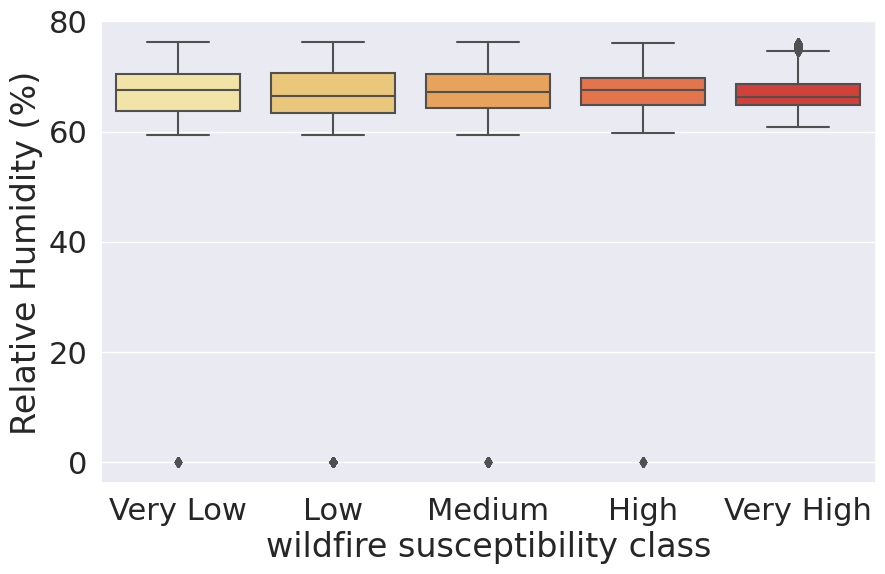

Plotting feature: pr


/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


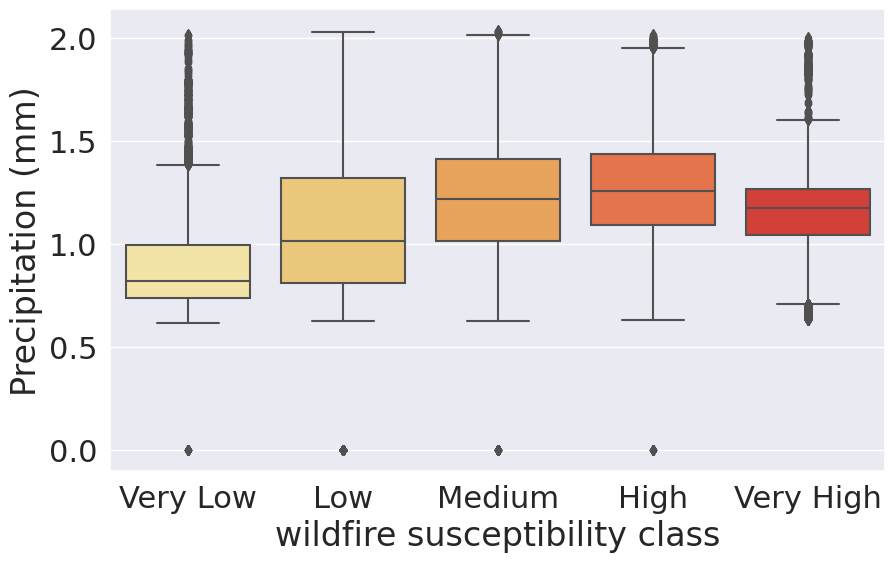

Plotting feature: tas


/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


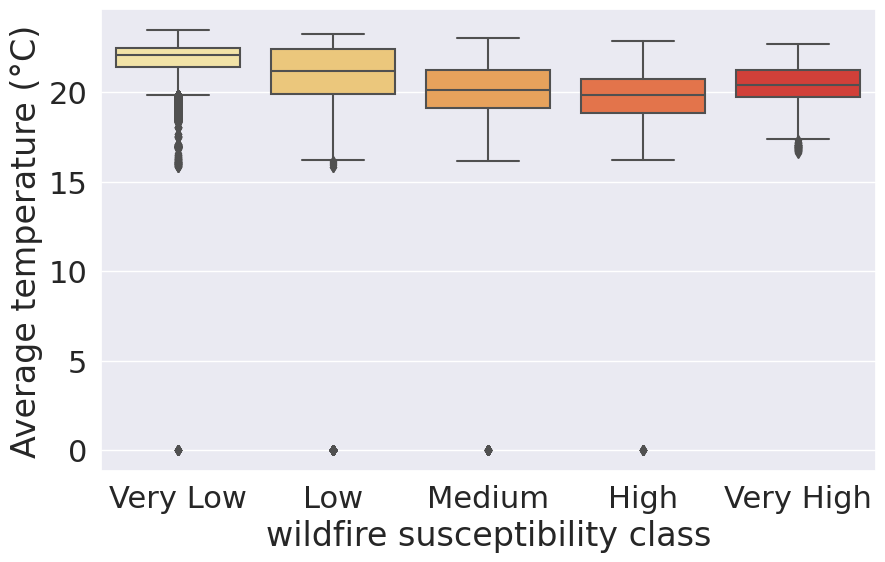

Plotting feature: tasmax


/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


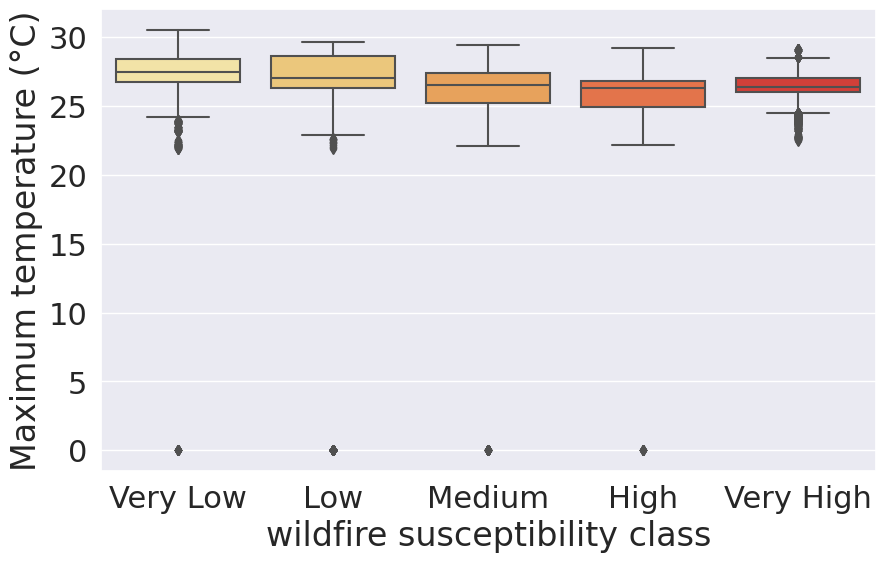

Plotting feature: tasmin


/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


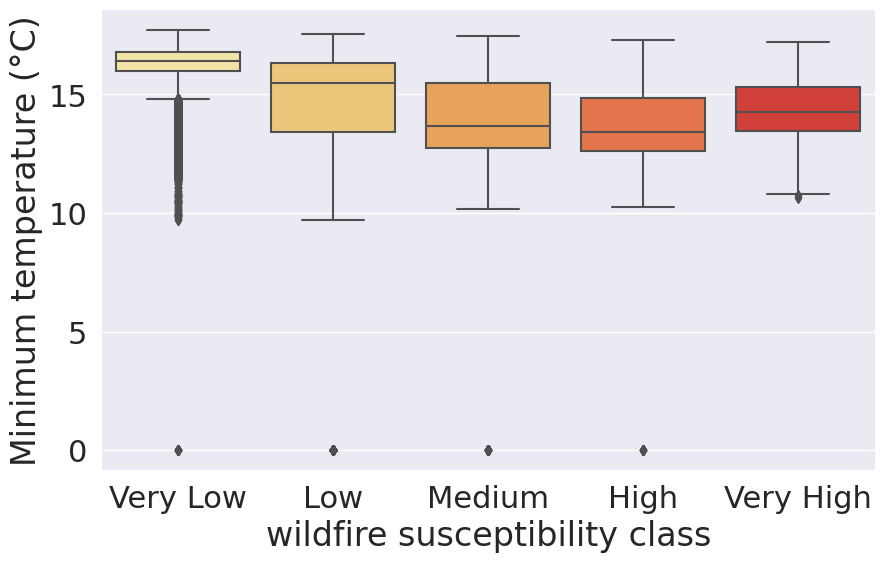

Plotting feature: sfcWind


/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


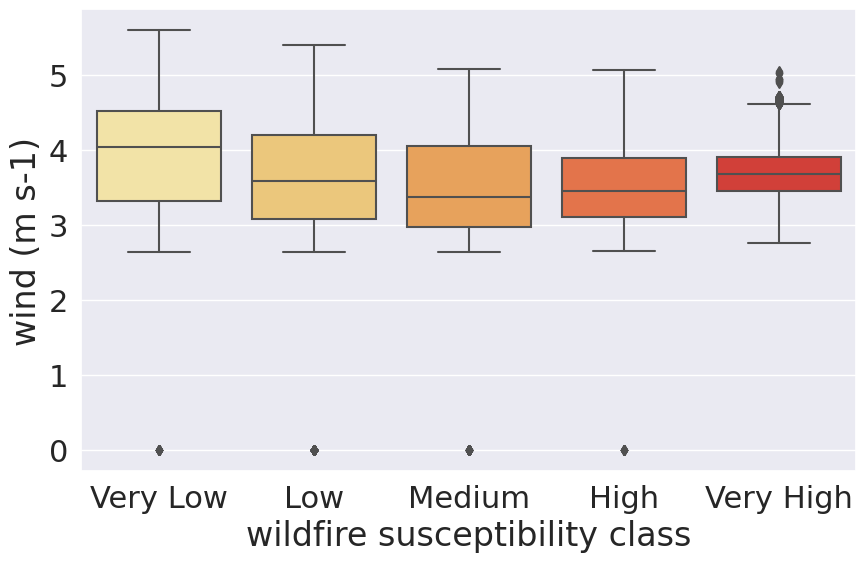

Plotting feature: aspect_sin


/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


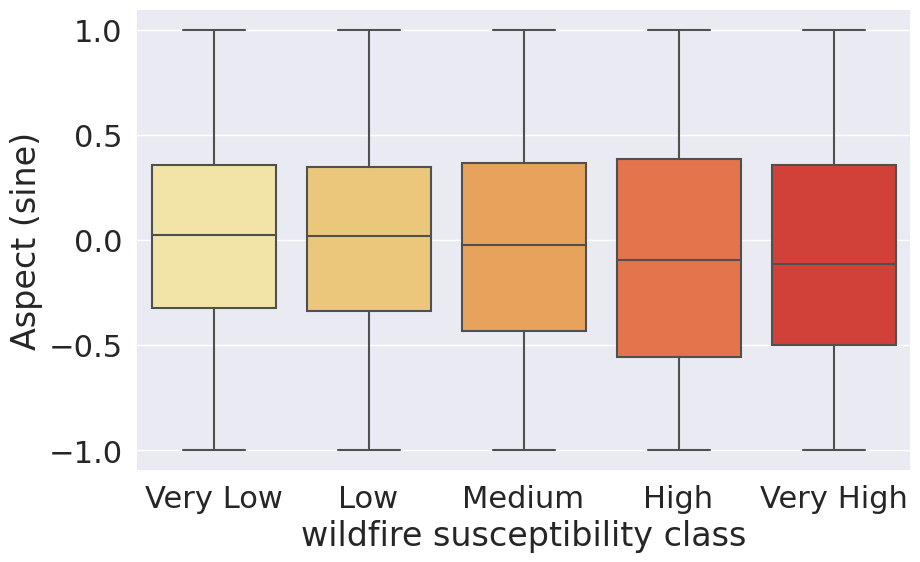

Plotting feature: aspect_cos


/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


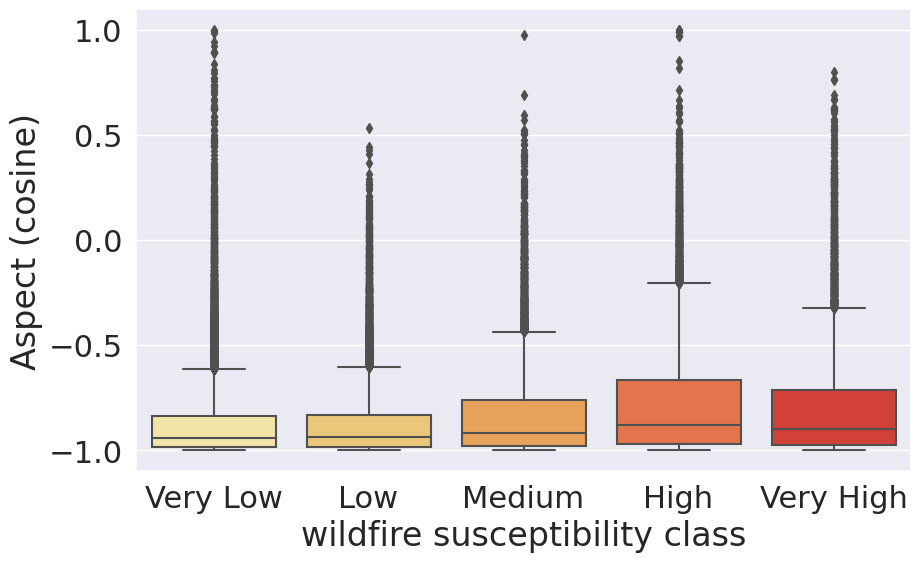

Plotting feature: DEM


/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


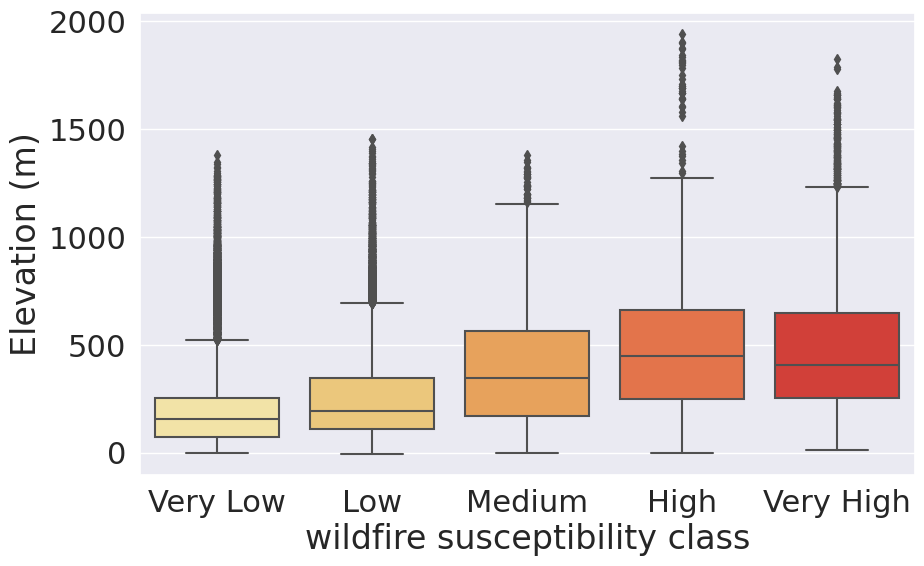

Plotting feature: slope


/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


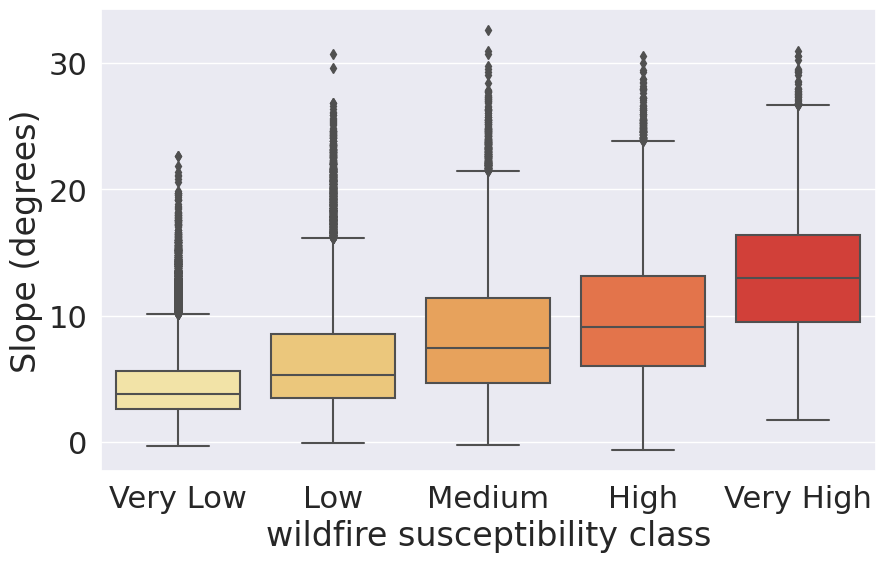

Plotting feature: river


/share/apps/anaconda3/2024.02/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


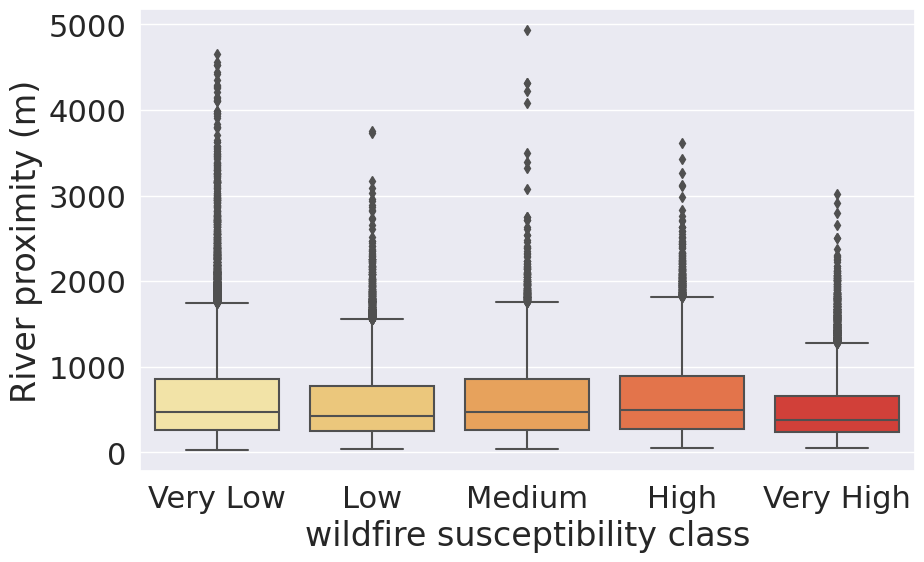

In [91]:

# list of features to plot - we won't run it for the species distribution models because they are binary.
features = ['hurs', 'pr', 'tas', 'tasmax', 'tasmin', 'sfcWind','aspect_sin','aspect_cos','DEM', 'slope', 'river']

y_axis = ['Relative Humidity (%)', 'Precipitation (mm)', 'Average temperature (°C)',
         'Maximum temperature (°C)', 'Minimum temperature (°C)', 'wind (m s-1)', 
         'Aspect (sine)', 'Aspect (cosine)', 'Elevation (m)', 'Slope (degrees)', 
         'River proximity (m)']

sns.set(font_scale = 2)
# plot a boxplot grouped by 'susceptibility' for each feature
for feature, ylabel in zip(features, y_axis):
    
    print(f"Plotting feature: {feature}")
    
    plt.figure(figsize=(10,6)) 
    sns.boxplot(x = 'susceptibility', 
                y = feature, data=current_susceptibility, 
                order = ["Very Low", "Low", "Medium", "High", "Very High"],
                palette = sns.color_palette("YlOrRd"))
    
    # give it an appropriate x axis and tick font size
    plt.ylabel(ylabel)  
    plt.xlabel('wildfire susceptibility class')
    plt.show()

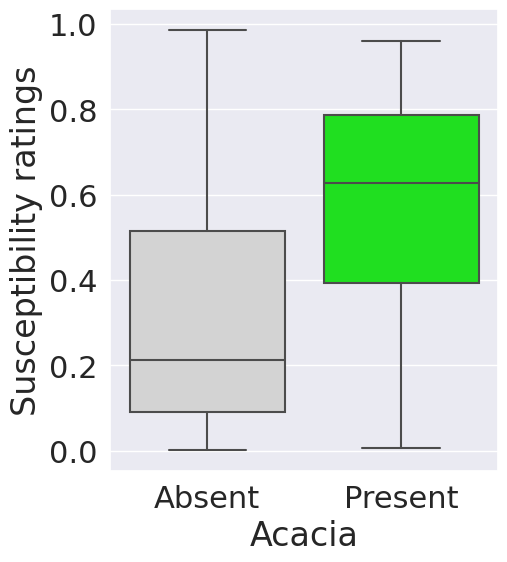

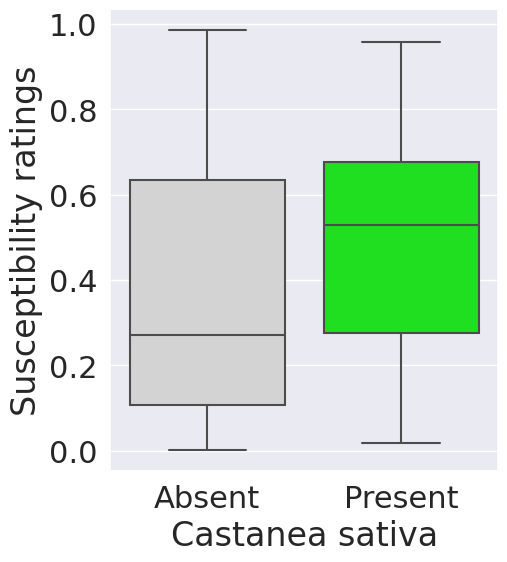

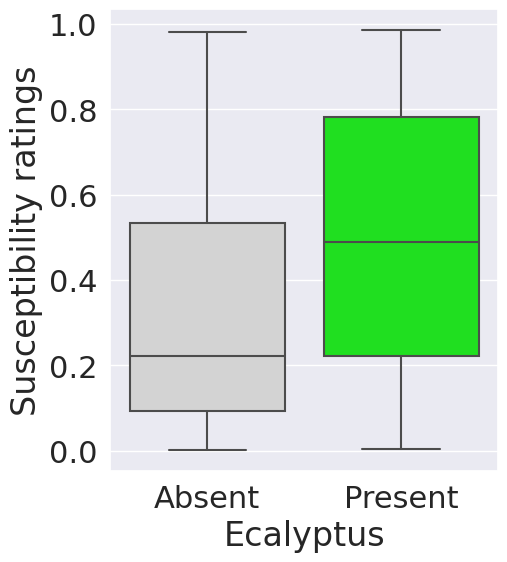

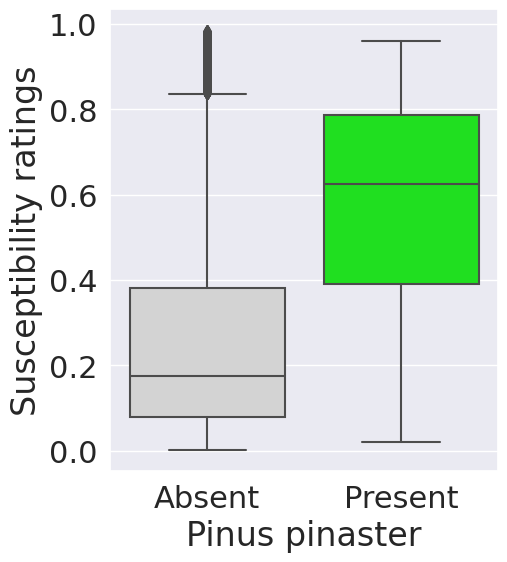

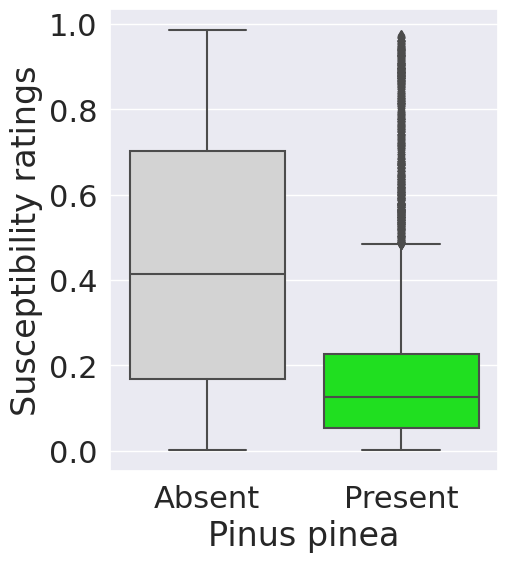

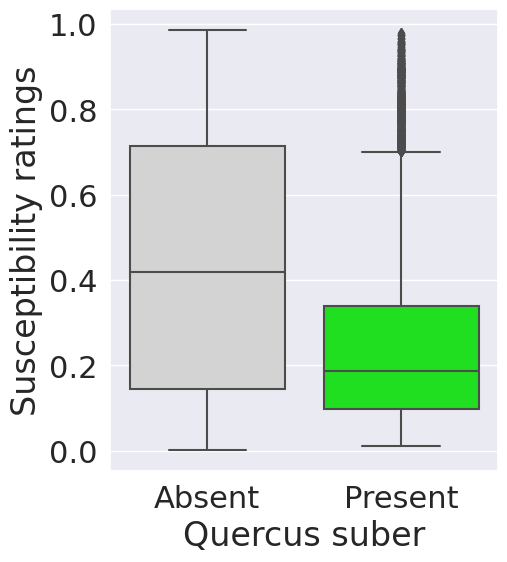

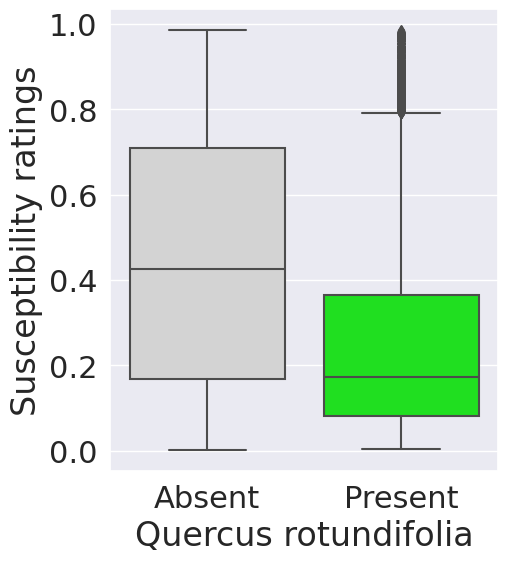

In [92]:
# sample list of x variables

species_set = ['Acacia','Cstnstv', 'Eclypts','Pnspnst','Pinuspn', 'Qrcsrtn', 'Qrcssbr'] 

species_name = ['Acacia', 'Castanea sativa', 'Ecalyptus', 'Pinus pinaster', 
                'Pinus pinea' , 'Quercus suber', 'Quercus rotundifolia']

# colour palette:
c_palette = {
    0.0 : "lightgrey",
    1.0 : "lime"
}

# loop through each species and create a boxplot against the prediction probabilities
for idx, species in enumerate(species_set):
    
    plt.figure(figsize=(5,6)) 
    ax = sns.boxplot(x=species, 
                     y='probability',
                     data=current_susceptibility,
                     palette=c_palette)
    
    # modify x-axis labels 
    ax.set_xticks([0, 1])
    ax.set_xticklabels(['Absent', 'Present'])
    
    plt.xlabel(species_name[idx])  
    plt.ylabel("Susceptibility ratings")  
    
    plt.show()

## SSP126 SSP245 SSP585

In [93]:
ssp126_path = os.path.join(current_dir, "wildfireGCN","Final","ML_input","maxent_future_126.shp")
ssp126 = gpd.read_file(ssp126_path)
ssp126.fillna(0, inplace=True)
ssp245_path = os.path.join(current_dir, "wildfireGCN","Final","ML_input","maxent_future_245.shp")
ssp245 = gpd.read_file(ssp245_path)
ssp245.fillna(0, inplace=True)
ssp585_path = os.path.join(current_dir, "wildfireGCN","Final","ML_input","maxent_future_585.shp")
ssp585 = gpd.read_file(ssp585_path)
ssp585.fillna(0, inplace=True)

In [94]:
id_unique

range(0, 88761)

In [95]:
ssp126 = ssp126.iloc[:-1].reset_index(drop=True)
ssp245 = ssp245.iloc[:-1].reset_index(drop=True)
ssp585 = ssp585.iloc[:-1].reset_index(drop=True)

In [96]:
ssp126.insert(loc=0, column='id', value=id_unique)
ssp245.insert(loc=0, column='id', value=id_unique)
ssp585.insert(loc=0, column='id', value=id_unique)

ssp126 = ssp126.drop(columns=['layer'])
ssp245 = ssp245.drop(columns=['layer'])
ssp585 = ssp585.drop(columns=['layer'])

In [97]:
ssp245

id       hurs        pr   sfcWind        tas     tasmax     tasmin  \
0          0   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
1          1   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
2          2   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
3          3   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
4          4   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
...      ...        ...       ...       ...        ...        ...        ...   
88756  88756  65.727371  0.541128  3.718002  22.377819  27.727179  17.028460   
88757  88757  66.207527  0.547323  3.788548  22.336624  27.649517  17.023731   
88758  88758  66.133423  0.546217  3.777022  22.345163  27.664061  17.026268   
88759  88759  66.059319  0.545111  3.765496  22.353704  27.678606  17.028803   
88760  88760  65.985214  0.544005  3.753970  22.362246  27.693151  17.031340   

           aspect         DEM      slope       river  Acacia  Cstnstv  \
0      155.692688   82.986618  14.933476   74.257401     1.0      0.0   
1      131.999008  204.336868  16.949665  318.608276     1.0      0.0   
2      127.233261  159.530380  12.910676  513.545715     1.0      0.0   
3      106.066582  145.060379  17.142456  358.473694     1.0      0.0   
4      143.773727  123.798340  16.550346  152.072922     1.0      0.0   
...           ...         ...        ...         ...     ...      ...   
88756  114.258789    2.545327   1.853419  696.071777     0.0      0.0   
88757   99.401497    1.099293   1.207141  215.039566     0.0      0.0   
88758  149.202682    1.197518   1.603551  231.404037     0.0      0.0   
88759  162.440628    1.623115   1.331315  227.402740     0.0      0.0   
88760  142.258041    1.982349   1.290080  215.649963     0.0      0.0   

       Eclypts  Pnspnst  Pinuspn  Qrcsrtn  Qrcssbr  \
0          0.0      1.0      0.0      0.0      0.0   
1          0.0      1.0      0.0      0.0      0.0   
2          0.0      1.0      0.0      0.0      0.0   
3          0.0      1.0      0.0      0.0      0.0   
4          0.0      1.0      0.0      0.0      0.0   
...        ...      ...      ...      ...      ...   
88756      0.0      0.0      0.0      0.0      0.0   
88757      0.0      0.0      0.0      0.0      0.0   
88758      0.0      0.0      0.0      0.0      0.0   
88759      0.0      0.0      0.0      0.0      0.0   
88760      0.0      0.0      0.0      0.0      0.0   

                                                geometry  
0      POLYGON ((194175.268 576088.229, 195175.268 57...  
1      POLYGON ((194175.268 575088.229, 195175.268 57...  
2      POLYGON ((190175.268 574088.229, 191175.268 57...  
3      POLYGON ((191175.268 574088.229, 192175.268 57...  
4      POLYGON ((192175.268 574088.229, 193175.268 57...  
...                                                  ...  
88756  POLYGON ((224175.268 2088.229, 225175.268 2088...  
88757  POLYGON ((218175.268 1088.229, 219175.268 1088...  
88758  POLYGON ((219175.268 1088.229, 220175.268 1088...  
88759  POLYGON ((220175.268 1088.229, 221175.268 1088...  
88760  POLYGON ((221175.268 1088.229, 222175.268 1088...  

[88761 rows x 19 columns]

In [98]:
ssp126

id       hurs        pr   sfcWind        tas     tasmax     tasmin  \
0          0   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
1          1   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
2          2   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
3          3   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
4          4   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
...      ...        ...       ...       ...        ...        ...        ...   
88756  88756  65.605362  0.652515  3.693805  22.711687  27.590874  17.832497   
88757  88757  66.091675  0.661666  3.768682  22.696358  27.510649  17.882067   
88758  88758  66.015747  0.660019  3.756562  22.700983  27.525814  17.876150   
88759  88759  65.939812  0.658372  3.744442  22.705606  27.540979  17.870234   
88760  88760  65.863876  0.656726  3.732321  22.710232  27.556147  17.864317   

           aspect         DEM      slope       river  Acacia  Cstnstv  \
0      155.692688   82.986618  14.933476   74.257401     1.0      0.0   
1      131.999008  204.336868  16.949665  318.608276     1.0      0.0   
2      127.233261  159.530380  12.910676  513.545715     1.0      0.0   
3      106.066582  145.060379  17.142456  358.473694     1.0      0.0   
4      143.773727  123.798340  16.550346  152.072922     1.0      0.0   
...           ...         ...        ...         ...     ...      ...   
88756  114.258789    2.545327   1.853419  696.071777     0.0      0.0   
88757   99.401497    1.099293   1.207141  215.039566     0.0      0.0   
88758  149.202682    1.197518   1.603551  231.404037     0.0      0.0   
88759  162.440628    1.623115   1.331315  227.402740     0.0      0.0   
88760  142.258041    1.982349   1.290080  215.649963     0.0      0.0   

       Eclypts  Pnspnst  Pinuspn  Qrcsrtn  Qrcssbr  \
0          0.0      1.0      0.0      0.0      0.0   
1          0.0      1.0      0.0      0.0      0.0   
2          0.0      1.0      0.0      0.0      0.0   
3          0.0      1.0      0.0      0.0      0.0   
4          0.0      1.0      0.0      0.0      0.0   
...        ...      ...      ...      ...      ...   
88756      0.0      0.0      0.0      0.0      0.0   
88757      0.0      0.0      0.0      0.0      0.0   
88758      0.0      0.0      0.0      0.0      0.0   
88759      0.0      0.0      0.0      0.0      0.0   
88760      0.0      0.0      0.0      0.0      0.0   

                                                geometry  
0      POLYGON ((194175.268 576088.229, 195175.268 57...  
1      POLYGON ((194175.268 575088.229, 195175.268 57...  
2      POLYGON ((190175.268 574088.229, 191175.268 57...  
3      POLYGON ((191175.268 574088.229, 192175.268 57...  
4      POLYGON ((192175.268 574088.229, 193175.268 57...  
...                                                  ...  
88756  POLYGON ((224175.268 2088.229, 225175.268 2088...  
88757  POLYGON ((218175.268 1088.229, 219175.268 1088...  
88758  POLYGON ((219175.268 1088.229, 220175.268 1088...  
88759  POLYGON ((220175.268 1088.229, 221175.268 1088...  
88760  POLYGON ((221175.268 1088.229, 222175.268 1088...  

[88761 rows x 19 columns]

In [99]:
ssp585

id       hurs        pr   sfcWind        tas     tasmax     tasmin  \
0          0   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
1          1   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
2          2   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
3          3   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
4          4   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
...      ...        ...       ...       ...        ...        ...        ...   
88756  88756  65.391846  0.606616  3.682621  22.586466  27.961012  17.211922   
88757  88757  65.890076  0.614984  3.756105  22.538826  27.876478  17.201178   
88758  88758  65.812981  0.613504  3.744177  22.548365  27.892124  17.204607   
88759  88759  65.735886  0.612024  3.732250  22.557903  27.907770  17.208036   
88760  88760  65.658791  0.610544  3.720323  22.567440  27.923416  17.211466   

           aspect         DEM      slope       river  Acacia  Cstnstv  \
0      155.692688   82.986618  14.933476   74.257401     1.0      0.0   
1      131.999008  204.336868  16.949665  318.608276     1.0      0.0   
2      127.233261  159.530380  12.910676  513.545715     1.0      0.0   
3      106.066582  145.060379  17.142456  358.473694     1.0      0.0   
4      143.773727  123.798340  16.550346  152.072922     1.0      0.0   
...           ...         ...        ...         ...     ...      ...   
88756  114.258789    2.545327   1.853419  696.071777     0.0      0.0   
88757   99.401497    1.099293   1.207141  215.039566     0.0      0.0   
88758  149.202682    1.197518   1.603551  231.404037     0.0      0.0   
88759  162.440628    1.623115   1.331315  227.402740     0.0      0.0   
88760  142.258041    1.982349   1.290080  215.649963     0.0      0.0   

       Eclypts  Pnspnst  Pinuspn  Qrcsrtn  Qrcssbr  \
0          0.0      1.0      0.0      0.0      0.0   
1          0.0      1.0      0.0      0.0      0.0   
2          0.0      1.0      0.0      0.0      0.0   
3          0.0      1.0      0.0      0.0      0.0   
4          0.0      1.0      0.0      0.0      0.0   
...        ...      ...      ...      ...      ...   
88756      0.0      0.0      0.0      0.0      0.0   
88757      0.0      0.0      0.0      0.0      0.0   
88758      0.0      0.0      0.0      0.0      0.0   
88759      0.0      0.0      0.0      0.0      0.0   
88760      0.0      0.0      0.0      0.0      0.0   

                                                geometry  
0      POLYGON ((194175.268 576088.229, 195175.268 57...  
1      POLYGON ((194175.268 575088.229, 195175.268 57...  
2      POLYGON ((190175.268 574088.229, 191175.268 57...  
3      POLYGON ((191175.268 574088.229, 192175.268 57...  
4      POLYGON ((192175.268 574088.229, 193175.268 57...  
...                                                  ...  
88756  POLYGON ((224175.268 2088.229, 225175.268 2088...  
88757  POLYGON ((218175.268 1088.229, 219175.268 1088...  
88758  POLYGON ((219175.268 1088.229, 220175.268 1088...  
88759  POLYGON ((220175.268 1088.229, 221175.268 1088...  
88760  POLYGON ((221175.268 1088.229, 222175.268 1088...  

[88761 rows x 19 columns]

In [100]:
# lets just calculate the aspect sin and cos for both of the dataframes
ssp126['aspect_sin'] = np.sin(np.radians(ssp126['aspect']))
ssp126['aspect_cos'] = np.cos(np.radians(ssp126['aspect']))
ssp126 = ssp126.drop(columns=['aspect'])


ssp245['aspect_sin'] = np.sin(np.radians(ssp245['aspect']))
ssp245['aspect_cos'] = np.cos(np.radians(ssp245['aspect']))
ssp245 = ssp245.drop(columns=['aspect'])

ssp585['aspect_sin'] = np.sin(np.radians(ssp585['aspect']))
ssp585['aspect_cos'] = np.cos(np.radians(ssp585['aspect']))
ssp585 = ssp585.drop(columns=['aspect'])

ssp126_dup = ssp126.copy()
ssp245_dup = ssp245.copy()
ssp585_dup = ssp585.copy()

In [101]:
ssp126_xs = ssp245[['hurs', 'pr', 'tas', 'tasmax', 'tasmin', 'sfcWind', 'aspect_sin',
                    'aspect_cos','DEM', 'slope', 'river']]

ssp245_xs = ssp245[['hurs', 'pr', 'tas', 'tasmax', 'tasmin', 'sfcWind', 'aspect_sin',
                    'aspect_cos','DEM', 'slope', 'river']]

ssp585_xs = ssp585[['hurs', 'pr', 'tas', 'tasmax', 'tasmin', 'sfcWind', 'aspect_sin',
                    'aspect_cos','DEM', 'slope', 'river']]

In [102]:
# scale it with the historical data:
ssp126_scaled = scaler.transform(ssp126_xs)
ssp245_scaled = scaler.transform(ssp245_xs)
ssp585_scaled = scaler.transform(ssp585_xs)

In [103]:
ssp126_2 = pd.DataFrame(ssp126_scaled, index=ssp126_xs.index, columns=ssp126_xs.columns)
ssp245_2 = pd.DataFrame(ssp245_scaled, index=ssp245_xs.index, columns=ssp245_xs.columns)
ssp585_2 = pd.DataFrame(ssp585_scaled, index=ssp585_xs.index, columns=ssp585_xs.columns)

In [104]:
ssp126.columns = ssp126.columns.str.strip()
print(ssp126.columns.tolist())

['id', 'hurs', 'pr', 'sfcWind', 'tas', 'tasmax', 'tasmin', 'DEM', 'slope', 'river', 'Acacia', 'Cstnstv', 'Eclypts', 'Pnspnst', 'Pinuspn', 'Qrcsrtn', 'Qrcssbr', 'geometry', 'aspect_sin', 'aspect_cos']


In [105]:
# remove the unscaled features:
ssp126 = ssp126[['id','geometry',  'Acacia', 'Cstnstv','Eclypts','Pnspnst','Pinuspn', 'Qrcsrtn', 'Qrcssbr']]
ssp245 = ssp245[['id','geometry',  'Acacia', 'Cstnstv','Eclypts','Pnspnst','Pinuspn', 'Qrcsrtn', 'Qrcssbr']]
ssp585 = ssp585[['id','geometry',  'Acacia', 'Cstnstv','Eclypts','Pnspnst','Pinuspn', 'Qrcsrtn', 'Qrcssbr']]

In [106]:
# then merge it back together
ssp126 = pd.concat([ssp126, ssp126_2], axis=1)
ssp245 = pd.concat([ssp245, ssp245_2], axis=1)
ssp585 = pd.concat([ssp585, ssp585_2], axis=1)

In [107]:
# now we can re-use the functions to create the PyG graphs! 

# step 1: generate the networkX graph and retrieve the contiguity matrix:
ssp126_graph, ssp126_contiguity_matrix = networkx_graph_gen(ssp126)
ssp245_graph, ssp245_contiguity_matrix = networkx_graph_gen(ssp245)
ssp585_graph, ssp585_contiguity_matrix = networkx_graph_gen(ssp585)


/state/partition1/job-63629641/ipykernel_610312/1258916992.py:7: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  contiguity_matrix = Queen.from_dataframe(dataframe, idVariable= 'id')
/home/fr2303/.local/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 68304.
  W.__init__(self, neighbors, ids=ids, **kw)


{'Acacia': 1.0, 'Cstnstv': 0.0, 'Eclypts': 0.0, 'Pnspnst': 1.0, 'Pinuspn': 0.0, 'Qrcsrtn': 0.0, 'Qrcssbr': 0.0, 'hurs': -11.076248593449865, 'pr': -2.1523985108689465, 'tas': -9.002742668090896, 'tasmax': -14.354389295290975, 'tasmin': -5.008943614047467, 'sfcWind': -3.7930010646626036, 'aspect_sin': 1.0054031709725284, 'aspect_cos': 1.3392511799988993, 'DEM': -0.09961067034599956, 'slope': 1.7153154763662875, 'river': -0.24092167431585182}


/state/partition1/job-63629641/ipykernel_610312/1258916992.py:7: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  contiguity_matrix = Queen.from_dataframe(dataframe, idVariable= 'id')
/home/fr2303/.local/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 68304.
  W.__init__(self, neighbors, ids=ids, **kw)


{'Acacia': 1.0, 'Cstnstv': 0.0, 'Eclypts': 0.0, 'Pnspnst': 1.0, 'Pinuspn': 0.0, 'Qrcsrtn': 0.0, 'Qrcssbr': 0.0, 'hurs': -11.076248593449865, 'pr': -2.1523985108689465, 'tas': -9.002742668090896, 'tasmax': -14.354389295290975, 'tasmin': -5.008943614047467, 'sfcWind': -3.7930010646626036, 'aspect_sin': 1.0054031709725284, 'aspect_cos': 1.3392511799988993, 'DEM': -0.09961067034599956, 'slope': 1.7153154763662875, 'river': -0.24092167431585182}


/state/partition1/job-63629641/ipykernel_610312/1258916992.py:7: FutureWarning: `idVariable` is deprecated and will be removed in future. Use `ids` instead.
  contiguity_matrix = Queen.from_dataframe(dataframe, idVariable= 'id')
/home/fr2303/.local/lib/python3.11/site-packages/libpysal/weights/contiguity.py:347: UserWarning: The weights matrix is not fully connected: 
 There are 2 disconnected components.
 There is 1 island with id: 68304.
  W.__init__(self, neighbors, ids=ids, **kw)


{'Acacia': 1.0, 'Cstnstv': 0.0, 'Eclypts': 0.0, 'Pnspnst': 1.0, 'Pinuspn': 0.0, 'Qrcsrtn': 0.0, 'Qrcssbr': 0.0, 'hurs': -11.076248593449865, 'pr': -2.1523985108689465, 'tas': -9.002742668090896, 'tasmax': -14.354389295290975, 'tasmin': -5.008943614047467, 'sfcWind': -3.7930010646626036, 'aspect_sin': 1.0054031709725284, 'aspect_cos': 1.3392511799988993, 'DEM': -0.09961067034599956, 'slope': 1.7153154763662875, 'river': -0.24092167431585182}


In [108]:
# step 2: Convert the graph to a pyG graph and extract the ids for later use:
ssp126_pyg_graph, ssp126_id_map =  pyG_graph_gen(ssp126_graph)
ssp245_pyg_graph, ssp245_id_map =  pyG_graph_gen(ssp245_graph)
ssp585_pyg_graph, ssp585_id_map =  pyG_graph_gen(ssp585_graph)

In [109]:
print(f'Number of nodes: {ssp126_pyg_graph.num_nodes}')
print(f'Number of edges: {ssp126_pyg_graph.num_edges}')
print(f'Number of features: {ssp126_pyg_graph.num_features}')

Number of nodes: 88760
Number of edges: 702960
Number of features: 18


In [110]:
print(f'Number of nodes: {ssp245_pyg_graph.num_nodes}')
print(f'Number of edges: {ssp245_pyg_graph.num_edges}')
print(f'Number of features: {ssp245_pyg_graph.num_features}')

Number of nodes: 88760
Number of edges: 702960
Number of features: 18


In [111]:
def Remapper(pred_prob, dataframe):

    df_pred = pd.DataFrame({
        'id': [present_id_map[i] for i in range(len(pred_prob))],
        'probability': pred_prob
    })
    
   
    duplicated_df = dataframe.copy()
    fine_detailed_final = duplicated_df.merge(df_pred, on='id', how='left')
    

    fig, ax = plt.subplots(figsize=(20, 20))
    fig.patch.set_facecolor('none')
    ax.set_facecolor('none')
    

    ax.spines['bottom'].set_color('black')  
    ax.spines['left'].set_color('black')    
    ax.axis('off') 
    

    fine_detailed_final.plot(
        ax=ax,
        column='probability',
        legend=True,
        alpha=0.9,
        edgecolor='none',
        cmap='RdYlGn_r'
    )
    
    
    ax.set_title("Wildfire Susceptibility", fontsize=20)
    plt.show()
    
   
    return fine_detailed_final

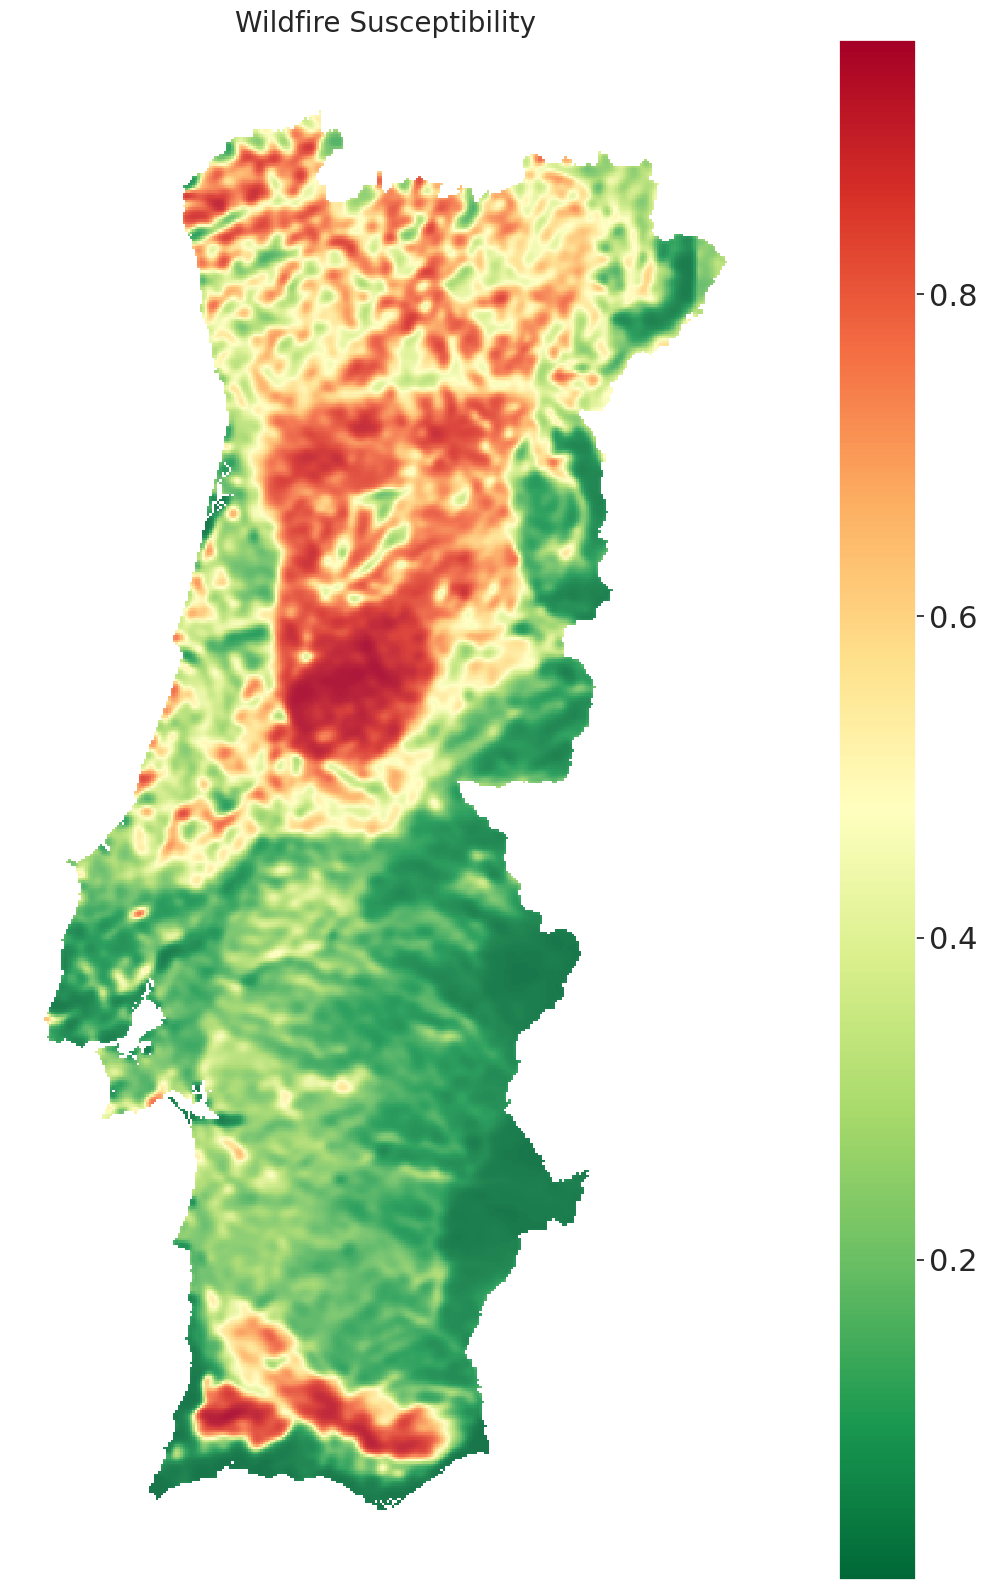

In [112]:
# now all we got to do is run it through our trained model.

# SSP126

# stick the graph on our GPU
ssp126_pyg_graph = ssp126_pyg_graph.to(device)

model.eval()

with torch.no_grad(): 
    
    # calculate the logits
    logits_126 = model(ssp126_pyg_graph.x, ssp126_pyg_graph.edge_index).squeeze()
    
    # convert the logits to probabilities - this will be intrepreted as prediction probabilities for wildfire susceptibility
    predprob_126 = torch.sigmoid(logits_126).cpu().numpy()

# now lets go ahead and visualise that.
ssp126_susceptibility = Remapper(predprob_126, ssp126_dup)

In [113]:
ssp126_susceptibility 

id       hurs        pr   sfcWind        tas     tasmax     tasmin  \
0          0   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
1          1   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
2          2   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
3          3   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
4          4   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
...      ...        ...       ...       ...        ...        ...        ...   
88756  88756  65.605362  0.652515  3.693805  22.711687  27.590874  17.832497   
88757  88757  66.091675  0.661666  3.768682  22.696358  27.510649  17.882067   
88758  88758  66.015747  0.660019  3.756562  22.700983  27.525814  17.876150   
88759  88759  65.939812  0.658372  3.744442  22.705606  27.540979  17.870234   
88760  88760  65.863876  0.656726  3.732321  22.710232  27.556147  17.864317   

              DEM      slope       river  ...  Cstnstv  Eclypts  Pnspnst  \
0       82.986618  14.933476   74.257401  ...      0.0      0.0      1.0   
1      204.336868  16.949665  318.608276  ...      0.0      0.0      1.0   
2      159.530380  12.910676  513.545715  ...      0.0      0.0      1.0   
3      145.060379  17.142456  358.473694  ...      0.0      0.0      1.0   
4      123.798340  16.550346  152.072922  ...      0.0      0.0      1.0   
...           ...        ...         ...  ...      ...      ...      ...   
88756    2.545327   1.853419  696.071777  ...      0.0      0.0      0.0   
88757    1.099293   1.207141  215.039566  ...      0.0      0.0      0.0   
88758    1.197518   1.603551  231.404037  ...      0.0      0.0      0.0   
88759    1.623115   1.331315  227.402740  ...      0.0      0.0      0.0   
88760    1.982349   1.290080  215.649963  ...      0.0      0.0      0.0   

       Pinuspn  Qrcsrtn  Qrcssbr  \
0          0.0      0.0      0.0   
1          0.0      0.0      0.0   
2          0.0      0.0      0.0   
3          0.0      0.0      0.0   
4          0.0      0.0      0.0   
...        ...      ...      ...   
88756      0.0      0.0      0.0   
88757      0.0      0.0      0.0   
88758      0.0      0.0      0.0   
88759      0.0      0.0      0.0   
88760      0.0      0.0      0.0   

                                                geometry aspect_sin  \
0      POLYGON ((194175.268 576088.229, 195175.268 57...   0.411631   
1      POLYGON ((194175.268 575088.229, 195175.268 57...   0.743156   
2      POLYGON ((190175.268 574088.229, 191175.268 57...   0.796179   
3      POLYGON ((191175.268 574088.229, 192175.268 57...   0.960941   
4      POLYGON ((192175.268 574088.229, 193175.268 57...   0.590976   
...                                                  ...        ...   
88756  POLYGON ((224175.268 2088.229, 225175.268 2088...   0.911699   
88757  POLYGON ((218175.268 1088.229, 219175.268 1088...   0.986568   
88758  POLYGON ((219175.268 1088.229, 220175.268 1088...   0.512003   
88759  POLYGON ((220175.268 1088.229, 221175.268 1088...   0.301694   
88760  POLYGON ((221175.268 1088.229, 222175.268 1088...   0.612106   

       aspect_cos  probability  
0       -0.911351     0.419676  
1       -0.669118     0.455262  
2       -0.605061     0.472562  
3       -0.276754     0.487056  
4       -0.806689     0.516205  
...           ...          ...  
88756   -0.410859     0.011632  
88757   -0.163352     0.015658  
88758   -0.858984     0.007375  
88759   -0.953405     0.009905  
88760   -0.790775     0.022070  

[88761 rows x 21 columns]

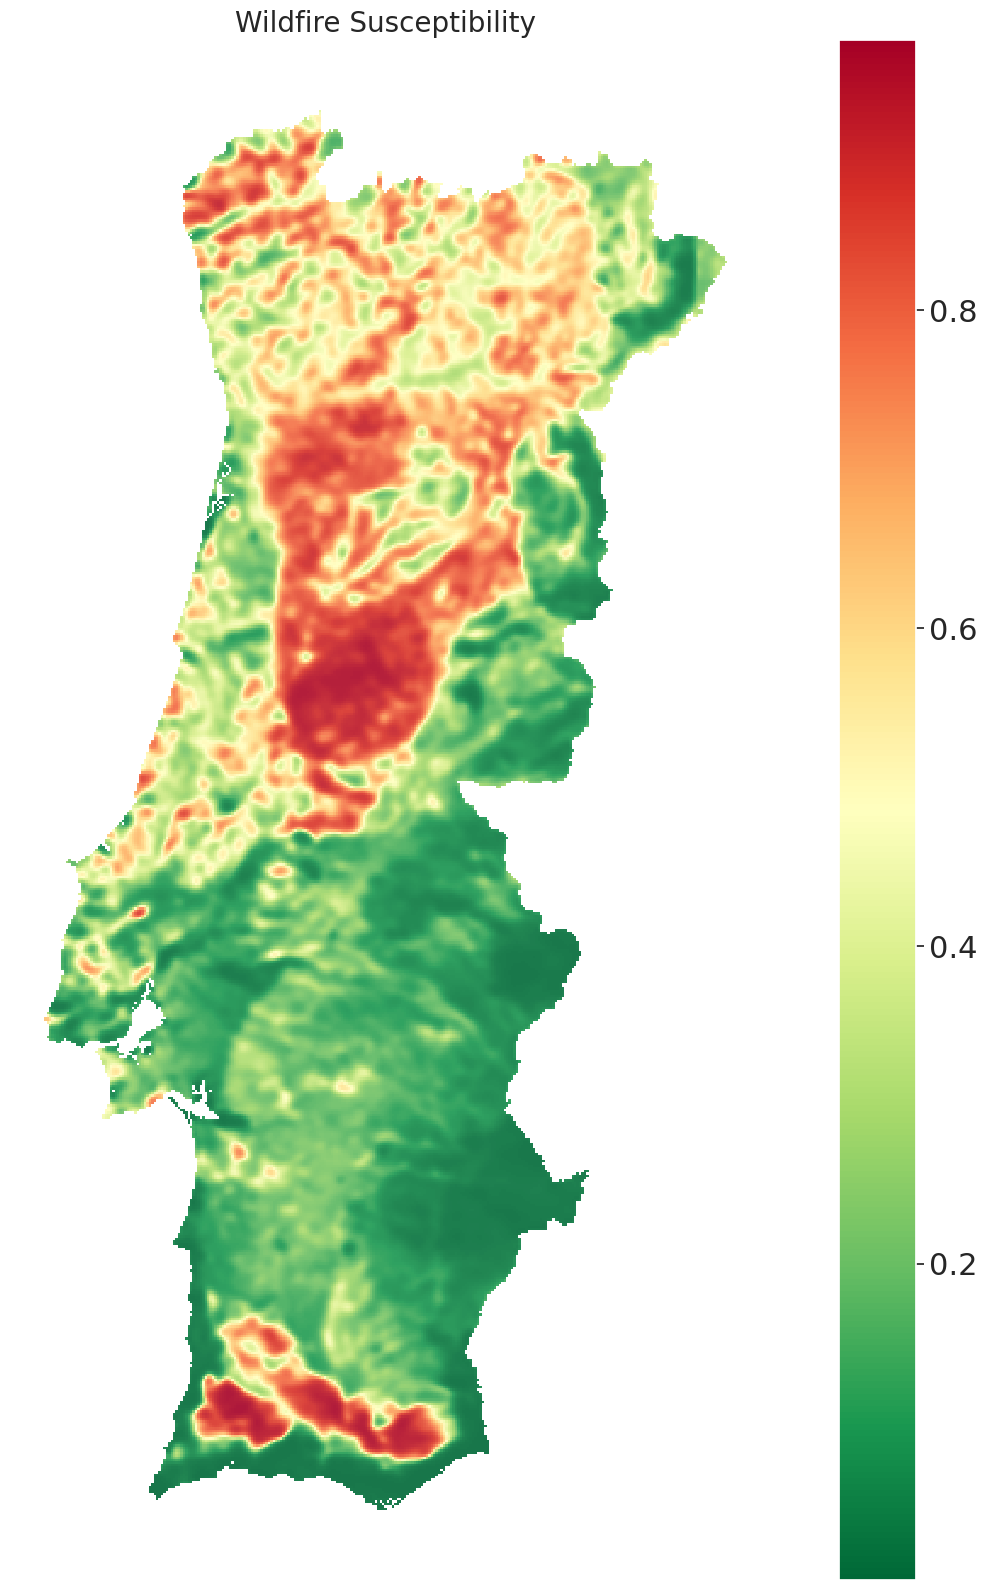

In [114]:
# now all we got to do is run it through our trained model.

# SSP245

# stick the graph on our GPU
ssp245_pyg_graph = ssp245_pyg_graph.to(device)

model.eval()

with torch.no_grad(): 
    
    # calculate the logits
    logits_245 = model(ssp245_pyg_graph.x, ssp245_pyg_graph.edge_index).squeeze()
    
    # convert the logits to probabilities - this will be intrepreted as prediction probabilities for wildfire susceptibility
    predprob_245 = torch.sigmoid(logits_245).cpu().numpy()

# now lets go ahead and visualise that.
ssp245_susceptibility = Remapper(predprob_245, ssp245_dup)

In [115]:
ssp245_susceptibility 

id       hurs        pr   sfcWind        tas     tasmax     tasmin  \
0          0   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
1          1   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
2          2   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
3          3   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
4          4   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
...      ...        ...       ...       ...        ...        ...        ...   
88756  88756  65.727371  0.541128  3.718002  22.377819  27.727179  17.028460   
88757  88757  66.207527  0.547323  3.788548  22.336624  27.649517  17.023731   
88758  88758  66.133423  0.546217  3.777022  22.345163  27.664061  17.026268   
88759  88759  66.059319  0.545111  3.765496  22.353704  27.678606  17.028803   
88760  88760  65.985214  0.544005  3.753970  22.362246  27.693151  17.031340   

              DEM      slope       river  ...  Cstnstv  Eclypts  Pnspnst  \
0       82.986618  14.933476   74.257401  ...      0.0      0.0      1.0   
1      204.336868  16.949665  318.608276  ...      0.0      0.0      1.0   
2      159.530380  12.910676  513.545715  ...      0.0      0.0      1.0   
3      145.060379  17.142456  358.473694  ...      0.0      0.0      1.0   
4      123.798340  16.550346  152.072922  ...      0.0      0.0      1.0   
...           ...        ...         ...  ...      ...      ...      ...   
88756    2.545327   1.853419  696.071777  ...      0.0      0.0      0.0   
88757    1.099293   1.207141  215.039566  ...      0.0      0.0      0.0   
88758    1.197518   1.603551  231.404037  ...      0.0      0.0      0.0   
88759    1.623115   1.331315  227.402740  ...      0.0      0.0      0.0   
88760    1.982349   1.290080  215.649963  ...      0.0      0.0      0.0   

       Pinuspn  Qrcsrtn  Qrcssbr  \
0          0.0      0.0      0.0   
1          0.0      0.0      0.0   
2          0.0      0.0      0.0   
3          0.0      0.0      0.0   
4          0.0      0.0      0.0   
...        ...      ...      ...   
88756      0.0      0.0      0.0   
88757      0.0      0.0      0.0   
88758      0.0      0.0      0.0   
88759      0.0      0.0      0.0   
88760      0.0      0.0      0.0   

                                                geometry aspect_sin  \
0      POLYGON ((194175.268 576088.229, 195175.268 57...   0.411631   
1      POLYGON ((194175.268 575088.229, 195175.268 57...   0.743156   
2      POLYGON ((190175.268 574088.229, 191175.268 57...   0.796179   
3      POLYGON ((191175.268 574088.229, 192175.268 57...   0.960941   
4      POLYGON ((192175.268 574088.229, 193175.268 57...   0.590976   
...                                                  ...        ...   
88756  POLYGON ((224175.268 2088.229, 225175.268 2088...   0.911699   
88757  POLYGON ((218175.268 1088.229, 219175.268 1088...   0.986568   
88758  POLYGON ((219175.268 1088.229, 220175.268 1088...   0.512003   
88759  POLYGON ((220175.268 1088.229, 221175.268 1088...   0.301694   
88760  POLYGON ((221175.268 1088.229, 222175.268 1088...   0.612106   

       aspect_cos  probability  
0       -0.911351     0.419676  
1       -0.669118     0.455262  
2       -0.605061     0.472562  
3       -0.276754     0.487056  
4       -0.806689     0.516205  
...           ...          ...  
88756   -0.410859     0.011631  
88757   -0.163352     0.015626  
88758   -0.858984     0.007359  
88759   -0.953405     0.009893  
88760   -0.790775     0.022053  

[88761 rows x 21 columns]

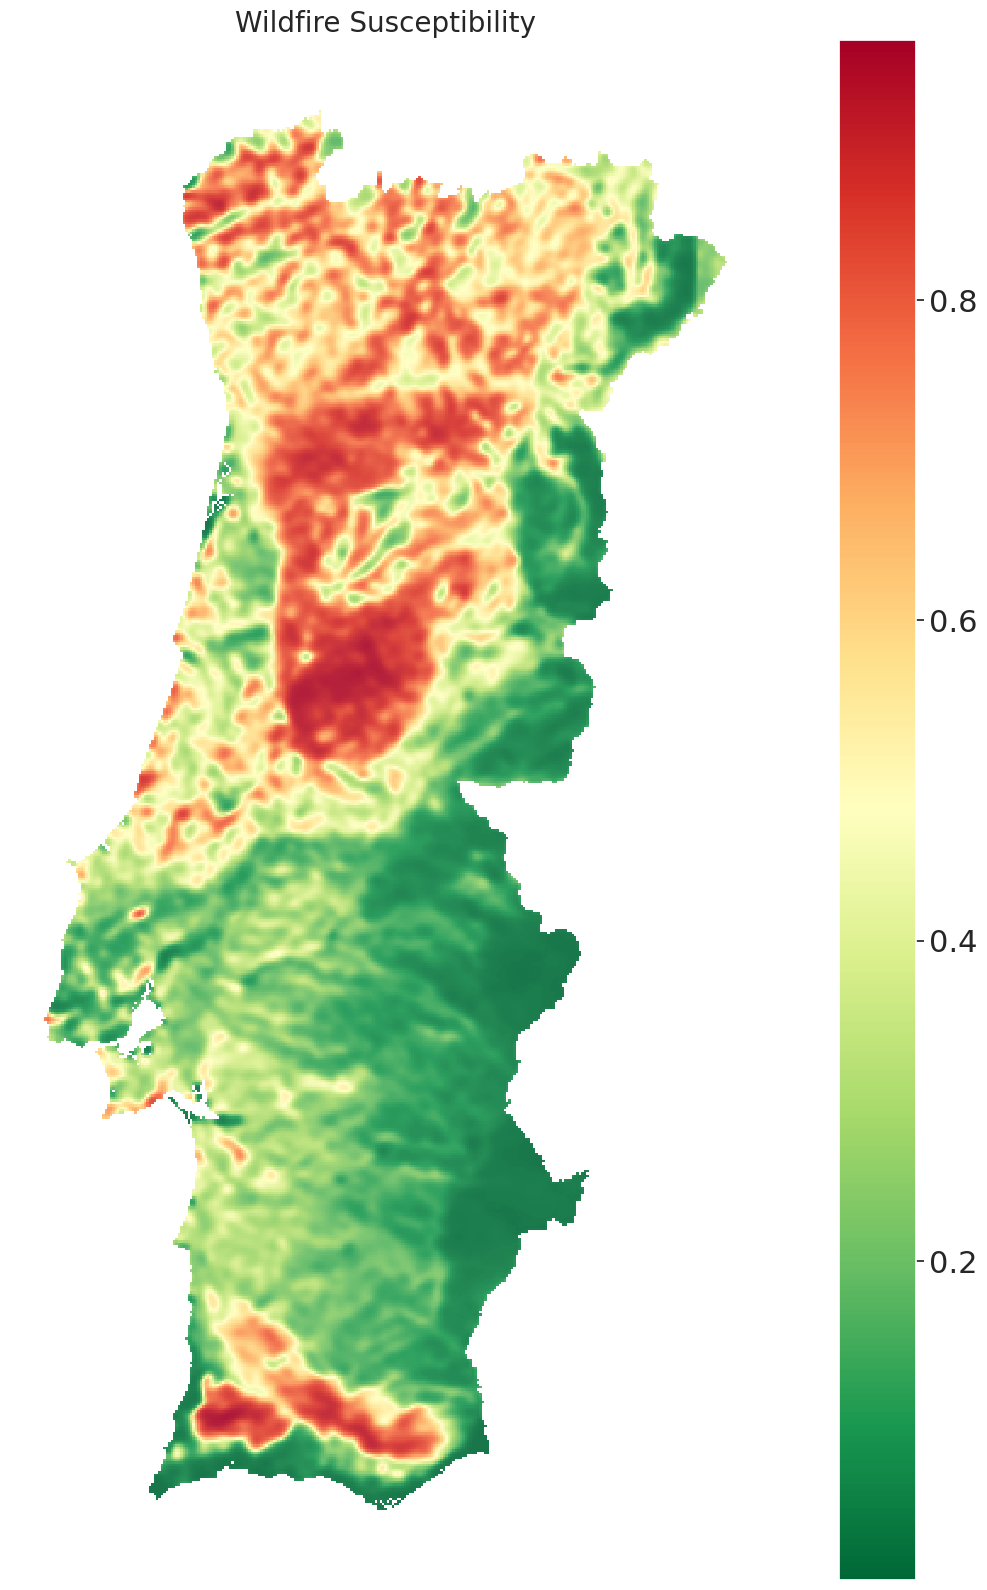

In [116]:
# SSP585

model.eval()  # Make sure the model is in evaluation mode

# stick the graph on our GPU
ssp585_pyg_graph = ssp585_pyg_graph.to(device)

with torch.no_grad(): 
    
    # calculate the logits
    logits_585 = model(ssp585_pyg_graph.x, ssp585_pyg_graph.edge_index).squeeze()
    
    # convert the logits to probabilities - this will be intrepreted as prediction probabilities for wildfire susceptibility
    predprob_585 = torch.sigmoid(logits_585).cpu().numpy()

# now lets go ahead and visualise that.
ssp585_susceptibility = Remapper(predprob_585,ssp585_dup)

In [117]:
ssp585_susceptibility

id       hurs        pr   sfcWind        tas     tasmax     tasmin  \
0          0   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
1          1   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
2          2   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
3          3   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
4          4   0.000000  0.000000  0.000000   0.000000   0.000000   0.000000   
...      ...        ...       ...       ...        ...        ...        ...   
88756  88756  65.391846  0.606616  3.682621  22.586466  27.961012  17.211922   
88757  88757  65.890076  0.614984  3.756105  22.538826  27.876478  17.201178   
88758  88758  65.812981  0.613504  3.744177  22.548365  27.892124  17.204607   
88759  88759  65.735886  0.612024  3.732250  22.557903  27.907770  17.208036   
88760  88760  65.658791  0.610544  3.720323  22.567440  27.923416  17.211466   

              DEM      slope       river  ...  Cstnstv  Eclypts  Pnspnst  \
0       82.986618  14.933476   74.257401  ...      0.0      0.0      1.0   
1      204.336868  16.949665  318.608276  ...      0.0      0.0      1.0   
2      159.530380  12.910676  513.545715  ...      0.0      0.0      1.0   
3      145.060379  17.142456  358.473694  ...      0.0      0.0      1.0   
4      123.798340  16.550346  152.072922  ...      0.0      0.0      1.0   
...           ...        ...         ...  ...      ...      ...      ...   
88756    2.545327   1.853419  696.071777  ...      0.0      0.0      0.0   
88757    1.099293   1.207141  215.039566  ...      0.0      0.0      0.0   
88758    1.197518   1.603551  231.404037  ...      0.0      0.0      0.0   
88759    1.623115   1.331315  227.402740  ...      0.0      0.0      0.0   
88760    1.982349   1.290080  215.649963  ...      0.0      0.0      0.0   

       Pinuspn  Qrcsrtn  Qrcssbr  \
0          0.0      0.0      0.0   
1          0.0      0.0      0.0   
2          0.0      0.0      0.0   
3          0.0      0.0      0.0   
4          0.0      0.0      0.0   
...        ...      ...      ...   
88756      0.0      0.0      0.0   
88757      0.0      0.0      0.0   
88758      0.0      0.0      0.0   
88759      0.0      0.0      0.0   
88760      0.0      0.0      0.0   

                                                geometry aspect_sin  \
0      POLYGON ((194175.268 576088.229, 195175.268 57...   0.411631   
1      POLYGON ((194175.268 575088.229, 195175.268 57...   0.743156   
2      POLYGON ((190175.268 574088.229, 191175.268 57...   0.796179   
3      POLYGON ((191175.268 574088.229, 192175.268 57...   0.960941   
4      POLYGON ((192175.268 574088.229, 193175.268 57...   0.590976   
...                                                  ...        ...   
88756  POLYGON ((224175.268 2088.229, 225175.268 2088...   0.911699   
88757  POLYGON ((218175.268 1088.229, 219175.268 1088...   0.986568   
88758  POLYGON ((219175.268 1088.229, 220175.268 1088...   0.512003   
88759  POLYGON ((220175.268 1088.229, 221175.268 1088...   0.301694   
88760  POLYGON ((221175.268 1088.229, 222175.268 1088...   0.612106   

       aspect_cos  probability  
0       -0.911351     0.419676  
1       -0.669118     0.455262  
2       -0.605061     0.472562  
3       -0.276754     0.487056  
4       -0.806689     0.516205  
...           ...          ...  
88756   -0.410859     0.012215  
88757   -0.163352     0.018471  
88758   -0.858984     0.009064  
88759   -0.953405     0.012048  
88760   -0.790775     0.025903  

[88761 rows x 21 columns]

In [118]:
output_dir126 = os.path.join(current_dir, "Data", "outputs", "present126_maxent_output")
shapefile_path = os.path.join(output_dir126, "ssp126_susceptibility.shp")
save_shapefile(ssp126_susceptibility, shapefile_path)

Directory /scratch/fr2303/Data/outputs/present126_maxent_output already exists.
Removing existing file: /scratch/fr2303/Data/outputs/present126_maxent_output/ssp126_susceptibility.shx
Removing existing file: /scratch/fr2303/Data/outputs/present126_maxent_output/ssp126_susceptibility.shp
Removing existing file: /scratch/fr2303/Data/outputs/present126_maxent_output/ssp126_susceptibility.prj
Removing existing file: /scratch/fr2303/Data/outputs/present126_maxent_output/ssp126_susceptibility.dbf
Removing existing file: /scratch/fr2303/Data/outputs/present126_maxent_output/ssp126_susceptibility.cpg
Saving new shapefile to: /scratch/fr2303/Data/outputs/present126_maxent_output/ssp126_susceptibility.shp


/state/partition1/job-63629641/ipykernel_610312/109850926.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(path, driver=driver)
/home/fr2303/.local/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'probability' to 'probabilit'
  ogr_write(


Shapefile saved successfully at: /scratch/fr2303/Data/outputs/present126_maxent_output/ssp126_susceptibility.shp


In [119]:
output_dir245 = os.path.join(current_dir, "Data", "outputs", "present245_maxent_output")
shapefile_path = os.path.join(output_dir245, "ssp245_susceptibility.shp")
save_shapefile(ssp245_susceptibility, shapefile_path)

Directory /scratch/fr2303/Data/outputs/present245_maxent_output already exists.
Removing existing file: /scratch/fr2303/Data/outputs/present245_maxent_output/ssp245_susceptibility.prj
Removing existing file: /scratch/fr2303/Data/outputs/present245_maxent_output/ssp245_susceptibility.shp
Removing existing file: /scratch/fr2303/Data/outputs/present245_maxent_output/ssp245_susceptibility.shx
Removing existing file: /scratch/fr2303/Data/outputs/present245_maxent_output/ssp245_susceptibility.cpg
Removing existing file: /scratch/fr2303/Data/outputs/present245_maxent_output/ssp245_susceptibility.dbf
Saving new shapefile to: /scratch/fr2303/Data/outputs/present245_maxent_output/ssp245_susceptibility.shp


/state/partition1/job-63629641/ipykernel_610312/109850926.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(path, driver=driver)
/home/fr2303/.local/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'probability' to 'probabilit'
  ogr_write(


Shapefile saved successfully at: /scratch/fr2303/Data/outputs/present245_maxent_output/ssp245_susceptibility.shp


In [120]:
output_dir585 = os.path.join(current_dir, "Data", "outputs", "future585_maxent_output")
os.makedirs(output_dir585, exist_ok=True)  # Ensure the directory exists

# Define the shapefile path
shapefile_path_585 = os.path.join(output_dir585, "ssp585_susceptibility.shp")

save_shapefile(ssp585_susceptibility, shapefile_path_585)

Directory /scratch/fr2303/Data/outputs/future585_maxent_output already exists.
Removing existing file: /scratch/fr2303/Data/outputs/future585_maxent_output/ssp585_susceptibility.shp
Removing existing file: /scratch/fr2303/Data/outputs/future585_maxent_output/ssp585_susceptibility.dbf
Removing existing file: /scratch/fr2303/Data/outputs/future585_maxent_output/ssp585_susceptibility.cpg
Removing existing file: /scratch/fr2303/Data/outputs/future585_maxent_output/ssp585_susceptibility.prj
Removing existing file: /scratch/fr2303/Data/outputs/future585_maxent_output/ssp585_susceptibility.shx
Saving new shapefile to: /scratch/fr2303/Data/outputs/future585_maxent_output/ssp585_susceptibility.shp


/state/partition1/job-63629641/ipykernel_610312/109850926.py:28: UserWarning: Column names longer than 10 characters will be truncated when saved to ESRI Shapefile.
  gdf.to_file(path, driver=driver)
/home/fr2303/.local/lib/python3.11/site-packages/pyogrio/raw.py:723: RuntimeWarning: Normalized/laundered field name: 'probability' to 'probabilit'
  ogr_write(


Shapefile saved successfully at: /scratch/fr2303/Data/outputs/future585_maxent_output/ssp585_susceptibility.shp


In [121]:
# get the sum area of suitable habitats for each species under each scenario:

# present
present_sum = present_maxent_sdf[['Acacia', 'Cstnstv','Eclypts','Pnspnst','Pinuspn', 'Qrcsrtn', 'Qrcssbr']].sum()
present_sum

Acacia     22778.0
Cstnstv    12073.0
Eclypts    33263.0
Pnspnst    33000.0
Pinuspn    18601.0
Qrcsrtn    24417.0
Qrcssbr    28575.0
dtype: float64

In [122]:
# ssp126 future 
ssp126_future_sum = ssp126_susceptibility[['Acacia', 'Cstnstv','Eclypts','Pnspnst','Pinuspn', 'Qrcsrtn', 'Qrcssbr']].sum()
ssp126_future_sum

Acacia     54436.0
Cstnstv     7172.0
Eclypts    23687.0
Pnspnst    37712.0
Pinuspn    32985.0
Qrcsrtn    39214.0
Qrcssbr     1094.0
dtype: float64

In [123]:
# ssp245 future 
ssp245_future_sum = ssp245_susceptibility[['Acacia', 'Cstnstv','Eclypts','Pnspnst','Pinuspn', 'Qrcsrtn', 'Qrcssbr']].sum()
ssp245_future_sum

Acacia     42257.0
Cstnstv     8952.0
Eclypts    25796.0
Pnspnst    38743.0
Pinuspn    24555.0
Qrcsrtn    32060.0
Qrcssbr      159.0
dtype: float64

In [124]:
## ssp585 future
ssp585_future_sum = ssp585_susceptibility[['Acacia', 'Cstnstv','Eclypts','Pnspnst','Pinuspn', 'Qrcsrtn', 'Qrcssbr']].sum()

ssp585_future_sum

Acacia     54436.0
Cstnstv     7172.0
Eclypts    23687.0
Pnspnst    37712.0
Pinuspn    32985.0
Qrcsrtn    39214.0
Qrcssbr     1094.0
dtype: float64

In [125]:
# create the new column for the susceptibility in the future dataframes
ssp126_susceptibility['susceptibility'] = pd.cut(ssp126_susceptibility['probability'], bins=bins, labels=labels, include_lowest=True)
ssp245_susceptibility['susceptibility'] = pd.cut(ssp245_susceptibility['probability'], bins=bins, labels=labels, include_lowest=True)
ssp585_susceptibility['susceptibility'] = pd.cut(ssp585_susceptibility['probability'], bins=bins, labels=labels, include_lowest=True)


In [126]:
# let's calculate the area of fire susceptibility for each category:
current_category_counts = current_susceptibility['susceptibility'].value_counts()
ssp126_category_counts = ssp126_susceptibility['susceptibility'].value_counts()
ssp245_category_counts = ssp245_susceptibility['susceptibility'].value_counts()
ssp585_category_counts = ssp585_susceptibility['susceptibility'].value_counts()

In [127]:
current_category_counts

susceptibility
Very Low     33292
Low          17740
High         14932
Medium       12339
Very High    10457
Name: count, dtype: int64

In [128]:
ssp126_category_counts

susceptibility
Very Low     31600
Low          20479
Medium       14820
High         14248
Very High     7613
Name: count, dtype: int64

In [129]:
ssp245_category_counts

susceptibility
Very Low     34805
Low          19080
Medium       13885
High         13317
Very High     7673
Name: count, dtype: int64

In [130]:
ssp585_category_counts

susceptibility
Very Low     29991
Low          20573
Medium       16133
High         14263
Very High     7800
Name: count, dtype: int64

# Feature importance and interpretability.

#### The code below for generating feature attributions using integrated gradients was adapted from the official Pytorch geometric document:

https://pytorch-geometric.readthedocs.io/en/latest/_modules/torch_geometric/nn/models/captum.html

#### and also the captum Integrated Gradients tutorial on the official website:

https://captum.ai/tutorials/Titanic_Basic_Interpret

In [131]:
from captum.attr import IntegratedGradients, FeatureAblation
from torch_geometric.nn import to_captum_model, to_captum_input

In [132]:
# create a baseline tensor of the mean of our entire dataset:

# because the first 11 features are continuous values, we will compute the mean across the dataset:
cont_feat = present_maxent_pyg_graph.x[:, :11]
mean_values = cont_feat.mean(dim=0)

# because the vegetation features are binary, i.e. 0 and 1, our baseline for that will be 0 (indicating the absence
# of that species)
# # make sure its the same data type as the mean values so they can concatenate.
species_baseline = torch.zeros((7, ), dtype=mean_values.dtype).to(device) 
single_baseline = torch.cat([mean_values, species_baseline])

# the baseline tensor has to be the same shape as the number of nodes in the graph
# i.e.  (1, number of nodes, number of features)
# because we are going to calculate the attribution for each node
baseline_tensor = single_baseline.repeat((present_maxent_pyg_graph.x.shape[0], 1)).unsqueeze(0)

print(baseline_tensor)

tensor([[[ 0.0196,  0.0641, -0.1038,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0196,  0.0641, -0.1038,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0196,  0.0641, -0.1038,  ...,  0.0000,  0.0000,  0.0000],
         ...,
         [ 0.0196,  0.0641, -0.1038,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0196,  0.0641, -0.1038,  ...,  0.0000,  0.0000,  0.0000],
         [ 0.0196,  0.0641, -0.1038,  ...,  0.0000,  0.0000,  0.0000]]],
       device='cuda:0')


In [133]:
# randomly select 100 blocks:
np.random.seed(7)
rand_blocks = np.random.choice(unique_blocks, 100, replace=False)



In [134]:
# explain predictions for all nodes
# this takes hours

import gc
def compute_int_grad(indices):
    
    mask_type = "node"
    all_attributions = []  # a list to store node-wise attributions
    
    # for progress messages...
    total_iterations = len(indices)
    step_size = total_iterations // 10
    current_iteration = 0

    for idx in indices:
        
        
        captum_model = to_captum_model(model, mask_type, output_idx=idx)
        inputs, additional_forward_args = to_captum_input(present_maxent_pyg_graph.x, 
                                                          present_maxent_pyg_graph.edge_index, mask_type)

        ig = IntegratedGradients(captum_model)
        attribution = ig.attribute(inputs=inputs,
                                   target=None,
                                   additional_forward_args=additional_forward_args,
                                   internal_batch_size=1,
                                   baselines=baseline_tensor)

        tensor_attribution = attribution[0].cpu().detach()
        sum_attribution = tensor_attribution.sum(dim=1).squeeze()

        # add the individual node's attribution to the list
        all_attributions.append(sum_attribution.numpy())
        
        # clear memory to prevent memory accumulation (= memmory errors)
        del captum_model
        del inputs
        del additional_forward_args
        del ig
        del attribution
        torch.cuda.empty_cache()
        gc.collect()
        
        current_iteration += 1
        
        # because this takes so long, i just want to have an idea of how much more computing we need to do...
        if current_iteration % step_size == 0:
            
            percentage = current_iteration * 100 // total_iterations
            print(f"{percentage}% completed")


    # convert the list of node attributions to Data Frame
    columns = ['hurs', 'pr', 'tas','tasmax', 'tasmin', 'sfcWind', 'aspect_sin', 'aspect_cos','DEM', 
           'slope', 'river', 'Acacia', 'Cstnstv', 'Eclypts','Pnspnst','Pinuspn', 'Qrcsrtn', 
           'Qrcssbr']
    
    attribution_df = pd.DataFrame(all_attributions, columns = columns)
    
    return attribution_df

In [ ]:

ig_indices = present_maxent_sdf[present_maxent_sdf['block_id'].isin(rand_blocks)]['id'].to_list()

attribution_df = compute_int_grad(ig_indices)  


9% completed
19% completed
29% completed
39% completed
49% completed
59% completed


In [ ]:
# reset Seaborn settings to default
import seaborn as sns
sns.set()

# reset matplotlib rc parameters to default
plt.rcParams.update(plt.rcParamsDefault)


In [ ]:
# univariate analysis

columns_to_plot = ['hurs', 'pr', 'tas', 'tasmax', 'tasmin', 'sfcWind',
                   'aspect_sin', 'aspect_cos', 'DEM', 'slope', 'river','Acacia',
                   'Cstnstv', 'Eclypts','Pnspnst','Pinuspn', 'Qrcsrtn', 'Qrcssbr']

titles = ['Relative Humidity', 'Precipitation', 'Average temperature',
         'Maximum temperature', 'Minimum temperatur', 'wind', 
         'Aspect (sine)', 'Aspect (cosine)', 'Elevation', 'Slope', 
         'River proximity', 'Acacia', 'Castanea Sativa', 'Eucalyptus',
         'Pinus pinaster', 'Pinus pinea', 'Quercus rotundifolia',  ' Quercus suber']

# plotting
ax_arr = attribution_df[columns_to_plot].hist(figsize=[15, 15])

for ax, title in zip(ax_arr.flatten(), titles):
    ax.set_title(title)

plt.tight_layout()
plt.show()

In [ ]:
columns_to_plot = ['hurs', 'pr', 'tas', 'tasmax', 'tasmin', 'sfcWind', 'aspect_sin',
                  'aspect_cos', 'DEM', 'slope', 'river', 'Acacia', 'Cstnstv', 
                   'Eclypts','Pnspnst','Pinuspn', 'Qrcsrtn', 'Qrcssbr']

titles = ['Relative Humidity', 'Precipitation', 'Average temperature',
         'Maximum temperature', 'Minimum temperatur', 'wind', 
         'Aspect (sine)', 'Aspect (cosine)', 'Elevation', 'Slope', 
         'River proximity', 'Acacia', 'Castanea Sativa', 'Eucalyptus',
         'Pinus pinaster', 'Pinus pinea', 'Quercus rotundifolia',  ' Quercus suber']

sns.set_style("white")
# convert to long form
df_melted = pd.melt(attribution_df, value_vars=columns_to_plot)

# replace the 'variable' column values with the human-readable titles
df_melted['variable'] = df_melted['variable'].replace(columns_to_plot, titles)

# plot the boxplot
sns.set(font_scale=1)
plt.figure(figsize=(15, 10))
sns.boxplot(x='variable', y='value', data=df_melted)
plt.title("Maxent-WSM integrated gradients", fontsize = 20)  
plt.xticks(rotation=90)
plt.show()

In [ ]:
# function to compute the count of positive, negative, and zero values
def value_counts(x):
    return {
        "positive": (x > 0).sum(),
        "negative": (x < 0).sum(),
        "zero": (x == 0).sum()
    }

def calc_stats (dataframe):
    
    # dataframe statistics
    stats_df = pd.DataFrame({
        'mean': dataframe.mean(),
        'median': dataframe.median(),
        'mode': dataframe.mode().iloc[0],  # mode can return multiple values, so take the first one
        'skewness': dataframe.skew(),
    }).join(pd.DataFrame(dataframe.apply(value_counts).tolist(), index=dataframe.columns))

    
    return(stats_df)


In [ ]:
stats_individual = calc_stats(attribution_df)
stats_individual

In [ ]:
output_dir = os.path.join(current_dir, "Data", "stats", "output_stats", "maxent-GCN")

# Create the directory if it doesn't exist
os.makedirs(output_dir, exist_ok=True)

# Define the full path for the Excel file
output_file = os.path.join(output_dir, "int-grad.xlsx")

# Save the DataFrame to the specified path
stats_individual.to_excel(output_file, index=False)

print(f"File saved successfully at: {output_file}")

In [ ]:
# just going to extract save the blocks for the integrated gradients for the write up:
# just for visualisation purposes
current_susceptibility['rdm_ig'] = current_susceptibility['id'].apply(lambda x: 1 if x in ig_indices else 0)

In [ ]:
output_dir = os.path.join(current_dir, "Data", "outputs", "ig_blocks")
shapefile_path = os.path.join(output_dir, "ig_blocks.shp")

rdm_ig = current_susceptibility.copy()
rdm_ig = rdm_ig.drop(columns=['susceptibility'])
save_shapefile(rdm_ig, shapefile_path)